In [1]:
import scipy.io
import matplotlib.pyplot as plt
import numpy as np
import optuna
data = scipy.io.loadmat('data/assignmentImageDenoising_brainMRIslice.mat')

print("Keys in the loaded data:")
print(list(data.keys()))

Keys in the loaded data:
['__header__', '__version__', '__globals__', 'brainMRIsliceNoisy', 'brainMRIsliceOrig']


In [2]:

image_noiseless = data['brainMRIsliceOrig']
image_noisy = data['brainMRIsliceNoisy']


print(f"Noiseless image shape: {image_noiseless.shape}")
print(f"Noisy image shape: {image_noisy.shape}")
print(f"Image data type: {image_noiseless.dtype}")
print(f"Noiseless image range: [{np.min(image_noiseless):.3f}, {np.max(image_noiseless):.3f}]")
print(f"Noisy image range: [{np.min(image_noisy):.3f}, {np.max(image_noisy):.3f}]")

Noiseless image shape: (256, 256)
Noisy image shape: (256, 256)
Image data type: float64
Noiseless image range: [0.000, 1.000]
Noisy image range: [0.001, 1.204]


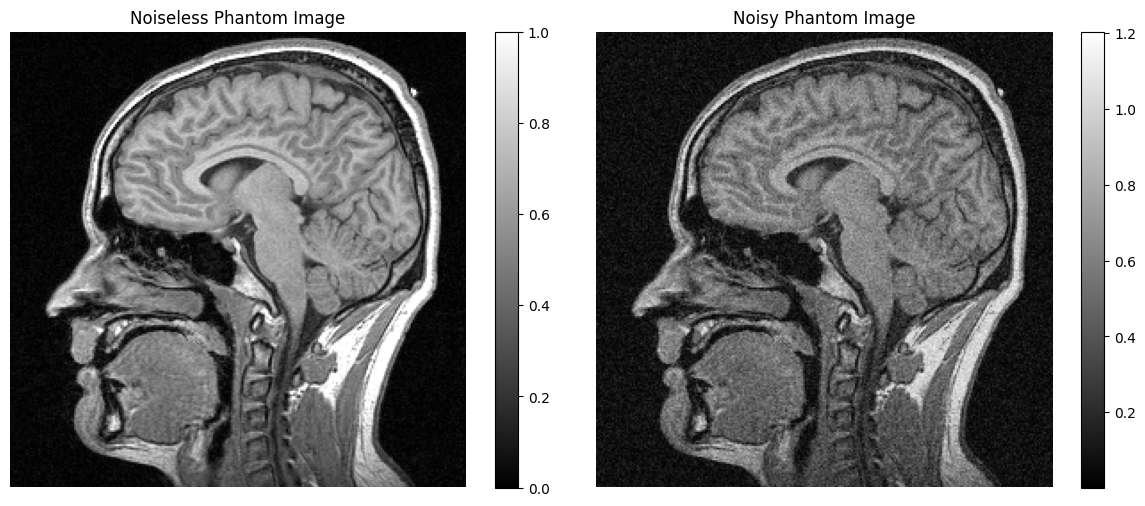

In [3]:
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.imshow(image_noiseless, cmap='gray')
plt.title('Noiseless Phantom Image')
plt.colorbar()
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(image_noisy, cmap='gray')
plt.title('Noisy Phantom Image')
plt.colorbar()
plt.axis('off')

plt.tight_layout()
plt.show()

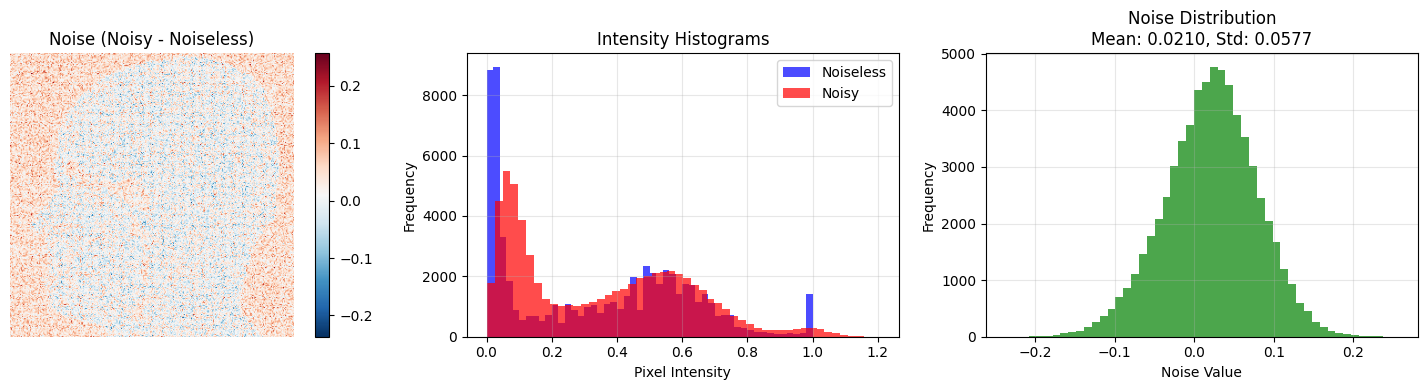

Summary Statistics:
Image size: (256, 256)
Noise standard deviation: 0.0577
Noise mean: 0.0210
Signal-to-Noise ratio (SNR): 13.63 dB


In [4]:
noise = image_noisy - image_noiseless
noise_std = np.std(noise)
noise_mean = np.mean(noise)

plt.figure(figsize=(15, 4))

plt.subplot(1, 3, 1)
plt.imshow(noise, cmap='RdBu_r')
plt.title('Noise (Noisy - Noiseless)')
plt.colorbar()
plt.axis('off')

plt.subplot(1, 3, 2)
plt.hist(image_noiseless.flatten(), bins=50, alpha=0.7, label='Noiseless', color='blue')
plt.hist(image_noisy.flatten(), bins=50, alpha=0.7, label='Noisy', color='red')
plt.title('Intensity Histograms')
plt.xlabel('Pixel Intensity')
plt.ylabel('Frequency')
plt.legend()
plt.grid(True, alpha=0.3)

plt.subplot(1, 3, 3)
plt.hist(noise.flatten(), bins=50, alpha=0.7, color='green')
plt.title(f'Noise Distribution\nMean: {noise_mean:.4f}, Std: {noise_std:.4f}')
plt.xlabel('Noise Value')
plt.ylabel('Frequency')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

print("Summary Statistics:")
print(f"Image size: {image_noiseless.shape}")
print(f"Noise standard deviation: {noise_std:.4f}")
print(f"Noise mean: {noise_mean:.4f}")
print(f"Signal-to-Noise ratio (SNR): {20 * np.log10(np.std(image_noiseless) / noise_std):.2f} dB")

# Bayesian Denoising with MRF Priors


In [5]:
import numpy as np
from scipy.ndimage import shift
import time

def circshift(image, shift_vector):
    """
    Circular shift function similar to MATLAB's circshift
    """
    shifted = np.roll(image, shift_vector[0], axis=0)
    shifted = np.roll(shifted, shift_vector[1], axis=1)
    return shifted

def compute_rrmse(A, B):
    """
    Compute Relative Root Mean Squared Error (RRMSE)
    RRMSE(A,B) = sqrt(sum((A-B)^2) / sum(A^2))
    """
    numerator = np.sum((A - B) ** 2)
    denominator = np.sum(A ** 2)
    return np.sqrt(numerator / denominator)

def quadratic_prior(u):
    """
    Quadratic potential function: g1(u) = |u|^2
    """
    return u ** 2

def quadratic_prior_gradient(u):
    """
    Gradient of quadratic potential function: g1'(u) = 2u
    """
    return 2 * u

def huber_prior(u, gamma):
    """
    Discontinuity-adaptive Huber potential function:
    g2(u) = 0.5|u|^2 if |u| <= gamma
    g2(u) = gamma|u| - 0.5*gamma^2 if |u| > gamma
    """
    abs_u = np.abs(u)
    return np.where(abs_u <= gamma, 
                    0.5 * u ** 2,
                    gamma * abs_u - 0.5 * gamma ** 2)

def huber_prior_gradient(u, gamma):
    """
    Gradient of Huber potential function:
    g2'(u) = u if |u| <= gamma
    g2'(u) = gamma*sign(u) if |u| > gamma
    """
    abs_u = np.abs(u)
    return np.where(abs_u <= gamma,
                    u,
                    gamma * np.sign(u))

def discontinuity_preserving_prior(u, gamma):
    """
    Discontinuity-preserving potential function:
    g3(u) = gamma * |u| - gamma**2 * log(1 + |u|/gamma)
    """
    abs_u = np.abs(u)
    return gamma * abs_u - gamma**2 * np.log(1 + abs_u / gamma)

def discontinuity_preserving_prior_gradient(u, gamma):
    """
    Gradient of discontinuity-preserving potential function:
    g3'(u) = u / (1 + |u|/gamma)
    """
    return u / (1 + np.abs(u) / gamma)

print("Prior functions and utility functions defined successfully!")

Prior functions and utility functions defined successfully!


In [6]:
def compute_neighbor_differences(x):
    """
    Compute differences between each pixel and its 4 neighbors using circular shift
    Returns list of difference arrays [left, right, up, down]
    """
    left_neighbor = circshift(x, [0, -1]) 
    right_neighbor = circshift(x, [0, 1])  
    up_neighbor = circshift(x, [-1, 0])   
    down_neighbor = circshift(x, [1, 0])
    diff_left = x - left_neighbor
    diff_right = x - right_neighbor
    diff_up = x - up_neighbor
    diff_down = x - down_neighbor
    
    return [diff_left, diff_right, diff_up, diff_down]

def compute_mrf_energy(x, prior_func, gamma=None):
    """
    Compute MRF prior energy for an image
    """
    differences = compute_neighbor_differences(x)
    energy = 0
    
    for diff in differences:
        if gamma is not None:
            energy += np.sum(prior_func(diff, gamma))
        else:
            energy += np.sum(prior_func(diff))
    
    return energy

def compute_mrf_gradient(x, prior_gradient_func, gamma=None):
    """
    Compute gradient of MRF prior energy
    """
    differences = compute_neighbor_differences(x)
    gradient = np.zeros_like(x)
    for i, diff in enumerate(differences):
        if gamma is not None:
            grad_diff = prior_gradient_func(diff, gamma)
        else:
            grad_diff = prior_gradient_func(diff)
        gradient += grad_diff
        
        if i == 0:  
            gradient -= circshift(grad_diff, [0, 1])
        elif i == 1:  
            gradient -= circshift(grad_diff, [0, -1])
        elif i == 2:  
            gradient -= circshift(grad_diff, [1, 0])
        elif i == 3:  
            gradient -= circshift(grad_diff, [-1, 0])
    
    return gradient

print("MRF energy and gradient functions defined successfully!")

MRF energy and gradient functions defined successfully!


In [7]:
def bayesian_denoising(noisy_image, alpha, prior_type='quadratic', gamma=1.0, 
                      max_iterations=100, tolerance=1e-6, sigma=1.0):
    """
    Bayesian MAP denoising with MRF priors using gradient descent
    
    Parameters:
    - noisy_image: input noisy image
    - alpha: weighting parameter [0,1] (prior weight=alpha, likelihood weight=beta=1-alpha)
    - prior_type: 'quadratic', 'huber', or 'discontinuity_preserving'
    - gamma: parameter for Huber and discontinuity-preserving priors
    - max_iterations: maximum number of iterations
    - tolerance: convergence tolerance
    - sigma: noise standard deviation 
    
    Returns:
    - denoised_image: final denoised image
    - objective_values: log posterior values at each iteration
    """
    
    x = noisy_image.copy()
    objective_values = []
    
    if prior_type == 'quadratic':
        prior_func = quadratic_prior
        prior_grad_func = quadratic_prior_gradient
        use_gamma = False
    elif prior_type == 'huber':
        prior_func = huber_prior
        prior_grad_func = huber_prior_gradient
        use_gamma = True
    elif prior_type == 'discontinuity_preserving':
        prior_func = discontinuity_preserving_prior
        prior_grad_func = discontinuity_preserving_prior_gradient
        use_gamma = True
    else:
        raise ValueError("prior_type must be 'quadratic', 'huber', or 'discontinuity_preserving'")
    
    step_size = 0.1
    temperature = 1.0
    cooling_rate = 0.975

    for iteration in range(max_iterations):
        likelihood_gradient = (1 / sigma**2) * (noisy_image - x)
        
        if use_gamma:
            prior_gradient = compute_mrf_gradient(x, prior_grad_func, gamma)
        else:
            prior_gradient = compute_mrf_gradient(x, prior_grad_func)
        total_gradient = (1 - alpha) * likelihood_gradient - alpha * prior_gradient
        
        likelihood_energy = -0.5 / (sigma**2) * np.sum((x - noisy_image)**2)
        if use_gamma:
            prior_energy = -compute_mrf_energy(x, prior_func, gamma)
        else:
            prior_energy = -compute_mrf_energy(x, prior_func)
        
        current_objective = (1 - alpha) * likelihood_energy + alpha * prior_energy
        objective_values.append(current_objective)
        
        x_new, new_objective, accepted = simulated_annealing_step(x,total_gradient,current_objective,noisy_image,alpha,prior_func,gamma if use_gamma else None,sigma,step_size,temperature)
        x = x_new
        temperature *= cooling_rate
        if iteration > 0:
            if objective_values[-1] - objective_values[-2] < tolerance:
                print(f"Converged after {iteration + 1} iterations")
                break
            if objective_values[-1] < objective_values[-2]:
                print(f"Warning: Objective decreased at iteration {iteration + 1}")
        
        if (iteration + 1) % 10 == 0:
            print(f"Iteration {iteration + 1}: Objective = {current_objective:.6f}, Step size = {step_size:.6f}")
    
    return x, objective_values

def simulated_annealing_step(x,gradient,current_obj,noisy_image,alpha,prior_func,gamma,sigma,step,temperature):
    """
    One simulated annealing update step
    """
    x_trial = x + step * gradient

    likelihood_energy = -0.5 / (sigma**2) * np.sum((x_trial - noisy_image)**2)

    if gamma is not None:
        prior_energy = -compute_mrf_energy(x_trial, prior_func, gamma)
    else:
        prior_energy = -compute_mrf_energy(x_trial, prior_func)

    trial_objective = (1 - alpha) * likelihood_energy + alpha * prior_energy

    delta_obj = trial_objective - current_obj

    if delta_obj >= 0:
        accept = True
    else:
        accept_prob = np.exp(delta_obj / temperature)
        accept = np.random.rand() < accept_prob
    if accept:
        return x_trial, trial_objective, True
    else:
        return x, current_obj, False

print("Bayesian denoising algorithm implemented successfully!")

Bayesian denoising algorithm implemented successfully!


## Testing the Denoising Algorithm

Now let's test our Bayesian denoising algorithm with different MRF priors and find optimal parameters.

In [8]:
def objective_quadratic(trial):
    alpha = trial.suggest_float("alpha", 1e-4, 1, log=True)

    denoised, _ = bayesian_denoising(
        image_noisy,
        alpha=alpha,
        prior_type='quadratic',
        max_iterations=100,
        tolerance=1e-6
    )

    rrmse = compute_rrmse(image_noiseless, denoised)
    return rrmse


study_quad = optuna.create_study(direction="minimize")
study_quad.optimize(objective_quadratic, n_trials=50)

best_alpha_quad = study_quad.best_params["alpha"]
best_rrmse_quad = study_quad.best_value

print(f"Best alpha (Quadratic): {best_alpha_quad}")
print(f"Best RRMSE (Quadratic): {best_rrmse_quad:.6f}")


[I 2026-02-06 21:36:54,393] A new study created in memory with name: no-name-cb6e1eb7-eb73-4bed-aa99-a0a4cf3aa463


Iteration 10: Objective = -0.901670, Step size = 0.100000
Iteration 20: Objective = -0.901274, Step size = 0.100000


[I 2026-02-06 21:36:54,623] Trial 0 finished with value: 0.1420600458502866 and parameters: {'alpha': 0.00023979493761954542}. Best is trial 0 with value: 0.1420600458502866.


Iteration 30: Objective = -0.901226, Step size = 0.100000
Converged after 33 iterations
Iteration 10: Objective = -275.859469, Step size = 0.100000
Iteration 20: Objective = -266.913053, Step size = 0.100000
Iteration 30: Objective = -265.992579, Step size = 0.100000
Iteration 40: Objective = -265.852262, Step size = 0.100000
Iteration 50: Objective = -265.827223, Step size = 0.100000
Iteration 60: Objective = -265.822350, Step size = 0.100000
Iteration 70: Objective = -265.821346, Step size = 0.100000
Iteration 80: Objective = -265.821131, Step size = 0.100000
Iteration 90: Objective = -265.821083, Step size = 0.100000


[I 2026-02-06 21:36:55,223] Trial 1 finished with value: 0.20900738501106803 and parameters: {'alpha': 0.3980062565455059}. Best is trial 0 with value: 0.1420600458502866.


Converged after 96 iterations
Iteration 10: Objective = -0.935895, Step size = 0.100000
Iteration 20: Objective = -0.935468, Step size = 0.100000
Iteration 30: Objective = -0.935417, Step size = 0.100000


[I 2026-02-06 21:36:55,432] Trial 2 finished with value: 0.1420462015661729 and parameters: {'alpha': 0.00024892386943309894}. Best is trial 2 with value: 0.1420462015661729.


Converged after 33 iterations
Converged after 3 iterations


[I 2026-02-06 21:36:55,460] Trial 3 finished with value: 0.22469106274826806 and parameters: {'alpha': 0.9049001508128632}. Best is trial 2 with value: 0.1420462015661729.


Iteration 10: Objective = -1.496421, Step size = 0.100000
Iteration 20: Objective = -1.495335, Step size = 0.100000


[I 2026-02-06 21:36:55,664] Trial 4 finished with value: 0.1418136708247387 and parameters: {'alpha': 0.0003987177379972944}. Best is trial 4 with value: 0.1418136708247387.


Iteration 30: Objective = -1.495205, Step size = 0.100000
Converged after 37 iterations
Iteration 10: Objective = -256.678024, Step size = 0.100000
Iteration 20: Objective = -251.328898, Step size = 0.100000
Iteration 30: Objective = -250.939208, Step size = 0.100000
Iteration 40: Objective = -250.895998, Step size = 0.100000
Iteration 50: Objective = -250.890298, Step size = 0.100000
Iteration 60: Objective = -250.889472, Step size = 0.100000
Iteration 70: Objective = -250.889346, Step size = 0.100000


[I 2026-02-06 21:36:56,068] Trial 5 finished with value: 0.17538058285182745 and parameters: {'alpha': 0.24886271154806894}. Best is trial 4 with value: 0.1418136708247387.


Converged after 79 iterations
Iteration 10: Objective = -26.408211, Step size = 0.100000
Iteration 20: Objective = -26.127211, Step size = 0.100000
Iteration 30: Objective = -26.101642, Step size = 0.100000


[I 2026-02-06 21:36:56,396] Trial 6 finished with value: 0.13291721149430297 and parameters: {'alpha': 0.0076394566375674496}. Best is trial 6 with value: 0.13291721149430297.


Iteration 40: Objective = -26.099275, Step size = 0.100000
Iteration 50: Objective = -26.099052, Step size = 0.100000
Converged after 58 iterations
Iteration 10: Objective = -166.646528, Step size = 0.100000
Iteration 20: Objective = -163.690087, Step size = 0.100000
Iteration 30: Objective = -163.551697, Step size = 0.100000
Iteration 40: Objective = -163.541225, Step size = 0.100000
Iteration 50: Objective = -163.540265, Step size = 0.100000


[I 2026-02-06 21:36:56,765] Trial 7 finished with value: 0.13179939902146842 and parameters: {'alpha': 0.08746307578272211}. Best is trial 7 with value: 0.13179939902146842.


Iteration 60: Objective = -163.540167, Step size = 0.100000
Converged after 65 iterations
Iteration 10: Objective = -40.090557, Step size = 0.100000
Iteration 20: Objective = -39.511461, Step size = 0.100000
Iteration 30: Objective = -39.465944, Step size = 0.100000


[I 2026-02-06 21:36:57,059] Trial 8 finished with value: 0.12920298017990464 and parameters: {'alpha': 0.012167146819247425}. Best is trial 8 with value: 0.12920298017990464.


Iteration 40: Objective = -39.462206, Step size = 0.100000
Iteration 50: Objective = -39.461886, Step size = 0.100000
Converged after 59 iterations
Iteration 10: Objective = -271.847070, Step size = 0.100000
Iteration 20: Objective = -264.718032, Step size = 0.100000
Iteration 30: Objective = -264.089081, Step size = 0.100000
Iteration 40: Objective = -264.005729, Step size = 0.100000
Iteration 50: Objective = -263.992720, Step size = 0.100000


[I 2026-02-06 21:36:57,626] Trial 9 finished with value: 0.19431454020364244 and parameters: {'alpha': 0.33068055694303694}. Best is trial 8 with value: 0.12920298017990464.


Iteration 60: Objective = -263.990501, Step size = 0.100000
Iteration 70: Objective = -263.990101, Step size = 0.100000
Iteration 80: Objective = -263.990026, Step size = 0.100000
Converged after 88 iterations
Iteration 10: Objective = -23.595068, Step size = 0.100000
Iteration 20: Objective = -23.365732, Step size = 0.100000
Iteration 30: Objective = -23.344215, Step size = 0.100000
Iteration 40: Objective = -23.342169, Step size = 0.100000


[I 2026-02-06 21:36:57,937] Trial 10 finished with value: 0.13378186641538214 and parameters: {'alpha': 0.006760391799432186}. Best is trial 8 with value: 0.12920298017990464.


Iteration 50: Objective = -23.341972, Step size = 0.100000
Converged after 58 iterations
Iteration 10: Objective = -102.397477, Step size = 0.100000
Iteration 20: Objective = -100.306255, Step size = 0.100000
Iteration 30: Objective = -100.206644, Step size = 0.100000


[I 2026-02-06 21:36:58,321] Trial 11 finished with value: 0.12237190812528904 and parameters: {'alpha': 0.0397094977086388}. Best is trial 11 with value: 0.12237190812528904.


Iteration 40: Objective = -100.200107, Step size = 0.100000
Iteration 50: Objective = -100.199585, Step size = 0.100000
Iteration 60: Objective = -100.199538, Step size = 0.100000
Converged after 62 iterations
Iteration 10: Objective = -71.784461, Step size = 0.100000
Iteration 20: Objective = -70.389507, Step size = 0.100000
Iteration 30: Objective = -70.308461, Step size = 0.100000
Iteration 40: Objective = -70.302925, Step size = 0.100000
Iteration 50: Objective = -70.302495, Step size = 0.100000


[I 2026-02-06 21:36:58,655] Trial 12 finished with value: 0.12368466469033716 and parameters: {'alpha': 0.024541021265715158}. Best is trial 11 with value: 0.12237190812528904.


Iteration 60: Objective = -70.302458, Step size = 0.100000
Converged after 61 iterations
Iteration 10: Objective = -106.203988, Step size = 0.100000
Iteration 20: Objective = -104.040851, Step size = 0.100000
Iteration 30: Objective = -103.939456, Step size = 0.100000
Iteration 40: Objective = -103.932782, Step size = 0.100000


[I 2026-02-06 21:36:58,960] Trial 13 finished with value: 0.12247927402734396 and parameters: {'alpha': 0.04186871634885153}. Best is trial 11 with value: 0.12237190812528904.


Iteration 50: Objective = -103.932245, Step size = 0.100000
Iteration 60: Objective = -103.932196, Step size = 0.100000
Converged after 62 iterations
Iteration 10: Objective = -7.010139, Step size = 0.100000
Iteration 20: Objective = -6.987216, Step size = 0.100000


[I 2026-02-06 21:36:59,303] Trial 14 finished with value: 0.13959982839460475 and parameters: {'alpha': 0.0019011021465171448}. Best is trial 11 with value: 0.12237190812528904.


Iteration 30: Objective = -6.984635, Step size = 0.100000
Iteration 40: Objective = -6.984344, Step size = 0.100000
Iteration 50: Objective = -6.984312, Step size = 0.100000
Converged after 51 iterations
Iteration 10: Objective = -130.462443, Step size = 0.100000
Iteration 20: Objective = -127.918855, Step size = 0.100000
Iteration 30: Objective = -127.805890, Step size = 0.100000
Iteration 40: Objective = -127.798125, Step size = 0.100000
Iteration 50: Objective = -127.797468, Step size = 0.100000


[I 2026-02-06 21:36:59,685] Trial 15 finished with value: 0.12453010994650439 and parameters: {'alpha': 0.05735400589314229}. Best is trial 11 with value: 0.12237190812528904.


Iteration 60: Objective = -127.797405, Step size = 0.100000
Converged after 63 iterations
Iteration 10: Objective = -7.272385, Step size = 0.100000
Iteration 20: Objective = -7.247760, Step size = 0.100000


[I 2026-02-06 21:37:00,037] Trial 16 finished with value: 0.13949842342944058 and parameters: {'alpha': 0.0019738929750603264}. Best is trial 11 with value: 0.12237190812528904.


Iteration 30: Objective = -7.244996, Step size = 0.100000
Iteration 40: Objective = -7.244686, Step size = 0.100000
Iteration 50: Objective = -7.244651, Step size = 0.100000
Converged after 51 iterations
Iteration 10: Objective = -145.037267, Step size = 0.100000
Iteration 20: Objective = -142.316152, Step size = 0.100000
Iteration 30: Objective = -142.194681, Step size = 0.100000
Iteration 40: Objective = -142.186014, Step size = 0.100000


[I 2026-02-06 21:37:00,422] Trial 17 finished with value: 0.12686697511691883 and parameters: {'alpha': 0.06832270696203244}. Best is trial 11 with value: 0.12237190812528904.


Iteration 50: Objective = -142.185257, Step size = 0.100000
Iteration 60: Objective = -142.185183, Step size = 0.100000
Converged after 64 iterations
Iteration 10: Objective = -85.798469, Step size = 0.100000
Iteration 20: Objective = -84.061024, Step size = 0.100000


[I 2026-02-06 21:37:00,772] Trial 18 finished with value: 0.12259934048553835 and parameters: {'alpha': 0.031031878718242263}. Best is trial 11 with value: 0.12237190812528904.


Iteration 30: Objective = -83.970172, Step size = 0.100000
Iteration 40: Objective = -83.964173, Step size = 0.100000
Iteration 50: Objective = -83.963705, Step size = 0.100000
Iteration 60: Objective = -83.963665, Step size = 0.100000
Converged after 61 iterations
Iteration 10: Objective = -208.807603, Step size = 0.100000
Iteration 20: Objective = -205.246619, Step size = 0.100000
Iteration 30: Objective = -205.050118, Step size = 0.100000
Iteration 40: Objective = -205.033209, Step size = 0.100000
Iteration 50: Objective = -205.031460, Step size = 0.100000


[I 2026-02-06 21:37:01,423] Trial 19 finished with value: 0.1465063781978464 and parameters: {'alpha': 0.13901714713405366}. Best is trial 11 with value: 0.12237190812528904.


Iteration 60: Objective = -205.031260, Step size = 0.100000
Converged after 70 iterations
Iteration 10: Objective = -11.194169, Step size = 0.100000
Iteration 20: Objective = -11.137466, Step size = 0.100000


[I 2026-02-06 21:37:02,058] Trial 20 finished with value: 0.1380149451336371 and parameters: {'alpha': 0.0030773519731974674}. Best is trial 11 with value: 0.12237190812528904.


Iteration 30: Objective = -11.131370, Step size = 0.100000
Iteration 40: Objective = -11.130713, Step size = 0.100000
Iteration 50: Objective = -11.130642, Step size = 0.100000
Converged after 54 iterations
Iteration 10: Objective = -65.594086, Step size = 0.100000
Iteration 20: Objective = -64.358993, Step size = 0.100000
Iteration 30: Objective = -64.283323, Step size = 0.100000
Iteration 40: Objective = -64.278028, Step size = 0.100000


[I 2026-02-06 21:37:02,435] Trial 21 finished with value: 0.12442710450371618 and parameters: {'alpha': 0.02188945850164998}. Best is trial 11 with value: 0.12237190812528904.


Iteration 50: Objective = -64.277614, Step size = 0.100000
Converged after 60 iterations
Iteration 10: Objective = -84.692194, Step size = 0.100000
Iteration 20: Objective = -82.980506, Step size = 0.100000


[I 2026-02-06 21:37:02,812] Trial 22 finished with value: 0.12265512831303849 and parameters: {'alpha': 0.03049328924945357}. Best is trial 11 with value: 0.12237190812528904.


Iteration 30: Objective = -82.890328, Step size = 0.100000
Iteration 40: Objective = -82.884364, Step size = 0.100000
Iteration 50: Objective = -82.883899, Step size = 0.100000
Iteration 60: Objective = -82.883859, Step size = 0.100000
Converged after 61 iterations
Iteration 10: Objective = -101.941637, Step size = 0.100000
Iteration 20: Objective = -99.859263, Step size = 0.100000
Iteration 30: Objective = -99.759869, Step size = 0.100000
Iteration 40: Objective = -99.753347, Step size = 0.100000
Iteration 50: Objective = -99.752827, Step size = 0.100000


[I 2026-02-06 21:37:03,158] Trial 23 finished with value: 0.122363013347519 and parameters: {'alpha': 0.03945538772630729}. Best is trial 23 with value: 0.122363013347519.


Iteration 60: Objective = -99.752780, Step size = 0.100000
Converged after 62 iterations
Iteration 10: Objective = -223.656954, Step size = 0.100000
Iteration 20: Objective = -219.747684, Step size = 0.100000
Iteration 30: Objective = -219.516372, Step size = 0.100000


[I 2026-02-06 21:37:03,570] Trial 24 finished with value: 0.15353692780902725 and parameters: {'alpha': 0.1641461672038}. Best is trial 23 with value: 0.122363013347519.


Iteration 40: Objective = -219.495261, Step size = 0.100000
Iteration 50: Objective = -219.492948, Step size = 0.100000
Iteration 60: Objective = -219.492668, Step size = 0.100000
Iteration 70: Objective = -219.492632, Step size = 0.100000
Converged after 72 iterations
Iteration 10: Objective = -42.919068, Step size = 0.100000
Iteration 20: Objective = -42.271119, Step size = 0.100000
Iteration 30: Objective = -42.221668, Step size = 0.100000
Iteration 40: Objective = -42.217697, Step size = 0.100000
Iteration 50: Objective = -42.217362, Step size = 0.100000


[I 2026-02-06 21:37:03,852] Trial 25 finished with value: 0.12853578968533746 and parameters: {'alpha': 0.013158686227789627}. Best is trial 23 with value: 0.122363013347519.


Converged after 60 iterations
Iteration 10: Objective = -123.440256, Step size = 0.100000
Iteration 20: Objective = -120.994030, Step size = 0.100000
Iteration 30: Objective = -120.884609, Step size = 0.100000


[I 2026-02-06 21:37:04,220] Trial 26 finished with value: 0.1236969348005294 and parameters: {'alpha': 0.052542181467309775}. Best is trial 23 with value: 0.122363013347519.


Iteration 40: Objective = -120.877206, Step size = 0.100000
Iteration 50: Objective = -120.876588, Step size = 0.100000
Iteration 60: Objective = -120.876530, Step size = 0.100000
Converged after 63 iterations
Iteration 10: Objective = -14.164368, Step size = 0.100000


[I 2026-02-06 21:37:04,527] Trial 27 finished with value: 0.1369386074202687 and parameters: {'alpha': 0.003932081189527492}. Best is trial 23 with value: 0.122363013347519.


Iteration 20: Objective = -14.075556, Step size = 0.100000
Iteration 30: Objective = -14.066315, Step size = 0.100000
Iteration 40: Objective = -14.065349, Step size = 0.100000
Iteration 50: Objective = -14.065248, Step size = 0.100000
Converged after 55 iterations


[I 2026-02-06 21:37:04,753] Trial 28 finished with value: 0.14101180721895756 and parameters: {'alpha': 0.0009255507676451843}. Best is trial 23 with value: 0.122363013347519.


Iteration 10: Objective = -3.452106, Step size = 0.100000
Iteration 20: Objective = -3.446404, Step size = 0.100000
Iteration 30: Objective = -3.445736, Step size = 0.100000
Iteration 40: Objective = -3.445658, Step size = 0.100000
Converged after 45 iterations
Iteration 10: Objective = -174.400600, Step size = 0.100000
Iteration 20: Objective = -171.356817, Step size = 0.100000
Iteration 30: Objective = -171.210692, Step size = 0.100000
Iteration 40: Objective = -171.199394, Step size = 0.100000
Iteration 50: Objective = -171.198339, Step size = 0.100000


[I 2026-02-06 21:37:05,125] Trial 29 finished with value: 0.1339905793919512 and parameters: {'alpha': 0.09533333110436068}. Best is trial 23 with value: 0.122363013347519.
[I 2026-02-06 21:37:05,144] Trial 30 finished with value: 0.20899472839600416 and parameters: {'alpha': 0.8409455219724146}. Best is trial 23 with value: 0.122363013347519.


Iteration 60: Objective = -171.198229, Step size = 0.100000
Converged after 66 iterations
Converged after 3 iterations
Iteration 10: Objective = -91.576597, Step size = 0.100000
Iteration 20: Objective = -89.708834, Step size = 0.100000
Iteration 30: Objective = -89.614680, Step size = 0.100000


[I 2026-02-06 21:37:05,407] Trial 31 finished with value: 0.12239073652594802 and parameters: {'alpha': 0.03392280333502156}. Best is trial 23 with value: 0.122363013347519.


Iteration 40: Objective = -89.608500, Step size = 0.100000
Iteration 50: Objective = -89.608015, Step size = 0.100000
Iteration 60: Objective = -89.607972, Step size = 0.100000
Converged after 61 iterations
Iteration 10: Objective = -105.023186, Step size = 0.100000


[I 2026-02-06 21:37:05,740] Trial 32 finished with value: 0.12243965520013525 and parameters: {'alpha': 0.041191719968490415}. Best is trial 23 with value: 0.122363013347519.


Iteration 20: Objective = -102.881982, Step size = 0.100000
Iteration 30: Objective = -102.781136, Step size = 0.100000
Iteration 40: Objective = -102.774505, Step size = 0.100000
Iteration 50: Objective = -102.773973, Step size = 0.100000
Iteration 60: Objective = -102.773924, Step size = 0.100000
Converged after 62 iterations
Iteration 10: Objective = -50.457034, Step size = 0.100000
Iteration 20: Objective = -49.618243, Step size = 0.100000
Iteration 30: Objective = -49.558951, Step size = 0.100000
Iteration 40: Objective = -49.554439, Step size = 0.100000


[I 2026-02-06 21:37:06,126] Trial 33 finished with value: 0.1269267415951412 and parameters: {'alpha': 0.01590158140553485}. Best is trial 23 with value: 0.122363013347519.


Iteration 50: Objective = -49.554072, Step size = 0.100000
Converged after 60 iterations
Iteration 10: Objective = -207.039068, Step size = 0.100000
Iteration 20: Objective = -203.512925, Step size = 0.100000
Iteration 30: Objective = -203.319878, Step size = 0.100000
Iteration 40: Objective = -203.303371, Step size = 0.100000
Iteration 50: Objective = -203.301674, Step size = 0.100000
Iteration 60: Objective = -203.301481, Step size = 0.100000


[I 2026-02-06 21:37:06,564] Trial 34 finished with value: 0.14574216729538544 and parameters: {'alpha': 0.13633409145657938}. Best is trial 23 with value: 0.122363013347519.


Converged after 69 iterations
Iteration 10: Objective = -23.630272, Step size = 0.100000
Iteration 20: Objective = -23.400315, Step size = 0.100000
Iteration 30: Objective = -23.378747, Step size = 0.100000


[I 2026-02-06 21:37:06,936] Trial 35 finished with value: 0.13377083108480858 and parameters: {'alpha': 0.006771289025954518}. Best is trial 23 with value: 0.122363013347519.


Iteration 40: Objective = -23.376697, Step size = 0.100000
Iteration 50: Objective = -23.376500, Step size = 0.100000
Converged after 58 iterations
Iteration 10: Objective = -57.743451, Step size = 0.100000
Iteration 20: Objective = -56.714347, Step size = 0.100000
Iteration 30: Objective = -56.646585, Step size = 0.100000


[I 2026-02-06 21:37:07,460] Trial 36 finished with value: 0.1256019868612871 and parameters: {'alpha': 0.018700041355127497}. Best is trial 23 with value: 0.122363013347519.


Iteration 40: Objective = -56.641653, Step size = 0.100000
Iteration 50: Objective = -56.641261, Step size = 0.100000
Converged after 60 iterations
Iteration 10: Objective = -105.060453, Step size = 0.100000
Iteration 20: Objective = -102.918551, Step size = 0.100000
Iteration 30: Objective = -102.817687, Step size = 0.100000
Iteration 40: Objective = -102.811055, Step size = 0.100000
Iteration 50: Objective = -102.810523, Step size = 0.100000


[I 2026-02-06 21:37:08,073] Trial 37 finished with value: 0.12244081892759738 and parameters: {'alpha': 0.04121298644073477}. Best is trial 23 with value: 0.122363013347519.


Iteration 60: Objective = -102.810475, Step size = 0.100000
Converged after 62 iterations
Iteration 10: Objective = -241.430536, Step size = 0.100000
Iteration 20: Objective = -236.915295, Step size = 0.100000
Iteration 30: Objective = -236.620825, Step size = 0.100000
Iteration 40: Objective = -236.591435, Step size = 0.100000
Iteration 50: Objective = -236.587925, Step size = 0.100000
Iteration 60: Objective = -236.587463, Step size = 0.100000


[I 2026-02-06 21:37:08,960] Trial 38 finished with value: 0.1638146651455212 and parameters: {'alpha': 0.20265338365812896}. Best is trial 23 with value: 0.122363013347519.


Iteration 70: Objective = -236.587398, Step size = 0.100000
Converged after 75 iterations
Iteration 10: Objective = -263.552018, Step size = 0.100000
Iteration 20: Objective = -246.268662, Step size = 0.100000
Iteration 30: Objective = -243.931342, Step size = 0.100000
Iteration 40: Objective = -243.440002, Step size = 0.100000
Iteration 50: Objective = -243.318343, Step size = 0.100000
Iteration 60: Objective = -243.285390, Step size = 0.100000
Iteration 70: Objective = -243.275913, Step size = 0.100000
Iteration 80: Objective = -243.273065, Step size = 0.100000
Iteration 90: Objective = -243.272179, Step size = 0.100000


[I 2026-02-06 21:37:09,652] Trial 39 finished with value: 0.24553743629616082 and parameters: {'alpha': 0.5669236929508408}. Best is trial 23 with value: 0.122363013347519.
[I 2026-02-06 21:37:09,850] Trial 40 finished with value: 0.14215347737566467 and parameters: {'alpha': 0.0001804452486375866}. Best is trial 23 with value: 0.122363013347519.


Iteration 100: Objective = -243.271895, Step size = 0.100000
Iteration 10: Objective = -0.678984, Step size = 0.100000
Iteration 20: Objective = -0.678759, Step size = 0.100000
Converged after 30 iterations
Iteration 10: Objective = -100.711636, Step size = 0.100000
Iteration 20: Objective = -98.653387, Step size = 0.100000
Iteration 30: Objective = -98.554582, Step size = 0.100000
Iteration 40: Objective = -98.548103, Step size = 0.100000


[I 2026-02-06 21:37:10,242] Trial 41 finished with value: 0.12234325301940994 and parameters: {'alpha': 0.0387743942548}. Best is trial 41 with value: 0.12234325301940994.


Iteration 50: Objective = -98.547587, Step size = 0.100000
Iteration 60: Objective = -98.547541, Step size = 0.100000
Converged after 62 iterations
Iteration 10: Objective = -189.210056, Step size = 0.100000
Iteration 20: Objective = -185.977899, Step size = 0.100000
Iteration 30: Objective = -185.813829, Step size = 0.100000
Iteration 40: Objective = -185.800588, Step size = 0.100000
Iteration 50: Objective = -185.799302, Step size = 0.100000
Iteration 60: Objective = -185.799163, Step size = 0.100000


[I 2026-02-06 21:37:10,633] Trial 42 finished with value: 0.13879950283489428 and parameters: {'alpha': 0.1121645743015424}. Best is trial 41 with value: 0.12234325301940994.


Converged after 67 iterations
Iteration 10: Objective = -153.671758, Step size = 0.100000
Iteration 20: Objective = -150.855395, Step size = 0.100000
Iteration 30: Objective = -150.727885, Step size = 0.100000


[I 2026-02-06 21:37:10,999] Trial 43 finished with value: 0.12862969634262728 and parameters: {'alpha': 0.07551997121080818}. Best is trial 41 with value: 0.12234325301940994.


Iteration 40: Objective = -150.718574, Step size = 0.100000
Iteration 50: Objective = -150.717745, Step size = 0.100000
Iteration 60: Objective = -150.717663, Step size = 0.100000
Converged after 64 iterations
Iteration 10: Objective = -34.389709, Step size = 0.100000
Iteration 20: Objective = -33.942888, Step size = 0.100000
Iteration 30: Objective = -33.905583, Step size = 0.100000
Iteration 40: Objective = -33.902371, Step size = 0.100000
Iteration 50: Objective = -33.902086, Step size = 0.100000


[I 2026-02-06 21:37:11,332] Trial 44 finished with value: 0.1306515112193081 and parameters: {'alpha': 0.01022802354119961}. Best is trial 41 with value: 0.12234325301940994.


Converged after 59 iterations
Iteration 10: Objective = -85.170803, Step size = 0.100000
Iteration 20: Objective = -83.447941, Step size = 0.100000
Iteration 30: Objective = -83.357470, Step size = 0.100000


[I 2026-02-06 21:37:11,714] Trial 45 finished with value: 0.12263036631405493 and parameters: {'alpha': 0.030725724418511395}. Best is trial 41 with value: 0.12234325301940994.


Iteration 40: Objective = -83.351491, Step size = 0.100000
Iteration 50: Objective = -83.351025, Step size = 0.100000
Iteration 60: Objective = -83.350984, Step size = 0.100000
Converged after 61 iterations
Iteration 10: Objective = -264.202292, Step size = 0.100000
Iteration 20: Objective = -258.203969, Step size = 0.100000
Iteration 30: Objective = -257.732648, Step size = 0.100000
Iteration 40: Objective = -257.676531, Step size = 0.100000
Iteration 50: Objective = -257.668614, Step size = 0.100000


[I 2026-02-06 21:37:12,187] Trial 46 finished with value: 0.18300636650125554 and parameters: {'alpha': 0.28097177147683594}. Best is trial 41 with value: 0.12234325301940994.


Iteration 60: Objective = -257.667391, Step size = 0.100000
Iteration 70: Objective = -257.667191, Step size = 0.100000
Iteration 80: Objective = -257.667157, Step size = 0.100000
Converged after 82 iterations
Iteration 10: Objective = -115.752004, Step size = 0.100000
Iteration 20: Objective = -113.423740, Step size = 0.100000
Iteration 30: Objective = -113.317953, Step size = 0.100000
Iteration 40: Objective = -113.310900, Step size = 0.100000


[I 2026-02-06 21:37:12,574] Trial 47 finished with value: 0.12300670299838494 and parameters: {'alpha': 0.04759157640345069}. Best is trial 41 with value: 0.12234325301940994.


Iteration 50: Objective = -113.310322, Step size = 0.100000
Iteration 60: Objective = -113.310268, Step size = 0.100000
Converged after 62 iterations
Iteration 10: Objective = -57.190780, Step size = 0.100000
Iteration 20: Objective = -56.176200, Step size = 0.100000


[I 2026-02-06 21:37:12,950] Trial 48 finished with value: 0.12569454940941485 and parameters: {'alpha': 0.018482471825698277}. Best is trial 41 with value: 0.12234325301940994.


Iteration 30: Objective = -56.109042, Step size = 0.100000
Iteration 40: Objective = -56.104139, Step size = 0.100000
Iteration 50: Objective = -56.103749, Step size = 0.100000
Converged after 60 iterations
Iteration 10: Objective = -29.390779, Step size = 0.100000
Iteration 20: Objective = -29.050896, Step size = 0.100000
Iteration 30: Objective = -29.020954, Step size = 0.100000
Iteration 40: Objective = -29.018258, Step size = 0.100000


[I 2026-02-06 21:37:13,315] Trial 49 finished with value: 0.132037547068702 and parameters: {'alpha': 0.008590111472725367}. Best is trial 41 with value: 0.12234325301940994.


Iteration 50: Objective = -29.018010, Step size = 0.100000
Converged after 59 iterations
Best alpha (Quadratic): 0.0387743942548
Best RRMSE (Quadratic): 0.122343


In [9]:
def objective_huber(trial):
    alpha = trial.suggest_float("alpha", 1e-4, 1, log=True)
    gamma = trial.suggest_float("gamma", 1e-4, 1.0, log=True)

    denoised, _ = bayesian_denoising(
        image_noisy,
        alpha=alpha,
        prior_type='huber',
        gamma=gamma,
        max_iterations=100,
        tolerance=1e-6
    )

    rrmse = compute_rrmse(image_noiseless, denoised)
    return rrmse


study_huber = optuna.create_study(direction="minimize")
study_huber.optimize(objective_huber, n_trials=200)

best_alpha_huber = study_huber.best_params["alpha"]
best_gamma_huber = study_huber.best_params["gamma"]
best_rrmse_huber = study_huber.best_value

print(f"Best Huber params: alpha={best_alpha_huber}, gamma={best_gamma_huber}")
print(f"Best RRMSE (Huber): {best_rrmse_huber:.6f}")


[I 2026-02-06 21:37:13,321] A new study created in memory with name: no-name-a4dfd657-4b5e-4900-8289-9de072051fc9


Iteration 10: Objective = -1.087016, Step size = 0.100000
Iteration 20: Objective = -1.086620, Step size = 0.100000
Iteration 30: Objective = -1.086558, Step size = 0.100000


[I 2026-02-06 21:37:13,684] Trial 0 finished with value: 0.14207273046661423 and parameters: {'alpha': 0.11327680930289914, 'gamma': 0.0004348081195062454}. Best is trial 0 with value: 0.14207273046661423.
[I 2026-02-06 21:37:13,717] Trial 1 finished with value: 0.14242626187270016 and parameters: {'alpha': 0.0004688243004474822, 'gamma': 0.0003677231253538478}. Best is trial 0 with value: 0.14207273046661423.


Converged after 35 iterations
Converged after 2 iterations
Iteration 10: Objective = -1.873278, Step size = 0.100000
Iteration 20: Objective = -1.871272, Step size = 0.100000
Iteration 30: Objective = -1.870792, Step size = 0.100000
Iteration 40: Objective = -1.870678, Step size = 0.100000
Iteration 50: Objective = -1.870650, Step size = 0.100000


[I 2026-02-06 21:37:14,265] Trial 2 finished with value: 0.14163119505088648 and parameters: {'alpha': 0.31128802685329565, 'gamma': 0.00027291023750280563}. Best is trial 2 with value: 0.14163119505088648.
[I 2026-02-06 21:37:14,296] Trial 3 finished with value: 0.1424264033378544 and parameters: {'alpha': 0.00010696082645571526, 'gamma': 0.0005646801839588691}. Best is trial 2 with value: 0.14163119505088648.


Converged after 53 iterations
Converged after 2 iterations
Iteration 10: Objective = -5.996539, Step size = 0.100000
Iteration 20: Objective = -5.980272, Step size = 0.100000
Iteration 30: Objective = -5.978407, Step size = 0.100000


[I 2026-02-06 21:37:14,821] Trial 4 finished with value: 0.1399543290565874 and parameters: {'alpha': 0.0033385945462996104, 'gamma': 0.3589176415963745}. Best is trial 4 with value: 0.1399543290565874.
[I 2026-02-06 21:37:14,866] Trial 5 finished with value: 0.14242353195371094 and parameters: {'alpha': 0.0011462174857243602, 'gamma': 0.0020358876363385523}. Best is trial 4 with value: 0.1399543290565874.
[I 2026-02-06 21:37:14,921] Trial 6 finished with value: 0.14242623641520322 and parameters: {'alpha': 0.00031125523798003507, 'gamma': 0.0006185933357786202}. Best is trial 4 with value: 0.1399543290565874.


Iteration 40: Objective = -5.978193, Step size = 0.100000
Converged after 49 iterations
Converged after 2 iterations
Converged after 2 iterations


[I 2026-02-06 21:37:14,986] Trial 7 finished with value: 0.14242579956767878 and parameters: {'alpha': 0.00039428434809993544, 'gamma': 0.0013654536946477544}. Best is trial 4 with value: 0.1399543290565874.


Converged after 2 iterations
Iteration 10: Objective = -8.174596, Step size = 0.100000
Iteration 20: Objective = -8.153457, Step size = 0.100000
Iteration 30: Objective = -8.150449, Step size = 0.100000
Iteration 40: Objective = -8.150018, Step size = 0.100000
Iteration 50: Objective = -8.149955, Step size = 0.100000


[I 2026-02-06 21:37:16,134] Trial 8 finished with value: 0.1397325586772938 and parameters: {'alpha': 0.08032664737137372, 'gamma': 0.00479103336815757}. Best is trial 8 with value: 0.1397325586772938.


Converged after 55 iterations
Iteration 10: Objective = -0.498060, Step size = 0.100000
Iteration 20: Objective = -0.497976, Step size = 0.100000


[I 2026-02-06 21:37:16,737] Trial 9 finished with value: 0.14227105072620588 and parameters: {'alpha': 0.11807238034588836, 'gamma': 0.00019066449188995938}. Best is trial 8 with value: 0.1397325586772938.


Converged after 27 iterations
Iteration 10: Objective = -15.550475, Step size = 0.100000
Iteration 20: Objective = -15.471398, Step size = 0.100000
Iteration 30: Objective = -15.461910, Step size = 0.100000
Iteration 40: Objective = -15.460757, Step size = 0.100000


[I 2026-02-06 21:37:17,809] Trial 10 finished with value: 0.1369067315697619 and parameters: {'alpha': 0.02497068562074786, 'gamma': 0.03576888428332345}. Best is trial 10 with value: 0.1369067315697619.


Iteration 50: Objective = -15.460615, Step size = 0.100000
Converged after 58 iterations
Iteration 10: Objective = -8.848320, Step size = 0.100000
Iteration 20: Objective = -8.824347, Step size = 0.100000
Iteration 30: Objective = -8.821410, Step size = 0.100000
Iteration 40: Objective = -8.821048, Step size = 0.100000
Iteration 50: Objective = -8.821003, Step size = 0.100000


[I 2026-02-06 21:37:18,851] Trial 11 finished with value: 0.13941001819780113 and parameters: {'alpha': 0.01923199383145962, 'gamma': 0.02436082623359781}. Best is trial 10 with value: 0.1369067315697619.


Converged after 52 iterations
Iteration 10: Objective = -7.514195, Step size = 0.100000
Iteration 20: Objective = -7.495625, Step size = 0.100000
Iteration 30: Objective = -7.493397, Step size = 0.100000
Iteration 40: Objective = -7.493129, Step size = 0.100000
Iteration 50: Objective = -7.493097, Step size = 0.100000


[I 2026-02-06 21:37:19,849] Trial 12 finished with value: 0.13970507723765335 and parameters: {'alpha': 0.010550824657493086, 'gamma': 0.04156918558909005}. Best is trial 10 with value: 0.1369067315697619.


Converged after 51 iterations
Iteration 10: Objective = -9.792568, Step size = 0.100000
Iteration 20: Objective = -9.762388, Step size = 0.100000
Iteration 30: Objective = -9.758726, Step size = 0.100000


[I 2026-02-06 21:37:20,732] Trial 13 finished with value: 0.1390165622183824 and parameters: {'alpha': 0.017900269401500732, 'gamma': 0.0300022705857196}. Best is trial 10 with value: 0.1369067315697619.


Iteration 40: Objective = -9.758278, Step size = 0.100000
Iteration 50: Objective = -9.758224, Step size = 0.100000
Converged after 53 iterations
Iteration 10: Objective = -38.458489, Step size = 0.100000
Iteration 20: Objective = -37.930389, Step size = 0.100000
Iteration 30: Objective = -37.882221, Step size = 0.100000
Iteration 40: Objective = -37.877523, Step size = 0.100000
Iteration 50: Objective = -37.877036, Step size = 0.100000


[I 2026-02-06 21:37:22,205] Trial 14 finished with value: 0.12823690487603132 and parameters: {'alpha': 0.02834581045561795, 'gamma': 0.1508010496973055}. Best is trial 14 with value: 0.12823690487603132.


Iteration 60: Objective = -37.876984, Step size = 0.100000
Converged after 63 iterations
Iteration 10: Objective = -126.526401, Step size = 0.100000
Iteration 20: Objective = -75.348836, Step size = 0.100000
Iteration 30: Objective = -58.998046, Step size = 0.100000
Iteration 40: Objective = -51.065484, Step size = 0.100000
Iteration 50: Objective = -46.559393, Step size = 0.100000
Iteration 60: Objective = -43.764794, Step size = 0.100000
Iteration 70: Objective = -41.928254, Step size = 0.100000
Iteration 80: Objective = -40.669501, Step size = 0.100000
Iteration 90: Objective = -39.778351, Step size = 0.100000


[I 2026-02-06 21:37:24,023] Trial 15 finished with value: 0.3403213062215237 and parameters: {'alpha': 0.9642657581284424, 'gamma': 0.20641779171714958}. Best is trial 14 with value: 0.12823690487603132.


Iteration 100: Objective = -39.130817, Step size = 0.100000
Iteration 10: Objective = -7.525342, Step size = 0.100000
Iteration 20: Objective = -7.498891, Step size = 0.100000
Iteration 30: Objective = -7.495916, Step size = 0.100000
Iteration 40: Objective = -7.495580, Step size = 0.100000


[I 2026-02-06 21:37:24,994] Trial 16 finished with value: 0.1393951672363907 and parameters: {'alpha': 0.004088790306155982, 'gamma': 0.8739473585221792}. Best is trial 14 with value: 0.12823690487603132.


Iteration 50: Objective = -7.495543, Step size = 0.100000
Converged after 51 iterations
Iteration 10: Objective = -41.538426, Step size = 0.100000
Iteration 20: Objective = -40.934284, Step size = 0.100000
Iteration 30: Objective = -40.873158, Step size = 0.100000
Iteration 40: Objective = -40.866491, Step size = 0.100000
Iteration 50: Objective = -40.865722, Step size = 0.100000


[I 2026-02-06 21:37:26,250] Trial 17 finished with value: 0.1272796877154089 and parameters: {'alpha': 0.041115569754679775, 'gamma': 0.07993364249791537}. Best is trial 17 with value: 0.1272796877154089.


Iteration 60: Objective = -40.865630, Step size = 0.100000
Converged after 66 iterations
Iteration 10: Objective = -75.389326, Step size = 0.100000
Iteration 20: Objective = -73.689668, Step size = 0.100000
Iteration 30: Objective = -73.552001, Step size = 0.100000
Iteration 40: Objective = -73.538222, Step size = 0.100000
Iteration 50: Objective = -73.536663, Step size = 0.100000


[I 2026-02-06 21:37:27,678] Trial 18 finished with value: 0.11944058634168861 and parameters: {'alpha': 0.06849179528710597, 'gamma': 0.12019675370710135}. Best is trial 18 with value: 0.11944058634168861.


Iteration 60: Objective = -73.536475, Step size = 0.100000
Converged after 69 iterations
Iteration 10: Objective = -58.508445, Step size = 0.100000
Iteration 20: Objective = -57.375868, Step size = 0.100000
Iteration 30: Objective = -57.272711, Step size = 0.100000
Iteration 40: Objective = -57.261935, Step size = 0.100000
Iteration 50: Objective = -57.260705, Step size = 0.100000
Iteration 60: Objective = -57.260557, Step size = 0.100000


[I 2026-02-06 21:37:29,013] Trial 19 finished with value: 0.12247930371958471 and parameters: {'alpha': 0.05553477295854844, 'gamma': 0.09571210990258446}. Best is trial 18 with value: 0.11944058634168861.


Converged after 68 iterations
Iteration 10: Objective = -59.309111, Step size = 0.100000
Iteration 20: Objective = -56.989991, Step size = 0.100000
Iteration 30: Objective = -56.471032, Step size = 0.100000
Iteration 40: Objective = -56.347337, Step size = 0.100000
Iteration 50: Objective = -56.316743, Step size = 0.100000
Iteration 60: Objective = -56.309009, Step size = 0.100000
Iteration 70: Objective = -56.307032, Step size = 0.100000
Iteration 80: Objective = -56.306522, Step size = 0.100000


[I 2026-02-06 21:37:31,117] Trial 20 finished with value: 0.11939380590975471 and parameters: {'alpha': 0.3507697826625664, 'gamma': 0.009322444761452066}. Best is trial 20 with value: 0.11939380590975471.


Iteration 90: Objective = -56.306390, Step size = 0.100000
Iteration 100: Objective = -56.306356, Step size = 0.100000
Iteration 10: Objective = -70.511547, Step size = 0.100000
Iteration 20: Objective = -66.525233, Step size = 0.100000
Iteration 30: Objective = -65.542163, Step size = 0.100000
Iteration 40: Objective = -65.279376, Step size = 0.100000
Iteration 50: Objective = -65.205554, Step size = 0.100000
Iteration 60: Objective = -65.184177, Step size = 0.100000
Iteration 70: Objective = -65.177860, Step size = 0.100000
Iteration 80: Objective = -65.175971, Step size = 0.100000
Iteration 90: Objective = -65.175401, Step size = 0.100000


[I 2026-02-06 21:37:33,135] Trial 21 finished with value: 0.1153101116954462 and parameters: {'alpha': 0.42562580047245085, 'gamma': 0.009562769901789895}. Best is trial 21 with value: 0.1153101116954462.


Iteration 100: Objective = -65.175229, Step size = 0.100000
Iteration 10: Objective = -60.772546, Step size = 0.100000
Iteration 20: Objective = -58.400551, Step size = 0.100000
Iteration 30: Objective = -57.883708, Step size = 0.100000
Iteration 40: Objective = -57.763492, Step size = 0.100000
Iteration 50: Objective = -57.734426, Step size = 0.100000
Iteration 60: Objective = -57.727251, Step size = 0.100000
Iteration 70: Objective = -57.725456, Step size = 0.100000
Iteration 80: Objective = -57.725003, Step size = 0.100000
Iteration 90: Objective = -57.724888, Step size = 0.100000


[I 2026-02-06 21:37:35,146] Trial 22 finished with value: 0.11918430621650607 and parameters: {'alpha': 0.3408175738238454, 'gamma': 0.00990005566712492}. Best is trial 21 with value: 0.1153101116954462.


Iteration 100: Objective = -57.724859, Step size = 0.100000
Iteration 10: Objective = -102.893485, Step size = 0.100000
Iteration 20: Objective = -71.074473, Step size = 0.100000
Iteration 30: Objective = -58.919185, Step size = 0.100000
Iteration 40: Objective = -52.565630, Step size = 0.100000
Iteration 50: Objective = -48.541561, Step size = 0.100000
Iteration 60: Objective = -45.759364, Step size = 0.100000
Iteration 70: Objective = -43.709043, Step size = 0.100000
Iteration 80: Objective = -42.144166, Step size = 0.100000


[I 2026-02-06 21:37:36,801] Trial 23 finished with value: 0.18842233961966956 and parameters: {'alpha': 0.9588140275197152, 'gamma': 0.009357236524109816}. Best is trial 21 with value: 0.1153101116954462.


Iteration 90: Objective = -40.922694, Step size = 0.100000
Iteration 100: Objective = -39.951899, Step size = 0.100000
Iteration 10: Objective = -39.608207, Step size = 0.100000
Iteration 20: Objective = -38.764774, Step size = 0.100000
Iteration 30: Objective = -38.592947, Step size = 0.100000
Iteration 40: Objective = -38.556490, Step size = 0.100000
Iteration 50: Objective = -38.548588, Step size = 0.100000
Iteration 60: Objective = -38.546855, Step size = 0.100000
Iteration 70: Objective = -38.546473, Step size = 0.100000


[I 2026-02-06 21:37:38,422] Trial 24 finished with value: 0.12708856624771347 and parameters: {'alpha': 0.2755775719076557, 'gamma': 0.00738485852468443}. Best is trial 21 with value: 0.1153101116954462.


Iteration 80: Objective = -38.546388, Step size = 0.100000
Converged after 90 iterations
Iteration 10: Objective = -25.649237, Step size = 0.100000
Iteration 20: Objective = -25.179149, Step size = 0.100000
Iteration 30: Objective = -25.053943, Step size = 0.100000
Iteration 40: Objective = -25.019700, Step size = 0.100000
Iteration 50: Objective = -25.010202, Step size = 0.100000
Iteration 60: Objective = -25.007548, Step size = 0.100000
Iteration 70: Objective = -25.006803, Step size = 0.100000
Iteration 80: Objective = -25.006594, Step size = 0.100000


[I 2026-02-06 21:37:40,159] Trial 25 finished with value: 0.13065380825866255 and parameters: {'alpha': 0.3866779884263364, 'gamma': 0.00323003469393957}. Best is trial 21 with value: 0.1153101116954462.


Iteration 90: Objective = -25.006535, Step size = 0.100000
Converged after 99 iterations
Iteration 10: Objective = -75.474341, Step size = 0.100000
Iteration 20: Objective = -72.332582, Step size = 0.100000
Iteration 30: Objective = -71.766203, Step size = 0.100000
Iteration 40: Objective = -71.653744, Step size = 0.100000
Iteration 50: Objective = -71.630191, Step size = 0.100000
Iteration 60: Objective = -71.625105, Step size = 0.100000
Iteration 70: Objective = -71.623987, Step size = 0.100000
Iteration 80: Objective = -71.623738, Step size = 0.100000


[I 2026-02-06 21:37:41,897] Trial 26 finished with value: 0.11661937095672557 and parameters: {'alpha': 0.2858183677904693, 'gamma': 0.01583997139360436}. Best is trial 21 with value: 0.1153101116954462.


Iteration 90: Objective = -71.623682, Step size = 0.100000
Converged after 97 iterations
Iteration 10: Objective = -62.996945, Step size = 0.100000
Iteration 20: Objective = -61.080962, Step size = 0.100000
Iteration 30: Objective = -60.757387, Step size = 0.100000
Iteration 40: Objective = -60.698410, Step size = 0.100000
Iteration 50: Objective = -60.687218, Step size = 0.100000
Iteration 60: Objective = -60.685047, Step size = 0.100000
Iteration 70: Objective = -60.684620, Step size = 0.100000
Iteration 80: Objective = -60.684535, Step size = 0.100000


[I 2026-02-06 21:37:43,519] Trial 27 finished with value: 0.12044801035090301 and parameters: {'alpha': 0.229650030985015, 'gamma': 0.015753687157841978}. Best is trial 21 with value: 0.1153101116954462.


Converged after 89 iterations
Iteration 10: Objective = -13.005402, Step size = 0.100000
Iteration 20: Objective = -12.839359, Step size = 0.100000
Iteration 30: Objective = -12.780727, Step size = 0.100000
Iteration 40: Objective = -12.759781, Step size = 0.100000
Iteration 50: Objective = -12.752245, Step size = 0.100000
Iteration 60: Objective = -12.749522, Step size = 0.100000
Iteration 70: Objective = -12.748535, Step size = 0.100000
Iteration 80: Objective = -12.748177, Step size = 0.100000
Iteration 90: Objective = -12.748047, Step size = 0.100000


[I 2026-02-06 21:37:45,033] Trial 28 finished with value: 0.13489707999904926 and parameters: {'alpha': 0.50714066212448, 'gamma': 0.0012012395823168406}. Best is trial 21 with value: 0.1153101116954462.


Iteration 100: Objective = -12.748000, Step size = 0.100000
Iteration 10: Objective = -55.603523, Step size = 0.100000
Iteration 20: Objective = -54.253009, Step size = 0.100000
Iteration 30: Objective = -54.039536, Step size = 0.100000
Iteration 40: Objective = -54.003472, Step size = 0.100000
Iteration 50: Objective = -53.997165, Step size = 0.100000
Iteration 60: Objective = -53.996041, Step size = 0.100000
Iteration 70: Objective = -53.995838, Step size = 0.100000


[I 2026-02-06 21:37:46,617] Trial 29 finished with value: 0.12310437270477086 and parameters: {'alpha': 0.18810013727438873, 'gamma': 0.016687117157510235}. Best is trial 21 with value: 0.1153101116954462.


Iteration 80: Objective = -53.995802, Step size = 0.100000
Converged after 83 iterations
Iteration 10: Objective = -12.839344, Step size = 0.100000
Iteration 20: Objective = -12.777780, Step size = 0.100000
Iteration 30: Objective = -12.767774, Step size = 0.100000
Iteration 40: Objective = -12.766126, Step size = 0.100000
Iteration 50: Objective = -12.765853, Step size = 0.100000
Iteration 60: Objective = -12.765807, Step size = 0.100000


[I 2026-02-06 21:37:47,592] Trial 30 finished with value: 0.13793142605854508 and parameters: {'alpha': 0.14418331535623985, 'gamma': 0.004217124463153561}. Best is trial 21 with value: 0.1153101116954462.


Converged after 64 iterations
Iteration 10: Objective = -104.761657, Step size = 0.100000
Iteration 20: Objective = -90.745101, Step size = 0.100000
Iteration 30: Objective = -86.968247, Step size = 0.100000
Iteration 40: Objective = -85.718105, Step size = 0.100000
Iteration 50: Objective = -85.245653, Step size = 0.100000
Iteration 60: Objective = -85.052220, Step size = 0.100000
Iteration 70: Objective = -84.969812, Step size = 0.100000
Iteration 80: Objective = -84.933686, Step size = 0.100000
Iteration 90: Objective = -84.917564, Step size = 0.100000


[I 2026-02-06 21:37:49,295] Trial 31 finished with value: 0.12189010440575831 and parameters: {'alpha': 0.6308909278700922, 'gamma': 0.01194007888912806}. Best is trial 21 with value: 0.1153101116954462.


Iteration 100: Objective = -84.910262, Step size = 0.100000
Iteration 10: Objective = -57.800442, Step size = 0.100000
Iteration 20: Objective = -54.355886, Step size = 0.100000
Iteration 30: Objective = -53.279960, Step size = 0.100000
Iteration 40: Objective = -52.924033, Step size = 0.100000
Iteration 50: Objective = -52.801565, Step size = 0.100000
Iteration 60: Objective = -52.758235, Step size = 0.100000
Iteration 70: Objective = -52.742665, Step size = 0.100000
Iteration 80: Objective = -52.737011, Step size = 0.100000
Iteration 90: Objective = -52.734939, Step size = 0.100000


[I 2026-02-06 21:37:51,300] Trial 32 finished with value: 0.11611846160925601 and parameters: {'alpha': 0.5176196335755917, 'gamma': 0.006122702373753535}. Best is trial 21 with value: 0.1153101116954462.


Iteration 100: Objective = -52.734176, Step size = 0.100000
Iteration 10: Objective = -65.253402, Step size = 0.100000
Iteration 20: Objective = -59.794192, Step size = 0.100000
Iteration 30: Objective = -57.899232, Step size = 0.100000
Iteration 40: Objective = -57.197068, Step size = 0.100000
Iteration 50: Objective = -56.924099, Step size = 0.100000
Iteration 60: Objective = -56.814128, Step size = 0.100000
Iteration 70: Objective = -56.768500, Step size = 0.100000
Iteration 80: Objective = -56.749238, Step size = 0.100000
Iteration 90: Objective = -56.741013, Step size = 0.100000


[I 2026-02-06 21:37:53,137] Trial 33 finished with value: 0.11350988878421402 and parameters: {'alpha': 0.5980764422158521, 'gamma': 0.0062218987480605545}. Best is trial 33 with value: 0.11350988878421402.


Iteration 100: Objective = -56.737474, Step size = 0.100000
Iteration 10: Objective = -33.283165, Step size = 0.100000
Iteration 20: Objective = -31.618068, Step size = 0.100000
Iteration 30: Objective = -30.866865, Step size = 0.100000
Iteration 40: Objective = -30.519203, Step size = 0.100000
Iteration 50: Objective = -30.354841, Step size = 0.100000
Iteration 60: Objective = -30.275898, Step size = 0.100000
Iteration 70: Objective = -30.237612, Step size = 0.100000
Iteration 80: Objective = -30.218892, Step size = 0.100000
Iteration 90: Objective = -30.209678, Step size = 0.100000


[I 2026-02-06 21:37:54,948] Trial 34 finished with value: 0.1201107960385373 and parameters: {'alpha': 0.6590527464141213, 'gamma': 0.0025409770324776896}. Best is trial 33 with value: 0.11350988878421402.


Iteration 100: Objective = -30.205123, Step size = 0.100000
Iteration 10: Objective = -11.624192, Step size = 0.100000
Iteration 20: Objective = -11.578791, Step size = 0.100000
Iteration 30: Objective = -11.572070, Step size = 0.100000
Iteration 40: Objective = -11.571063, Step size = 0.100000
Iteration 50: Objective = -11.570911, Step size = 0.100000


[I 2026-02-06 21:37:55,918] Trial 35 finished with value: 0.13850963901807106 and parameters: {'alpha': 0.10161128710278126, 'gamma': 0.005442268700732851}. Best is trial 33 with value: 0.11350988878421402.


Converged after 60 iterations
Iteration 10: Objective = -0.402018, Step size = 0.100000


[I 2026-02-06 21:37:56,382] Trial 36 finished with value: 0.14229615204910726 and parameters: {'alpha': 0.17296575935777245, 'gamma': 0.00010498815876385332}. Best is trial 33 with value: 0.11350988878421402.


Iteration 20: Objective = -0.401954, Step size = 0.100000
Converged after 26 iterations
Iteration 10: Objective = -183.829114, Step size = 0.100000
Iteration 20: Objective = -162.543595, Step size = 0.100000
Iteration 30: Objective = -157.795414, Step size = 0.100000
Iteration 40: Objective = -156.278552, Step size = 0.100000
Iteration 50: Objective = -155.717415, Step size = 0.100000
Iteration 60: Objective = -155.495489, Step size = 0.100000
Iteration 70: Objective = -155.403912, Step size = 0.100000
Iteration 80: Objective = -155.365057, Step size = 0.100000
Iteration 90: Objective = -155.348349, Step size = 0.100000


[I 2026-02-06 21:37:57,910] Trial 37 finished with value: 0.17426874477973983 and parameters: {'alpha': 0.6154650001642361, 'gamma': 0.047112219282157766}. Best is trial 33 with value: 0.11350988878421402.


Iteration 100: Objective = -155.341091, Step size = 0.100000
Iteration 10: Objective = -29.740865, Step size = 0.100000
Iteration 20: Objective = -26.633677, Step size = 0.100000
Iteration 30: Objective = -24.133752, Step size = 0.100000
Iteration 40: Objective = -22.131036, Step size = 0.100000
Iteration 50: Objective = -20.532324, Step size = 0.100000
Iteration 60: Objective = -19.258491, Step size = 0.100000
Iteration 70: Objective = -18.244641, Step size = 0.100000
Iteration 80: Objective = -17.432666, Step size = 0.100000
Iteration 90: Objective = -16.778336, Step size = 0.100000


[I 2026-02-06 21:37:59,639] Trial 38 finished with value: 0.1145862710815197 and parameters: {'alpha': 0.9658981666636052, 'gamma': 0.001563777530215495}. Best is trial 33 with value: 0.11350988878421402.


Iteration 100: Objective = -16.246579, Step size = 0.100000
Iteration 10: Objective = -24.478159, Step size = 0.100000
Iteration 20: Objective = -22.347038, Step size = 0.100000
Iteration 30: Objective = -20.555788, Step size = 0.100000
Iteration 40: Objective = -19.055636, Step size = 0.100000
Iteration 50: Objective = -17.801894, Step size = 0.100000
Iteration 60: Objective = -16.756084, Step size = 0.100000
Iteration 70: Objective = -15.885336, Step size = 0.100000
Iteration 80: Objective = -15.159804, Step size = 0.100000
Iteration 90: Objective = -14.555528, Step size = 0.100000


[I 2026-02-06 21:38:01,284] Trial 39 finished with value: 0.11343666187247804 and parameters: {'alpha': 0.9722487885464166, 'gamma': 0.0012499884224554285}. Best is trial 39 with value: 0.11343666187247804.


Iteration 100: Objective = -14.049550, Step size = 0.100000
Iteration 10: Objective = -15.673032, Step size = 0.100000
Iteration 20: Objective = -14.835835, Step size = 0.100000
Iteration 30: Objective = -14.117219, Step size = 0.100000
Iteration 40: Objective = -13.497981, Step size = 0.100000
Iteration 50: Objective = -12.963935, Step size = 0.100000
Iteration 60: Objective = -12.503802, Step size = 0.100000
Iteration 70: Objective = -12.106180, Step size = 0.100000
Iteration 80: Objective = -11.762696, Step size = 0.100000
Iteration 90: Objective = -11.465524, Step size = 0.100000


[I 2026-02-06 21:38:03,410] Trial 40 finished with value: 0.11667809522325862 and parameters: {'alpha': 0.9597890305708554, 'gamma': 0.0007811259745705276}. Best is trial 39 with value: 0.11343666187247804.


Iteration 100: Objective = -11.207944, Step size = 0.100000
Iteration 10: Objective = -16.330740, Step size = 0.100000
Iteration 20: Objective = -16.066540, Step size = 0.100000
Iteration 30: Objective = -15.973549, Step size = 0.100000
Iteration 40: Objective = -15.940349, Step size = 0.100000
Iteration 50: Objective = -15.928382, Step size = 0.100000
Iteration 60: Objective = -15.924043, Step size = 0.100000
Iteration 70: Objective = -15.922465, Step size = 0.100000
Iteration 80: Objective = -15.921890, Step size = 0.100000


[I 2026-02-06 21:38:05,244] Trial 41 finished with value: 0.133049904949747 and parameters: {'alpha': 0.5096754707471473, 'gamma': 0.0015161807533125913}. Best is trial 39 with value: 0.11343666187247804.


Iteration 90: Objective = -15.921680, Step size = 0.100000
Iteration 100: Objective = -15.921603, Step size = 0.100000
Iteration 10: Objective = -8.553118, Step size = 0.100000
Iteration 20: Objective = -8.483201, Step size = 0.100000
Iteration 30: Objective = -8.458679, Step size = 0.100000
Iteration 40: Objective = -8.450024, Step size = 0.100000
Iteration 50: Objective = -8.446953, Step size = 0.100000
Iteration 60: Objective = -8.445860, Step size = 0.100000
Iteration 70: Objective = -8.445470, Step size = 0.100000
Iteration 80: Objective = -8.445331, Step size = 0.100000


[I 2026-02-06 21:38:07,123] Trial 42 finished with value: 0.1374737637637529 and parameters: {'alpha': 0.4985211331057202, 'gamma': 0.000793069914640212}. Best is trial 39 with value: 0.11343666187247804.


Iteration 90: Objective = -8.445281, Step size = 0.100000
Iteration 100: Objective = -8.445263, Step size = 0.100000
Iteration 10: Objective = -5.530993, Step size = 0.100000
Iteration 20: Objective = -5.432080, Step size = 0.100000
Iteration 30: Objective = -5.345475, Step size = 0.100000
Iteration 40: Objective = -5.269681, Step size = 0.100000
Iteration 50: Objective = -5.203228, Step size = 0.100000
Iteration 60: Objective = -5.144967, Step size = 0.100000
Iteration 70: Objective = -5.093851, Step size = 0.100000
Iteration 80: Objective = -5.048935, Step size = 0.100000


[I 2026-02-06 21:38:08,812] Trial 43 finished with value: 0.1309994522090999 and parameters: {'alpha': 0.9447877315644689, 'gamma': 0.000269336782634548}. Best is trial 39 with value: 0.11343666187247804.


Iteration 90: Objective = -5.009452, Step size = 0.100000
Iteration 100: Objective = -4.974689, Step size = 0.100000


[I 2026-02-06 21:38:08,861] Trial 44 finished with value: 0.14242169091714996 and parameters: {'alpha': 0.001326667057056467, 'gamma': 0.0020033451468269335}. Best is trial 39 with value: 0.11343666187247804.


Converged after 3 iterations
Iteration 10: Objective = -1.779149, Step size = 0.100000
Iteration 20: Objective = -1.777834, Step size = 0.100000
Iteration 30: Objective = -1.777590, Step size = 0.100000


[I 2026-02-06 21:38:09,510] Trial 45 finished with value: 0.14178192664223127 and parameters: {'alpha': 0.19299864022935986, 'gamma': 0.0004182254699084446}. Best is trial 39 with value: 0.11343666187247804.


Iteration 40: Objective = -1.777545, Step size = 0.100000
Converged after 44 iterations
Iteration 10: Objective = -7.853757, Step size = 0.100000
Iteration 20: Objective = -7.833005, Step size = 0.100000
Iteration 30: Objective = -7.829867, Step size = 0.100000
Iteration 40: Objective = -7.829389, Step size = 0.100000


[I 2026-02-06 21:38:10,462] Trial 46 finished with value: 0.13978268268690625 and parameters: {'alpha': 0.10681785052872557, 'gamma': 0.00343213241253564}. Best is trial 39 with value: 0.11343666187247804.


Iteration 50: Objective = -7.829315, Step size = 0.100000
Converged after 56 iterations
Iteration 10: Objective = -68.042810, Step size = 0.100000
Iteration 20: Objective = -60.035034, Step size = 0.100000
Iteration 30: Objective = -56.775805, Step size = 0.100000
Iteration 40: Objective = -55.370268, Step size = 0.100000
Iteration 50: Objective = -54.726487, Step size = 0.100000
Iteration 60: Objective = -54.417018, Step size = 0.100000
Iteration 70: Objective = -54.263204, Step size = 0.100000
Iteration 80: Objective = -54.184811, Step size = 0.100000


[I 2026-02-06 21:38:12,109] Trial 47 finished with value: 0.11447602450070336 and parameters: {'alpha': 0.7078445649064802, 'gamma': 0.005647748248956436}. Best is trial 39 with value: 0.11343666187247804.
[I 2026-02-06 21:38:12,142] Trial 48 finished with value: 0.14242629681874353 and parameters: {'alpha': 0.00012546818724158544, 'gamma': 0.0011534857852555987}. Best is trial 39 with value: 0.11343666187247804.


Iteration 90: Objective = -54.144033, Step size = 0.100000
Iteration 100: Objective = -54.122479, Step size = 0.100000
Converged after 2 iterations
Iteration 10: Objective = -26.562715, Step size = 0.100000
Iteration 20: Objective = -25.226994, Step size = 0.100000
Iteration 30: Objective = -24.500035, Step size = 0.100000
Iteration 40: Objective = -24.096664, Step size = 0.100000
Iteration 50: Objective = -23.869867, Step size = 0.100000
Iteration 60: Objective = -23.740661, Step size = 0.100000
Iteration 70: Objective = -23.666298, Step size = 0.100000
Iteration 80: Objective = -23.623218, Step size = 0.100000
Iteration 90: Objective = -23.598134, Step size = 0.100000


[I 2026-02-06 21:38:13,866] Trial 49 finished with value: 0.12015945765137431 and parameters: {'alpha': 0.7443745838068727, 'gamma': 0.0017601618319803645}. Best is trial 39 with value: 0.11343666187247804.


Iteration 100: Objective = -23.583432, Step size = 0.100000
Iteration 10: Objective = -24.482488, Step size = 0.100000
Iteration 20: Objective = -24.045847, Step size = 0.100000
Iteration 30: Objective = -23.927415, Step size = 0.100000
Iteration 40: Objective = -23.894475, Step size = 0.100000
Iteration 50: Objective = -23.885190, Step size = 0.100000
Iteration 60: Objective = -23.882553, Step size = 0.100000
Iteration 70: Objective = -23.881801, Step size = 0.100000
Iteration 80: Objective = -23.881586, Step size = 0.100000


[I 2026-02-06 21:38:15,604] Trial 50 finished with value: 0.13103279654702815 and parameters: {'alpha': 0.3940935796642257, 'gamma': 0.0030136009355951907}. Best is trial 39 with value: 0.11343666187247804.


Iteration 90: Objective = -23.881525, Step size = 0.100000
Converged after 100 iterations
Iteration 10: Objective = -49.432165, Step size = 0.100000
Iteration 20: Objective = -47.400822, Step size = 0.100000
Iteration 30: Objective = -46.838180, Step size = 0.100000
Iteration 40: Objective = -46.674246, Step size = 0.100000
Iteration 50: Objective = -46.625040, Step size = 0.100000
Iteration 60: Objective = -46.609995, Step size = 0.100000
Iteration 70: Objective = -46.605345, Step size = 0.100000
Iteration 80: Objective = -46.603897, Step size = 0.100000
Iteration 90: Objective = -46.603445, Step size = 0.100000


[I 2026-02-06 21:38:17,309] Trial 51 finished with value: 0.12045206447126883 and parameters: {'alpha': 0.4384761150758758, 'gamma': 0.005964398229911301}. Best is trial 39 with value: 0.11343666187247804.


Iteration 100: Objective = -46.603303, Step size = 0.100000
Iteration 10: Objective = -145.147941, Step size = 0.100000
Iteration 20: Objective = -117.670991, Step size = 0.100000
Iteration 30: Objective = -109.914733, Step size = 0.100000
Iteration 40: Objective = -106.725308, Step size = 0.100000
Iteration 50: Objective = -105.202359, Step size = 0.100000
Iteration 60: Objective = -104.416211, Step size = 0.100000
Iteration 70: Objective = -103.988976, Step size = 0.100000
Iteration 80: Objective = -103.747194, Step size = 0.100000
Iteration 90: Objective = -103.607122, Step size = 0.100000


[I 2026-02-06 21:38:19,003] Trial 52 finished with value: 0.176287361528257 and parameters: {'alpha': 0.7715606139303302, 'gamma': 0.022212811859835167}. Best is trial 39 with value: 0.11343666187247804.


Iteration 100: Objective = -103.524833, Step size = 0.100000
Iteration 10: Objective = -35.882235, Step size = 0.100000
Iteration 20: Objective = -35.215708, Step size = 0.100000
Iteration 30: Objective = -35.082443, Step size = 0.100000
Iteration 40: Objective = -35.054805, Step size = 0.100000
Iteration 50: Objective = -35.048967, Step size = 0.100000
Iteration 60: Objective = -35.047721, Step size = 0.100000
Iteration 70: Objective = -35.047454, Step size = 0.100000


[I 2026-02-06 21:38:20,409] Trial 53 finished with value: 0.1286043749662559 and parameters: {'alpha': 0.26213358550906896, 'gamma': 0.006947012044908167}. Best is trial 39 with value: 0.11343666187247804.


Iteration 80: Objective = -35.047396, Step size = 0.100000
Converged after 87 iterations
Iteration 10: Objective = -0.506834, Step size = 0.100000
Iteration 20: Objective = -0.506767, Step size = 0.100000


[I 2026-02-06 21:38:20,838] Trial 54 finished with value: 0.14228220460624763 and parameters: {'alpha': 0.004955692737629357, 'gamma': 0.004748777489772094}. Best is trial 39 with value: 0.11343666187247804.


Converged after 24 iterations
Iteration 10: Objective = -28.484825, Step size = 0.100000
Iteration 20: Objective = -27.421072, Step size = 0.100000
Iteration 30: Objective = -26.977960, Step size = 0.100000
Iteration 40: Objective = -26.788408, Step size = 0.100000
Iteration 50: Objective = -26.706115, Step size = 0.100000
Iteration 60: Objective = -26.669952, Step size = 0.100000
Iteration 70: Objective = -26.653919, Step size = 0.100000
Iteration 80: Objective = -26.646767, Step size = 0.100000
Iteration 90: Objective = -26.643566, Step size = 0.100000


[I 2026-02-06 21:38:22,716] Trial 55 finished with value: 0.12412010798049854 and parameters: {'alpha': 0.6101439327419631, 'gamma': 0.0023038335133279617}. Best is trial 39 with value: 0.11343666187247804.


Iteration 100: Objective = -26.642130, Step size = 0.100000
Iteration 10: Objective = -2.768506, Step size = 0.100000
Iteration 20: Objective = -2.765780, Step size = 0.100000
Iteration 30: Objective = -2.765337, Step size = 0.100000


[I 2026-02-06 21:38:23,443] Trial 56 finished with value: 0.14148126752590962 and parameters: {'alpha': 0.13404124817752947, 'gamma': 0.0009414762680184688}. Best is trial 39 with value: 0.11343666187247804.


Iteration 40: Objective = -2.765265, Step size = 0.100000
Converged after 46 iterations
Iteration 10: Objective = -30.507688, Step size = 0.100000
Iteration 20: Objective = -29.911901, Step size = 0.100000
Iteration 30: Objective = -29.768124, Step size = 0.100000
Iteration 40: Objective = -29.732309, Step size = 0.100000
Iteration 50: Objective = -29.723242, Step size = 0.100000
Iteration 60: Objective = -29.720928, Step size = 0.100000
Iteration 70: Objective = -29.720336, Step size = 0.100000
Iteration 80: Objective = -29.720183, Step size = 0.100000
Iteration 90: Objective = -29.720144, Step size = 0.100000


[I 2026-02-06 21:38:25,020] Trial 57 finished with value: 0.129354623566876 and parameters: {'alpha': 0.3445865445527542, 'gamma': 0.004384219184638059}. Best is trial 39 with value: 0.11343666187247804.


Converged after 96 iterations
Iteration 10: Objective = -13.397665, Step size = 0.100000
Iteration 20: Objective = -12.753071, Step size = 0.100000
Iteration 30: Objective = -12.171989, Step size = 0.100000
Iteration 40: Objective = -11.647593, Step size = 0.100000
Iteration 50: Objective = -11.173171, Step size = 0.100000
Iteration 60: Objective = -10.745342, Step size = 0.100000
Iteration 70: Objective = -10.359212, Step size = 0.100000
Iteration 80: Objective = -10.010568, Step size = 0.100000
Iteration 90: Objective = -9.696176, Step size = 0.100000


[I 2026-02-06 21:38:26,406] Trial 58 finished with value: 0.11755111635502877 and parameters: {'alpha': 0.9794320102758487, 'gamma': 0.0006489686823436132}. Best is trial 39 with value: 0.11343666187247804.


Iteration 100: Objective = -9.412584, Step size = 0.100000
Iteration 10: Objective = -8.565305, Step size = 0.100000
Iteration 20: Objective = -8.540194, Step size = 0.100000
Iteration 30: Objective = -8.537213, Step size = 0.100000


[I 2026-02-06 21:38:27,167] Trial 59 finished with value: 0.13923364387353243 and parameters: {'alpha': 0.01032812508438713, 'gamma': 0.051276237456875325}. Best is trial 39 with value: 0.11343666187247804.


Iteration 40: Objective = -8.536858, Step size = 0.100000
Iteration 50: Objective = -8.536815, Step size = 0.100000
Converged after 52 iterations
Iteration 10: Objective = -38.538436, Step size = 0.100000
Iteration 20: Objective = -37.800435, Step size = 0.100000
Iteration 30: Objective = -37.659336, Step size = 0.100000
Iteration 40: Objective = -37.631251, Step size = 0.100000
Iteration 50: Objective = -37.625543, Step size = 0.100000
Iteration 60: Objective = -37.624371, Step size = 0.100000
Iteration 70: Objective = -37.624129, Step size = 0.100000
Iteration 80: Objective = -37.624079, Step size = 0.100000


[I 2026-02-06 21:38:28,325] Trial 60 finished with value: 0.12790796084638784 and parameters: {'alpha': 0.24513410908739566, 'gamma': 0.008078743542080293}. Best is trial 39 with value: 0.11343666187247804.


Converged after 86 iterations
Iteration 10: Objective = -76.362689, Step size = 0.100000
Iteration 20: Objective = -73.089499, Step size = 0.100000
Iteration 30: Objective = -72.492877, Step size = 0.100000
Iteration 40: Objective = -72.372944, Step size = 0.100000
Iteration 50: Objective = -72.347491, Step size = 0.100000
Iteration 60: Objective = -72.341913, Step size = 0.100000
Iteration 70: Objective = -72.340667, Step size = 0.100000
Iteration 80: Objective = -72.340386, Step size = 0.100000
Iteration 90: Objective = -72.340322, Step size = 0.100000


[I 2026-02-06 21:38:29,795] Trial 61 finished with value: 0.11633713913650229 and parameters: {'alpha': 0.29300912875364715, 'gamma': 0.015674103970143228}. Best is trial 39 with value: 0.11343666187247804.


Converged after 98 iterations
Iteration 10: Objective = -87.884056, Step size = 0.100000
Iteration 20: Objective = -80.696523, Step size = 0.100000
Iteration 30: Objective = -78.908671, Step size = 0.100000
Iteration 40: Objective = -78.406124, Step size = 0.100000
Iteration 50: Objective = -78.252821, Step size = 0.100000
Iteration 60: Objective = -78.203710, Step size = 0.100000
Iteration 70: Objective = -78.187472, Step size = 0.100000
Iteration 80: Objective = -78.181986, Step size = 0.100000
Iteration 90: Objective = -78.180108, Step size = 0.100000


[I 2026-02-06 21:38:31,382] Trial 62 finished with value: 0.11332222266778909 and parameters: {'alpha': 0.4900294728661007, 'gamma': 0.011305227334302042}. Best is trial 62 with value: 0.11332222266778909.


Iteration 100: Objective = -78.179460, Step size = 0.100000
Iteration 10: Objective = -90.162177, Step size = 0.100000
Iteration 20: Objective = -83.127087, Step size = 0.100000
Iteration 30: Objective = -81.477326, Step size = 0.100000
Iteration 40: Objective = -81.036694, Step size = 0.100000
Iteration 50: Objective = -80.908792, Step size = 0.100000
Iteration 60: Objective = -80.869788, Step size = 0.100000
Iteration 70: Objective = -80.857506, Step size = 0.100000
Iteration 80: Objective = -80.853560, Step size = 0.100000
Iteration 90: Objective = -80.852277, Step size = 0.100000


[I 2026-02-06 21:38:32,791] Trial 63 finished with value: 0.11330439670906091 and parameters: {'alpha': 0.4651008360953125, 'gamma': 0.012349068310463942}. Best is trial 63 with value: 0.11330439670906091.


Iteration 100: Objective = -80.851857, Step size = 0.100000
Iteration 10: Objective = -135.374867, Step size = 0.100000
Iteration 20: Objective = -125.121708, Step size = 0.100000
Iteration 30: Objective = -123.497157, Step size = 0.100000
Iteration 40: Objective = -123.149908, Step size = 0.100000
Iteration 50: Objective = -123.065596, Step size = 0.100000
Iteration 60: Objective = -123.043761, Step size = 0.100000
Iteration 70: Objective = -123.037909, Step size = 0.100000
Iteration 80: Objective = -123.036307, Step size = 0.100000
Iteration 90: Objective = -123.035862, Step size = 0.100000


[I 2026-02-06 21:38:34,333] Trial 64 finished with value: 0.11999523857180441 and parameters: {'alpha': 0.39955233627775677, 'gamma': 0.029430188947978678}. Best is trial 63 with value: 0.11330439670906091.


Iteration 100: Objective = -123.035737, Step size = 0.100000
Iteration 10: Objective = -104.435749, Step size = 0.100000
Iteration 20: Objective = -87.785872, Step size = 0.100000
Iteration 30: Objective = -82.907508, Step size = 0.100000
Iteration 40: Objective = -81.124729, Step size = 0.100000
Iteration 50: Objective = -80.369327, Step size = 0.100000
Iteration 60: Objective = -80.025348, Step size = 0.100000
Iteration 70: Objective = -79.860810, Step size = 0.100000
Iteration 80: Objective = -79.779851, Step size = 0.100000
Iteration 90: Objective = -79.738833, Step size = 0.100000


[I 2026-02-06 21:38:35,717] Trial 65 finished with value: 0.128119728592901 and parameters: {'alpha': 0.698392351626872, 'gamma': 0.011010146799063446}. Best is trial 63 with value: 0.11330439670906091.


Iteration 100: Objective = -79.717718, Step size = 0.100000
Iteration 10: Objective = -17.530750, Step size = 0.100000
Iteration 20: Objective = -17.433294, Step size = 0.100000
Iteration 30: Objective = -17.421001, Step size = 0.100000
Iteration 40: Objective = -17.419424, Step size = 0.100000
Iteration 50: Objective = -17.419219, Step size = 0.100000


[I 2026-02-06 21:38:36,582] Trial 66 finished with value: 0.13646925447804634 and parameters: {'alpha': 0.04398614471334943, 'gamma': 0.021062117290413972}. Best is trial 63 with value: 0.11330439670906091.


Converged after 60 iterations
Iteration 10: Objective = -40.563813, Step size = 0.100000
Iteration 20: Objective = -39.838342, Step size = 0.100000
Iteration 30: Objective = -39.714876, Step size = 0.100000
Iteration 40: Objective = -39.692904, Step size = 0.100000
Iteration 50: Objective = -39.688905, Step size = 0.100000
Iteration 60: Objective = -39.688169, Step size = 0.100000


[I 2026-02-06 21:38:37,940] Trial 67 finished with value: 0.12783977774193483 and parameters: {'alpha': 0.19608180026556518, 'gamma': 0.01084141846234624}. Best is trial 63 with value: 0.11330439670906091.


Iteration 70: Objective = -39.688032, Step size = 0.100000
Iteration 80: Objective = -39.688007, Step size = 0.100000
Converged after 81 iterations
Iteration 10: Objective = -65.198030, Step size = 0.100000
Iteration 20: Objective = -63.762412, Step size = 0.100000
Iteration 30: Objective = -63.618818, Step size = 0.100000
Iteration 40: Objective = -63.602322, Step size = 0.100000
Iteration 50: Objective = -63.600269, Step size = 0.100000
Iteration 60: Objective = -63.600002, Step size = 0.100000


[I 2026-02-06 21:38:39,015] Trial 68 finished with value: 0.12075541860278187 and parameters: {'alpha': 0.0773860816340007, 'gamma': 0.06634223270910268}. Best is trial 63 with value: 0.11330439670906091.


Iteration 70: Objective = -63.599966, Step size = 0.100000
Converged after 72 iterations
Iteration 10: Objective = -51.309656, Step size = 0.100000
Iteration 20: Objective = -45.660732, Step size = 0.100000
Iteration 30: Objective = -42.744734, Step size = 0.100000
Iteration 40: Objective = -41.194037, Step size = 0.100000
Iteration 50: Objective = -40.344701, Step size = 0.100000
Iteration 60: Objective = -39.865692, Step size = 0.100000
Iteration 70: Objective = -39.588289, Step size = 0.100000
Iteration 80: Objective = -39.424515, Step size = 0.100000
Iteration 90: Objective = -39.325804, Step size = 0.100000


[I 2026-02-06 21:38:40,450] Trial 69 finished with value: 0.11370618590911627 and parameters: {'alpha': 0.7845901699611303, 'gamma': 0.0035858914102293755}. Best is trial 63 with value: 0.11330439670906091.


Iteration 100: Objective = -39.265540, Step size = 0.100000
Iteration 10: Objective = -44.311980, Step size = 0.100000
Iteration 20: Objective = -41.083195, Step size = 0.100000
Iteration 30: Objective = -39.613063, Step size = 0.100000
Iteration 40: Objective = -38.919829, Step size = 0.100000
Iteration 50: Objective = -38.583461, Step size = 0.100000
Iteration 60: Objective = -38.416778, Step size = 0.100000
Iteration 70: Objective = -38.332657, Step size = 0.100000
Iteration 80: Objective = -38.289677, Step size = 0.100000


[I 2026-02-06 21:38:42,060] Trial 70 finished with value: 0.11512086963794053 and parameters: {'alpha': 0.6893362961428857, 'gamma': 0.0033821124699188053}. Best is trial 63 with value: 0.11330439670906091.


Iteration 90: Objective = -38.267495, Step size = 0.100000
Iteration 100: Objective = -38.255970, Step size = 0.100000
Iteration 10: Objective = -43.973379, Step size = 0.100000
Iteration 20: Objective = -40.382039, Step size = 0.100000
Iteration 30: Objective = -38.609371, Step size = 0.100000
Iteration 40: Objective = -37.706522, Step size = 0.100000
Iteration 50: Objective = -37.234463, Step size = 0.100000
Iteration 60: Objective = -36.981972, Step size = 0.100000
Iteration 70: Objective = -36.844549, Step size = 0.100000
Iteration 80: Objective = -36.768693, Step size = 0.100000


[I 2026-02-06 21:38:43,483] Trial 71 finished with value: 0.11412610312173185 and parameters: {'alpha': 0.7334794536106424, 'gamma': 0.0031632006876877064}. Best is trial 63 with value: 0.11330439670906091.


Iteration 90: Objective = -36.726312, Step size = 0.100000
Iteration 100: Objective = -36.702444, Step size = 0.100000
Iteration 10: Objective = -36.921137, Step size = 0.100000
Iteration 20: Objective = -34.027294, Step size = 0.100000
Iteration 30: Objective = -32.409922, Step size = 0.100000
Iteration 40: Objective = -31.485658, Step size = 0.100000
Iteration 50: Objective = -30.947064, Step size = 0.100000
Iteration 60: Objective = -30.627926, Step size = 0.100000
Iteration 70: Objective = -30.436005, Step size = 0.100000
Iteration 80: Objective = -30.319087, Step size = 0.100000


[I 2026-02-06 21:38:44,927] Trial 72 finished with value: 0.11443060604637736 and parameters: {'alpha': 0.7831848651053843, 'gamma': 0.0024273295634372996}. Best is trial 63 with value: 0.11330439670906091.


Iteration 90: Objective = -30.247242, Step size = 0.100000
Iteration 100: Objective = -30.202684, Step size = 0.100000
Iteration 10: Objective = -25.058287, Step size = 0.100000
Iteration 20: Objective = -24.502788, Step size = 0.100000
Iteration 30: Objective = -24.328196, Step size = 0.100000
Iteration 40: Objective = -24.271908, Step size = 0.100000
Iteration 50: Objective = -24.253488, Step size = 0.100000
Iteration 60: Objective = -24.247409, Step size = 0.100000
Iteration 70: Objective = -24.245394, Step size = 0.100000
Iteration 80: Objective = -24.244724, Step size = 0.100000


[I 2026-02-06 21:38:46,349] Trial 73 finished with value: 0.12949302729194434 and parameters: {'alpha': 0.46604897824263947, 'gamma': 0.0026135877040569053}. Best is trial 63 with value: 0.11330439670906091.


Iteration 90: Objective = -24.244502, Step size = 0.100000
Iteration 100: Objective = -24.244427, Step size = 0.100000
Iteration 10: Objective = -55.553131, Step size = 0.100000
Iteration 20: Objective = -49.337577, Step size = 0.100000
Iteration 30: Objective = -46.331513, Step size = 0.100000
Iteration 40: Objective = -44.823616, Step size = 0.100000
Iteration 50: Objective = -44.040535, Step size = 0.100000
Iteration 60: Objective = -43.618636, Step size = 0.100000
Iteration 70: Objective = -43.385378, Step size = 0.100000
Iteration 80: Objective = -43.253137, Step size = 0.100000


[I 2026-02-06 21:38:47,784] Trial 74 finished with value: 0.1138088633797771 and parameters: {'alpha': 0.7615827981383575, 'gamma': 0.004066541704128795}. Best is trial 63 with value: 0.11330439670906091.


Iteration 90: Objective = -43.176789, Step size = 0.100000
Iteration 100: Objective = -43.132248, Step size = 0.100000
Iteration 10: Objective = -43.814042, Step size = 0.100000
Iteration 20: Objective = -41.766033, Step size = 0.100000
Iteration 30: Objective = -41.071322, Step size = 0.100000
Iteration 40: Objective = -40.825540, Step size = 0.100000
Iteration 50: Objective = -40.736197, Step size = 0.100000
Iteration 60: Objective = -40.703125, Step size = 0.100000
Iteration 70: Objective = -40.690734, Step size = 0.100000
Iteration 80: Objective = -40.686059, Step size = 0.100000


[I 2026-02-06 21:38:49,496] Trial 75 finished with value: 0.11994477958855052 and parameters: {'alpha': 0.5315034499542193, 'gamma': 0.004282244965501127}. Best is trial 63 with value: 0.11330439670906091.


Iteration 90: Objective = -40.684284, Step size = 0.100000
Iteration 100: Objective = -40.683609, Step size = 0.100000
Iteration 10: Objective = -14.346278, Step size = 0.100000
Iteration 20: Objective = -14.212750, Step size = 0.100000
Iteration 30: Objective = -14.178654, Step size = 0.100000
Iteration 40: Objective = -14.169831, Step size = 0.100000
Iteration 50: Objective = -14.167531, Step size = 0.100000
Iteration 60: Objective = -14.166929, Step size = 0.100000
Iteration 70: Objective = -14.166772, Step size = 0.100000
Iteration 80: Objective = -14.166730, Step size = 0.100000


[I 2026-02-06 21:38:50,804] Trial 76 finished with value: 0.13596639333425395 and parameters: {'alpha': 0.3536181070097528, 'gamma': 0.001907752426136213}. Best is trial 63 with value: 0.11330439670906091.


Converged after 86 iterations
Iteration 10: Objective = -20.412114, Step size = 0.100000
Iteration 20: Objective = -19.440148, Step size = 0.100000
Iteration 30: Objective = -18.813186, Step size = 0.100000
Iteration 40: Objective = -18.402582, Step size = 0.100000
Iteration 50: Objective = -18.131614, Step size = 0.100000
Iteration 60: Objective = -17.951531, Step size = 0.100000
Iteration 70: Objective = -17.830838, Step size = 0.100000
Iteration 80: Objective = -17.749388, Step size = 0.100000
Iteration 90: Objective = -17.694181, Step size = 0.100000


[I 2026-02-06 21:38:52,392] Trial 77 finished with value: 0.12050103945043701 and parameters: {'alpha': 0.8214477341106738, 'gamma': 0.001202847797491225}. Best is trial 63 with value: 0.11330439670906091.


Iteration 100: Objective = -17.656643, Step size = 0.100000
Iteration 10: Objective = -104.508029, Step size = 0.100000
Iteration 20: Objective = -92.683105, Step size = 0.100000
Iteration 30: Objective = -89.749898, Step size = 0.100000
Iteration 40: Objective = -88.864069, Step size = 0.100000
Iteration 50: Objective = -88.564132, Step size = 0.100000
Iteration 60: Objective = -88.454900, Step size = 0.100000
Iteration 70: Objective = -88.413349, Step size = 0.100000
Iteration 80: Objective = -88.397086, Step size = 0.100000


[I 2026-02-06 21:38:53,734] Trial 78 finished with value: 0.1178895027597169 and parameters: {'alpha': 0.567882604216654, 'gamma': 0.012970574855745298}. Best is trial 63 with value: 0.11330439670906091.


Iteration 90: Objective = -88.390623, Step size = 0.100000
Iteration 100: Objective = -88.388025, Step size = 0.100000
Iteration 10: Objective = -0.177995, Step size = 0.100000


[I 2026-02-06 21:38:53,856] Trial 79 finished with value: 0.14238339735969888 and parameters: {'alpha': 0.0010750725325786724, 'gamma': 0.007824131821064572}. Best is trial 63 with value: 0.11330439670906091.


Converged after 14 iterations
Iteration 10: Objective = -22.283918, Step size = 0.100000
Iteration 20: Objective = -21.999261, Step size = 0.100000
Iteration 30: Objective = -21.934949, Step size = 0.100000
Iteration 40: Objective = -21.920093, Step size = 0.100000
Iteration 50: Objective = -21.916618, Step size = 0.100000
Iteration 60: Objective = -21.915801, Step size = 0.100000
Iteration 70: Objective = -21.915608, Step size = 0.100000
Iteration 80: Objective = -21.915563, Step size = 0.100000


[I 2026-02-06 21:38:54,705] Trial 80 finished with value: 0.13316851307469113 and parameters: {'alpha': 0.3048741388334767, 'gamma': 0.003527472865912828}. Best is trial 63 with value: 0.11330439670906091.


Converged after 86 iterations
Iteration 10: Objective = -77.984932, Step size = 0.100000
Iteration 20: Objective = -66.639983, Step size = 0.100000
Iteration 30: Objective = -62.206044, Step size = 0.100000
Iteration 40: Objective = -60.318592, Step size = 0.100000
Iteration 50: Objective = -59.445711, Step size = 0.100000
Iteration 60: Objective = -59.015288, Step size = 0.100000
Iteration 70: Objective = -58.792926, Step size = 0.100000
Iteration 80: Objective = -58.673999, Step size = 0.100000
Iteration 90: Objective = -58.608671, Step size = 0.100000


[I 2026-02-06 21:38:55,729] Trial 81 finished with value: 0.11905753029095822 and parameters: {'alpha': 0.7394994409219275, 'gamma': 0.006588590542492123}. Best is trial 63 with value: 0.11330439670906091.


Iteration 100: Objective = -58.572168, Step size = 0.100000
Iteration 10: Objective = -64.125298, Step size = 0.100000
Iteration 20: Objective = -55.984138, Step size = 0.100000
Iteration 30: Objective = -52.315033, Step size = 0.100000
Iteration 40: Objective = -50.584129, Step size = 0.100000
Iteration 50: Objective = -49.723425, Step size = 0.100000
Iteration 60: Objective = -49.275046, Step size = 0.100000
Iteration 70: Objective = -49.033732, Step size = 0.100000


[I 2026-02-06 21:38:56,713] Trial 82 finished with value: 0.11537044033135371 and parameters: {'alpha': 0.7560229346429492, 'gamma': 0.004928497132870907}. Best is trial 63 with value: 0.11330439670906091.


Iteration 80: Objective = -48.900057, Step size = 0.100000
Iteration 90: Objective = -48.824330, Step size = 0.100000
Iteration 100: Objective = -48.780785, Step size = 0.100000
Iteration 10: Objective = -24.139966, Step size = 0.100000
Iteration 20: Objective = -23.645126, Step size = 0.100000
Iteration 30: Objective = -23.493970, Step size = 0.100000
Iteration 40: Objective = -23.446657, Step size = 0.100000
Iteration 50: Objective = -23.431640, Step size = 0.100000
Iteration 60: Objective = -23.426835, Step size = 0.100000
Iteration 70: Objective = -23.425291, Step size = 0.100000
Iteration 80: Objective = -23.424794, Step size = 0.100000
Iteration 90: Objective = -23.424633, Step size = 0.100000


[I 2026-02-06 21:38:57,633] Trial 83 finished with value: 0.13020643884419136 and parameters: {'alpha': 0.45105818770253475, 'gamma': 0.0025934778863709058}. Best is trial 63 with value: 0.11330439670906091.


Iteration 100: Objective = -23.424581, Step size = 0.100000
Iteration 10: Objective = -203.212914, Step size = 0.100000
Iteration 20: Objective = -189.006029, Step size = 0.100000
Iteration 30: Objective = -186.777277, Step size = 0.100000
Iteration 40: Objective = -186.256046, Step size = 0.100000
Iteration 50: Objective = -186.112444, Step size = 0.100000
Iteration 60: Objective = -186.069230, Step size = 0.100000
Iteration 70: Objective = -186.055481, Step size = 0.100000
Iteration 80: Objective = -186.050932, Step size = 0.100000


[I 2026-02-06 21:38:58,512] Trial 84 finished with value: 0.21430432706118754 and parameters: {'alpha': 0.594676431599399, 'gamma': 0.7604062675619673}. Best is trial 63 with value: 0.11330439670906091.


Iteration 90: Objective = -186.049383, Step size = 0.100000
Iteration 100: Objective = -186.048843, Step size = 0.100000
Iteration 10: Objective = -62.822053, Step size = 0.100000
Iteration 20: Objective = -47.387019, Step size = 0.100000
Iteration 30: Objective = -37.835101, Step size = 0.100000
Iteration 40: Objective = -31.960308, Step size = 0.100000
Iteration 50: Objective = -28.139203, Step size = 0.100000
Iteration 60: Objective = -25.438854, Step size = 0.100000
Iteration 70: Objective = -23.426768, Step size = 0.100000
Iteration 80: Objective = -21.841784, Step size = 0.100000


[I 2026-02-06 21:38:59,671] Trial 85 finished with value: 0.15096191921165306 and parameters: {'alpha': 0.9999527139152034, 'gamma': 0.003853723810256926}. Best is trial 63 with value: 0.11330439670906091.


Iteration 90: Objective = -20.545355, Step size = 0.100000
Iteration 100: Objective = -19.450809, Step size = 0.100000
Iteration 10: Objective = -34.481092, Step size = 0.100000
Iteration 20: Objective = -31.842266, Step size = 0.100000
Iteration 30: Objective = -30.303454, Step size = 0.100000
Iteration 40: Objective = -29.388961, Step size = 0.100000
Iteration 50: Objective = -28.836098, Step size = 0.100000
Iteration 60: Objective = -28.496575, Step size = 0.100000
Iteration 70: Objective = -28.285432, Step size = 0.100000
Iteration 80: Objective = -28.152499, Step size = 0.100000


[I 2026-02-06 21:39:00,794] Trial 86 finished with value: 0.11459254516088378 and parameters: {'alpha': 0.7998613734738602, 'gamma': 0.0022008499217083754}. Best is trial 63 with value: 0.11330439670906091.


Iteration 90: Objective = -28.068039, Step size = 0.100000
Iteration 100: Objective = -28.013986, Step size = 0.100000
Iteration 10: Objective = -25.571199, Step size = 0.100000
Iteration 20: Objective = -25.258481, Step size = 0.100000
Iteration 30: Objective = -25.198223, Step size = 0.100000
Iteration 40: Objective = -25.186281, Step size = 0.100000
Iteration 50: Objective = -25.183883, Step size = 0.100000
Iteration 60: Objective = -25.183398, Step size = 0.100000
Iteration 70: Objective = -25.183300, Step size = 0.100000


[I 2026-02-06 21:39:02,161] Trial 87 finished with value: 0.1326850446748608 and parameters: {'alpha': 0.2347771256666198, 'gamma': 0.005341058029023109}. Best is trial 63 with value: 0.11330439670906091.


Converged after 80 iterations
Iteration 10: Objective = -23.827465, Step size = 0.100000
Iteration 20: Objective = -23.606692, Step size = 0.100000
Iteration 30: Objective = -23.571102, Step size = 0.100000
Iteration 40: Objective = -23.565207, Step size = 0.100000
Iteration 50: Objective = -23.564217, Step size = 0.100000
Iteration 60: Objective = -23.564050, Step size = 0.100000
Iteration 70: Objective = -23.564021, Step size = 0.100000


[I 2026-02-06 21:39:03,797] Trial 88 finished with value: 0.13402230105815646 and parameters: {'alpha': 0.15285503793518648, 'gamma': 0.007708578529965971}. Best is trial 63 with value: 0.11330439670906091.


Converged after 71 iterations
Iteration 10: Objective = -85.811400, Step size = 0.100000
Iteration 20: Objective = -80.367036, Step size = 0.100000
Iteration 30: Objective = -79.192311, Step size = 0.100000
Iteration 40: Objective = -78.908117, Step size = 0.100000
Iteration 50: Objective = -78.834076, Step size = 0.100000
Iteration 60: Objective = -78.813947, Step size = 0.100000
Iteration 70: Objective = -78.808333, Step size = 0.100000


[I 2026-02-06 21:39:05,391] Trial 89 finished with value: 0.11363748660816916 and parameters: {'alpha': 0.4028102308253292, 'gamma': 0.013248696551917863}. Best is trial 63 with value: 0.11330439670906091.


Iteration 80: Objective = -78.806742, Step size = 0.100000
Iteration 90: Objective = -78.806287, Step size = 0.100000
Iteration 100: Objective = -78.806156, Step size = 0.100000
Iteration 10: Objective = -103.320878, Step size = 0.100000
Iteration 20: Objective = -96.329737, Step size = 0.100000
Iteration 30: Objective = -95.047307, Step size = 0.100000
Iteration 40: Objective = -94.766948, Step size = 0.100000
Iteration 50: Objective = -94.699209, Step size = 0.100000
Iteration 60: Objective = -94.681908, Step size = 0.100000
Iteration 70: Objective = -94.677356, Step size = 0.100000
Iteration 80: Objective = -94.676139, Step size = 0.100000
Iteration 90: Objective = -94.675809, Step size = 0.100000


[I 2026-02-06 21:39:06,440] Trial 90 finished with value: 0.1134620758965484 and parameters: {'alpha': 0.37874145566969936, 'gamma': 0.018780066176472144}. Best is trial 63 with value: 0.11330439670906091.


Iteration 100: Objective = -94.675719, Step size = 0.100000
Iteration 10: Objective = -105.519107, Step size = 0.100000
Iteration 20: Objective = -98.332357, Step size = 0.100000
Iteration 30: Objective = -97.037081, Step size = 0.100000
Iteration 40: Objective = -96.756426, Step size = 0.100000
Iteration 50: Objective = -96.688871, Step size = 0.100000
Iteration 60: Objective = -96.671721, Step size = 0.100000
Iteration 70: Objective = -96.667239, Step size = 0.100000
Iteration 80: Objective = -96.666047, Step size = 0.100000


[I 2026-02-06 21:39:07,527] Trial 91 finished with value: 0.11358146217521625 and parameters: {'alpha': 0.3771402317166515, 'gamma': 0.019534015537282023}. Best is trial 63 with value: 0.11330439670906091.


Iteration 90: Objective = -96.665726, Step size = 0.100000
Iteration 100: Objective = -96.665639, Step size = 0.100000
Iteration 10: Objective = -142.333529, Step size = 0.100000
Iteration 20: Objective = -132.900675, Step size = 0.100000
Iteration 30: Objective = -131.553848, Step size = 0.100000
Iteration 40: Objective = -131.290880, Step size = 0.100000
Iteration 50: Objective = -131.232800, Step size = 0.100000
Iteration 60: Objective = -131.219087, Step size = 0.100000
Iteration 70: Objective = -131.215727, Step size = 0.100000


[I 2026-02-06 21:39:08,557] Trial 92 finished with value: 0.1208183856945154 and parameters: {'alpha': 0.3587410946613759, 'gamma': 0.03703277510970221}. Best is trial 63 with value: 0.11330439670906091.


Iteration 80: Objective = -131.214885, Step size = 0.100000
Iteration 90: Objective = -131.214670, Step size = 0.100000
Iteration 100: Objective = -131.214615, Step size = 0.100000
Iteration 10: Objective = -112.628298, Step size = 0.100000
Iteration 20: Objective = -102.954592, Step size = 0.100000
Iteration 30: Objective = -101.054498, Step size = 0.100000
Iteration 40: Objective = -100.590000, Step size = 0.100000
Iteration 50: Objective = -100.463150, Step size = 0.100000
Iteration 60: Objective = -100.426105, Step size = 0.100000
Iteration 70: Objective = -100.414899, Step size = 0.100000


[I 2026-02-06 21:39:09,546] Trial 93 finished with value: 0.11567268474505611 and parameters: {'alpha': 0.45215913122853624, 'gamma': 0.01818794942379363}. Best is trial 63 with value: 0.11330439670906091.


Iteration 80: Objective = -100.411430, Step size = 0.100000
Iteration 90: Objective = -100.410339, Step size = 0.100000
Iteration 100: Objective = -100.409993, Step size = 0.100000
Iteration 10: Objective = -88.138485, Step size = 0.100000
Iteration 20: Objective = -84.740913, Step size = 0.100000
Iteration 30: Objective = -84.271151, Step size = 0.100000
Iteration 40: Objective = -84.195759, Step size = 0.100000
Iteration 50: Objective = -84.182706, Step size = 0.100000
Iteration 60: Objective = -84.180353, Step size = 0.100000
Iteration 70: Objective = -84.179920, Step size = 0.100000


[I 2026-02-06 21:39:10,557] Trial 94 finished with value: 0.11531130425821663 and parameters: {'alpha': 0.20955868114011114, 'gamma': 0.0283314144997552}. Best is trial 63 with value: 0.11330439670906091.


Iteration 80: Objective = -84.179839, Step size = 0.100000
Converged after 88 iterations
Iteration 10: Objective = -3.673314, Step size = 0.100000
Iteration 20: Objective = -3.669510, Step size = 0.100000


[I 2026-02-06 21:39:11,226] Trial 95 finished with value: 0.1412437437657319 and parameters: {'alpha': 0.013854470367186835, 'gamma': 0.012997771831993776}. Best is trial 63 with value: 0.11330439670906091.


Iteration 30: Objective = -3.669039, Step size = 0.100000
Iteration 40: Objective = -3.668981, Step size = 0.100000
Converged after 44 iterations
Iteration 10: Objective = -89.827868, Step size = 0.100000
Iteration 20: Objective = -85.300882, Step size = 0.100000
Iteration 30: Objective = -84.523240, Step size = 0.100000
Iteration 40: Objective = -84.370665, Step size = 0.100000
Iteration 50: Objective = -84.338287, Step size = 0.100000
Iteration 60: Objective = -84.331118, Step size = 0.100000
Iteration 70: Objective = -84.329494, Step size = 0.100000
Iteration 80: Objective = -84.329120, Step size = 0.100000
Iteration 90: Objective = -84.329034, Step size = 0.100000


[I 2026-02-06 21:39:12,337] Trial 96 finished with value: 0.11416506658952026 and parameters: {'alpha': 0.30354336225605305, 'gamma': 0.019088363491548348}. Best is trial 63 with value: 0.11330439670906091.


Converged after 100 iterations
Iteration 10: Objective = -2.024168, Step size = 0.100000


[I 2026-02-06 21:39:12,730] Trial 97 finished with value: 0.1417778084019988 and parameters: {'alpha': 0.006813400556136242, 'gamma': 0.01466423555110176}. Best is trial 63 with value: 0.11330439670906091.


Iteration 20: Objective = -2.023019, Step size = 0.100000
Iteration 30: Objective = -2.022879, Step size = 0.100000
Converged after 38 iterations
Iteration 10: Objective = -141.044433, Step size = 0.100000
Iteration 20: Objective = -125.322504, Step size = 0.100000
Iteration 30: Objective = -122.181912, Step size = 0.100000
Iteration 40: Objective = -121.312645, Step size = 0.100000
Iteration 50: Objective = -121.032450, Step size = 0.100000
Iteration 60: Objective = -120.935183, Step size = 0.100000
Iteration 70: Objective = -120.900101, Step size = 0.100000
Iteration 80: Objective = -120.887107, Step size = 0.100000
Iteration 90: Objective = -120.882207, Step size = 0.100000


[I 2026-02-06 21:39:13,979] Trial 98 finished with value: 0.13251421331366026 and parameters: {'alpha': 0.5485622253874322, 'gamma': 0.024081557833911676}. Best is trial 63 with value: 0.11330439670906091.


Iteration 100: Objective = -120.880337, Step size = 0.100000
Iteration 10: Objective = -67.270886, Step size = 0.100000
Iteration 20: Objective = -63.919265, Step size = 0.100000
Iteration 30: Objective = -63.127485, Step size = 0.100000
Iteration 40: Objective = -62.925808, Step size = 0.100000
Iteration 50: Objective = -62.872010, Step size = 0.100000
Iteration 60: Objective = -62.857267, Step size = 0.100000
Iteration 70: Objective = -62.853154, Step size = 0.100000
Iteration 80: Objective = -62.851996, Step size = 0.100000
Iteration 90: Objective = -62.851668, Step size = 0.100000


[I 2026-02-06 21:39:16,900] Trial 99 finished with value: 0.1165141811675163 and parameters: {'alpha': 0.39526974908977663, 'gamma': 0.009686990608076974}. Best is trial 63 with value: 0.11330439670906091.


Iteration 100: Objective = -62.851575, Step size = 0.100000
Iteration 10: Objective = -80.636241, Step size = 0.100000
Iteration 20: Objective = -72.734701, Step size = 0.100000
Iteration 30: Objective = -70.318649, Step size = 0.100000
Iteration 40: Objective = -69.504319, Step size = 0.100000
Iteration 50: Objective = -69.207869, Step size = 0.100000
Iteration 60: Objective = -69.094280, Step size = 0.100000
Iteration 70: Objective = -69.049278, Step size = 0.100000
Iteration 80: Objective = -69.031016, Step size = 0.100000


[I 2026-02-06 21:39:19,153] Trial 100 finished with value: 0.11363172897364404 and parameters: {'alpha': 0.5836907268425878, 'gamma': 0.008478569227166976}. Best is trial 63 with value: 0.11330439670906091.


Iteration 90: Objective = -69.023502, Step size = 0.100000
Iteration 100: Objective = -69.020377, Step size = 0.100000
Iteration 10: Objective = -76.351275, Step size = 0.100000
Iteration 20: Objective = -70.193303, Step size = 0.100000
Iteration 30: Objective = -68.416658, Step size = 0.100000
Iteration 40: Objective = -67.858384, Step size = 0.100000
Iteration 50: Objective = -67.670831, Step size = 0.100000
Iteration 60: Objective = -67.605091, Step size = 0.100000
Iteration 70: Objective = -67.581396, Step size = 0.100000
Iteration 80: Objective = -67.572695, Step size = 0.100000
Iteration 90: Objective = -67.569467, Step size = 0.100000


[I 2026-02-06 21:39:20,981] Trial 101 finished with value: 0.11335018780911905 and parameters: {'alpha': 0.5298748259064022, 'gamma': 0.008594550869613157}. Best is trial 63 with value: 0.11330439670906091.


Iteration 100: Objective = -67.568258, Step size = 0.100000
Iteration 10: Objective = -88.128086, Step size = 0.100000
Iteration 20: Objective = -78.287436, Step size = 0.100000
Iteration 30: Objective = -75.359532, Step size = 0.100000
Iteration 40: Objective = -74.371838, Step size = 0.100000
Iteration 50: Objective = -74.006797, Step size = 0.100000
Iteration 60: Objective = -73.862876, Step size = 0.100000
Iteration 70: Objective = -73.803939, Step size = 0.100000
Iteration 80: Objective = -73.779233, Step size = 0.100000
Iteration 90: Objective = -73.768666, Step size = 0.100000


[I 2026-02-06 21:39:22,805] Trial 102 finished with value: 0.11520293950891068 and parameters: {'alpha': 0.604738877502695, 'gamma': 0.00935545475126114}. Best is trial 63 with value: 0.11330439670906091.


Iteration 100: Objective = -73.764087, Step size = 0.100000
Iteration 10: Objective = -94.767092, Step size = 0.100000
Iteration 20: Objective = -86.878178, Step size = 0.100000
Iteration 30: Objective = -85.055326, Step size = 0.100000
Iteration 40: Objective = -84.567524, Step size = 0.100000
Iteration 50: Objective = -84.424437, Step size = 0.100000
Iteration 60: Objective = -84.380172, Step size = 0.100000
Iteration 70: Objective = -84.365989, Step size = 0.100000
Iteration 80: Objective = -84.361344, Step size = 0.100000
Iteration 90: Objective = -84.359803, Step size = 0.100000


[I 2026-02-06 21:39:24,599] Trial 103 finished with value: 0.11358429742860554 and parameters: {'alpha': 0.47552970893900137, 'gamma': 0.013035626181526141}. Best is trial 63 with value: 0.11330439670906091.


Iteration 100: Objective = -84.359288, Step size = 0.100000
Iteration 10: Objective = -60.125557, Step size = 0.100000
Iteration 20: Objective = -58.270218, Step size = 0.100000
Iteration 30: Objective = -57.934253, Step size = 0.100000
Iteration 40: Objective = -57.869165, Step size = 0.100000
Iteration 50: Objective = -57.856061, Step size = 0.100000
Iteration 60: Objective = -57.853367, Step size = 0.100000
Iteration 70: Objective = -57.852806, Step size = 0.100000


[I 2026-02-06 21:39:26,160] Trial 104 finished with value: 0.12089311256180736 and parameters: {'alpha': 0.2539088351879087, 'gamma': 0.013304756801482277}. Best is trial 63 with value: 0.11330439670906091.


Iteration 80: Objective = -57.852689, Step size = 0.100000
Iteration 90: Objective = -57.852664, Step size = 0.100000
Converged after 91 iterations
Iteration 10: Objective = -54.221985, Step size = 0.100000
Iteration 20: Objective = -53.006570, Step size = 0.100000
Iteration 30: Objective = -52.824699, Step size = 0.100000
Iteration 40: Objective = -52.795595, Step size = 0.100000
Iteration 50: Objective = -52.790771, Step size = 0.100000
Iteration 60: Objective = -52.789956, Step size = 0.100000


[I 2026-02-06 21:39:27,609] Trial 105 finished with value: 0.12376185555539519 and parameters: {'alpha': 0.1641981810948619, 'gamma': 0.018801066132952585}. Best is trial 63 with value: 0.11330439670906091.


Iteration 70: Objective = -52.789817, Step size = 0.100000
Converged after 80 iterations
Iteration 10: Objective = -111.832726, Step size = 0.100000
Iteration 20: Objective = -105.220588, Step size = 0.100000
Iteration 30: Objective = -104.205192, Step size = 0.100000
Iteration 40: Objective = -104.011966, Step size = 0.100000
Iteration 50: Objective = -103.971342, Step size = 0.100000
Iteration 60: Objective = -103.962307, Step size = 0.100000
Iteration 70: Objective = -103.960235, Step size = 0.100000
Iteration 80: Objective = -103.959751, Step size = 0.100000
Iteration 90: Objective = -103.959637, Step size = 0.100000


[I 2026-02-06 21:39:29,491] Trial 106 finished with value: 0.11372689781820136 and parameters: {'alpha': 0.3176924958062439, 'gamma': 0.02601987360110363}. Best is trial 63 with value: 0.11330439670906091.


Iteration 100: Objective = -103.959609, Step size = 0.100000
Iteration 10: Objective = -156.294807, Step size = 0.100000
Iteration 20: Objective = -141.786064, Step size = 0.100000
Iteration 30: Objective = -139.220925, Step size = 0.100000
Iteration 40: Objective = -138.570923, Step size = 0.100000
Iteration 50: Objective = -138.382473, Step size = 0.100000
Iteration 60: Objective = -138.324053, Step size = 0.100000
Iteration 70: Objective = -138.305189, Step size = 0.100000
Iteration 80: Objective = -138.298954, Step size = 0.100000
Iteration 90: Objective = -138.296861, Step size = 0.100000


[I 2026-02-06 21:39:31,176] Trial 107 finished with value: 0.135813903532853 and parameters: {'alpha': 0.4954696475150061, 'gamma': 0.03353623468360511}. Best is trial 63 with value: 0.11330439670906091.


Iteration 100: Objective = -138.296150, Step size = 0.100000
Iteration 10: Objective = -76.500054, Step size = 0.100000
Iteration 20: Objective = -71.867963, Step size = 0.100000
Iteration 30: Objective = -70.768177, Step size = 0.100000
Iteration 40: Objective = -70.482311, Step size = 0.100000
Iteration 50: Objective = -70.403575, Step size = 0.100000
Iteration 60: Objective = -70.381082, Step size = 0.100000
Iteration 70: Objective = -70.374510, Step size = 0.100000
Iteration 80: Objective = -70.372561, Step size = 0.100000


[I 2026-02-06 21:39:33,028] Trial 108 finished with value: 0.11440173058495778 and parameters: {'alpha': 0.4227729783560363, 'gamma': 0.010739263322696143}. Best is trial 63 with value: 0.11330439670906091.


Iteration 90: Objective = -70.371978, Step size = 0.100000
Iteration 100: Objective = -70.371803, Step size = 0.100000
Iteration 10: Objective = -0.438585, Step size = 0.100000
Iteration 20: Objective = -0.438534, Step size = 0.100000


[I 2026-02-06 21:39:33,424] Trial 109 finished with value: 0.14230035080559394 and parameters: {'alpha': 0.002408994672297518, 'gamma': 0.008649483796516002}. Best is trial 63 with value: 0.11330439670906091.


Converged after 23 iterations
Iteration 10: Objective = -33.986113, Step size = 0.100000
Iteration 20: Objective = -33.557618, Step size = 0.100000
Iteration 30: Objective = -33.495103, Step size = 0.100000
Iteration 40: Objective = -33.485609, Step size = 0.100000
Iteration 50: Objective = -33.484136, Step size = 0.100000
Iteration 60: Objective = -33.483905, Step size = 0.100000


[I 2026-02-06 21:39:34,823] Trial 110 finished with value: 0.13069348435402012 and parameters: {'alpha': 0.12299260558605485, 'gamma': 0.014557825048466642}. Best is trial 63 with value: 0.11330439670906091.


Iteration 70: Objective = -33.483869, Step size = 0.100000
Converged after 72 iterations
Iteration 10: Objective = -111.139884, Step size = 0.100000
Iteration 20: Objective = -104.611312, Step size = 0.100000
Iteration 30: Objective = -103.607742, Step size = 0.100000
Iteration 40: Objective = -103.416988, Step size = 0.100000
Iteration 50: Objective = -103.376949, Step size = 0.100000
Iteration 60: Objective = -103.368071, Step size = 0.100000
Iteration 70: Objective = -103.366039, Step size = 0.100000
Iteration 80: Objective = -103.365565, Step size = 0.100000
Iteration 90: Objective = -103.365454, Step size = 0.100000


[I 2026-02-06 21:39:36,811] Trial 111 finished with value: 0.11367408403761468 and parameters: {'alpha': 0.31612972408214546, 'gamma': 0.025875014718961274}. Best is trial 63 with value: 0.11330439670906091.


Iteration 100: Objective = -103.365427, Step size = 0.100000
Iteration 10: Objective = -156.956557, Step size = 0.100000
Iteration 20: Objective = -147.090620, Step size = 0.100000
Iteration 30: Objective = -145.740860, Step size = 0.100000
Iteration 40: Objective = -145.478813, Step size = 0.100000
Iteration 50: Objective = -145.420895, Step size = 0.100000
Iteration 60: Objective = -145.407239, Step size = 0.100000
Iteration 70: Objective = -145.403917, Step size = 0.100000
Iteration 80: Objective = -145.403092, Step size = 0.100000


[I 2026-02-06 21:39:38,835] Trial 112 finished with value: 0.12659892998329178 and parameters: {'alpha': 0.35970498217758173, 'gamma': 0.047139662371530555}. Best is trial 63 with value: 0.11330439670906091.


Iteration 90: Objective = -145.402884, Step size = 0.100000
Iteration 100: Objective = -145.402831, Step size = 0.100000
Iteration 10: Objective = -139.816430, Step size = 0.100000
Iteration 20: Objective = -121.601502, Step size = 0.100000
Iteration 30: Objective = -117.598856, Step size = 0.100000
Iteration 40: Objective = -116.362729, Step size = 0.100000
Iteration 50: Objective = -115.915500, Step size = 0.100000
Iteration 60: Objective = -115.741307, Step size = 0.100000
Iteration 70: Objective = -115.670566, Step size = 0.100000
Iteration 80: Objective = -115.641163, Step size = 0.100000


[I 2026-02-06 21:39:40,748] Trial 113 finished with value: 0.13894662942326427 and parameters: {'alpha': 0.6098179458934283, 'gamma': 0.02192421201113708}. Best is trial 63 with value: 0.11330439670906091.


Iteration 90: Objective = -115.628726, Step size = 0.100000
Iteration 100: Objective = -115.623386, Step size = 0.100000
Iteration 10: Objective = -93.214662, Step size = 0.100000
Iteration 20: Objective = -84.954731, Step size = 0.100000
Iteration 30: Objective = -82.934186, Step size = 0.100000
Iteration 40: Objective = -82.364633, Step size = 0.100000
Iteration 50: Objective = -82.188708, Step size = 0.100000
Iteration 60: Objective = -82.131312, Step size = 0.100000
Iteration 70: Objective = -82.111873, Step size = 0.100000
Iteration 80: Objective = -82.105143, Step size = 0.100000


[I 2026-02-06 21:39:42,661] Trial 114 finished with value: 0.11375611185454054 and parameters: {'alpha': 0.503145060833987, 'gamma': 0.012043744297129448}. Best is trial 63 with value: 0.11330439670906091.


Iteration 90: Objective = -82.102783, Step size = 0.100000
Iteration 100: Objective = -82.101948, Step size = 0.100000
Iteration 10: Objective = -79.181138, Step size = 0.100000
Iteration 20: Objective = -75.700140, Step size = 0.100000
Iteration 30: Objective = -75.079039, Step size = 0.100000
Iteration 40: Objective = -74.956104, Step size = 0.100000
Iteration 50: Objective = -74.930270, Step size = 0.100000
Iteration 60: Objective = -74.924661, Step size = 0.100000
Iteration 70: Objective = -74.923418, Step size = 0.100000
Iteration 80: Objective = -74.923139, Step size = 0.100000


[I 2026-02-06 21:39:44,523] Trial 115 finished with value: 0.11584240957660076 and parameters: {'alpha': 0.2904952415067022, 'gamma': 0.016645314865289307}. Best is trial 63 with value: 0.11330439670906091.


Iteration 90: Objective = -74.923076, Step size = 0.100000
Converged after 98 iterations
Iteration 10: Objective = -28.862539, Step size = 0.100000
Iteration 20: Objective = -28.475024, Step size = 0.100000
Iteration 30: Objective = -28.402766, Step size = 0.100000
Iteration 40: Objective = -28.388874, Step size = 0.100000
Iteration 50: Objective = -28.386161, Step size = 0.100000
Iteration 60: Objective = -28.385627, Step size = 0.100000


[I 2026-02-06 21:39:45,786] Trial 116 finished with value: 0.13161384751622 and parameters: {'alpha': 0.22284088726256596, 'gamma': 0.0064378590853935}. Best is trial 63 with value: 0.11330439670906091.


Iteration 70: Objective = -28.385521, Step size = 0.100000
Converged after 80 iterations
Iteration 10: Objective = -111.902631, Step size = 0.100000
Iteration 20: Objective = -82.816491, Step size = 0.100000
Iteration 30: Objective = -72.931282, Step size = 0.100000
Iteration 40: Objective = -68.253955, Step size = 0.100000
Iteration 50: Objective = -65.591320, Step size = 0.100000
Iteration 60: Objective = -63.942585, Step size = 0.100000
Iteration 70: Objective = -62.863291, Step size = 0.100000
Iteration 80: Objective = -62.126998, Step size = 0.100000
Iteration 90: Objective = -61.612358, Step size = 0.100000


[I 2026-02-06 21:39:47,608] Trial 117 finished with value: 0.17299435371678815 and parameters: {'alpha': 0.8839515231686353, 'gamma': 0.0113861182666141}. Best is trial 63 with value: 0.11330439670906091.


Iteration 100: Objective = -61.245575, Step size = 0.100000
Iteration 10: Objective = -2.794220, Step size = 0.100000
Iteration 20: Objective = -2.788060, Step size = 0.100000
Iteration 30: Objective = -2.786167, Step size = 0.100000
Iteration 40: Objective = -2.785584, Step size = 0.100000
Iteration 50: Objective = -2.785403, Step size = 0.100000
Iteration 60: Objective = -2.785348, Step size = 0.100000


[I 2026-02-06 21:39:48,996] Trial 118 finished with value: 0.14098926883293994 and parameters: {'alpha': 0.4300055273400518, 'gamma': 0.0002954160760949805}. Best is trial 63 with value: 0.11330439670906091.


Converged after 70 iterations
Iteration 10: Objective = -194.221943, Step size = 0.100000
Iteration 20: Objective = -170.770323, Step size = 0.100000
Iteration 30: Objective = -165.182356, Step size = 0.100000
Iteration 40: Objective = -163.302338, Step size = 0.100000
Iteration 50: Objective = -162.578429, Step size = 0.100000
Iteration 60: Objective = -162.281416, Step size = 0.100000
Iteration 70: Objective = -162.154973, Step size = 0.100000
Iteration 80: Objective = -162.099928, Step size = 0.100000


[I 2026-02-06 21:39:50,686] Trial 119 finished with value: 0.18975056111586594 and parameters: {'alpha': 0.6351812267936935, 'gamma': 0.057504722377138204}. Best is trial 63 with value: 0.11330439670906091.


Iteration 90: Objective = -162.075638, Step size = 0.100000
Iteration 100: Objective = -162.064833, Step size = 0.100000
Iteration 10: Objective = -124.118386, Step size = 0.100000
Iteration 20: Objective = -117.723349, Step size = 0.100000
Iteration 30: Objective = -116.913481, Step size = 0.100000
Iteration 40: Objective = -116.779113, Step size = 0.100000
Iteration 50: Objective = -116.754104, Step size = 0.100000
Iteration 60: Objective = -116.749187, Step size = 0.100000
Iteration 70: Objective = -116.748189, Step size = 0.100000
Iteration 80: Objective = -116.747982, Step size = 0.100000


[I 2026-02-06 21:39:52,424] Trial 120 finished with value: 0.11487233867424118 and parameters: {'alpha': 0.2671006428786748, 'gamma': 0.039163872435513065}. Best is trial 63 with value: 0.11330439670906091.


Iteration 90: Objective = -116.747939, Step size = 0.100000
Converged after 95 iterations
Iteration 10: Objective = -119.027115, Step size = 0.100000
Iteration 20: Objective = -111.556834, Step size = 0.100000
Iteration 30: Objective = -110.422771, Step size = 0.100000
Iteration 40: Objective = -110.205301, Step size = 0.100000
Iteration 50: Objective = -110.158382, Step size = 0.100000
Iteration 60: Objective = -110.147633, Step size = 0.100000
Iteration 70: Objective = -110.145091, Step size = 0.100000
Iteration 80: Objective = -110.144478, Step size = 0.100000


[I 2026-02-06 21:39:54,216] Trial 121 finished with value: 0.11459473521781977 and parameters: {'alpha': 0.3331230640657943, 'gamma': 0.02767777592223698}. Best is trial 63 with value: 0.11330439670906091.


Iteration 90: Objective = -110.144328, Step size = 0.100000
Iteration 100: Objective = -110.144292, Step size = 0.100000
Iteration 10: Objective = -138.158324, Step size = 0.100000
Iteration 20: Objective = -123.950421, Step size = 0.100000
Iteration 30: Objective = -121.233841, Step size = 0.100000
Iteration 40: Objective = -120.521231, Step size = 0.100000
Iteration 50: Objective = -120.306990, Step size = 0.100000
Iteration 60: Objective = -120.237444, Step size = 0.100000
Iteration 70: Objective = -120.213884, Step size = 0.100000
Iteration 80: Objective = -120.205705, Step size = 0.100000
Iteration 90: Objective = -120.202817, Step size = 0.100000


[I 2026-02-06 21:39:56,025] Trial 122 finished with value: 0.12791760411061798 and parameters: {'alpha': 0.5149356239702385, 'gamma': 0.024176405742921077}. Best is trial 63 with value: 0.11330439670906091.


Iteration 100: Objective = -120.201786, Step size = 0.100000
Iteration 10: Objective = -137.757338, Step size = 0.100000
Iteration 20: Objective = -127.922331, Step size = 0.100000
Iteration 30: Objective = -126.432930, Step size = 0.100000
Iteration 40: Objective = -126.127327, Step size = 0.100000
Iteration 50: Objective = -126.056035, Step size = 0.100000
Iteration 60: Objective = -126.038368, Step size = 0.100000
Iteration 70: Objective = -126.033845, Step size = 0.100000
Iteration 80: Objective = -126.032659, Step size = 0.100000
Iteration 90: Objective = -126.032343, Step size = 0.100000


[I 2026-02-06 21:39:57,743] Trial 123 finished with value: 0.12004985834185258 and parameters: {'alpha': 0.38026675036071295, 'gamma': 0.03222703478554313}. Best is trial 63 with value: 0.11330439670906091.


Iteration 100: Objective = -126.032258, Step size = 0.100000
Iteration 10: Objective = -126.603273, Step size = 0.100000
Iteration 20: Objective = -108.545535, Step size = 0.100000
Iteration 30: Objective = -104.228752, Step size = 0.100000
Iteration 40: Objective = -102.818621, Step size = 0.100000
Iteration 50: Objective = -102.287343, Step size = 0.100000
Iteration 60: Objective = -102.069365, Step size = 0.100000
Iteration 70: Objective = -101.975402, Step size = 0.100000
Iteration 80: Objective = -101.933760, Step size = 0.100000
Iteration 90: Objective = -101.914925, Step size = 0.100000


[I 2026-02-06 21:39:59,431] Trial 124 finished with value: 0.13427486617951925 and parameters: {'alpha': 0.6392732999910606, 'gamma': 0.017035666853171868}. Best is trial 63 with value: 0.11330439670906091.


Iteration 100: Objective = -101.906290, Step size = 0.100000
Iteration 10: Objective = -27.206093, Step size = 0.100000
Iteration 20: Objective = -26.887377, Step size = 0.100000
Iteration 30: Objective = -26.831570, Step size = 0.100000
Iteration 40: Objective = -26.821502, Step size = 0.100000
Iteration 50: Objective = -26.819660, Step size = 0.100000
Iteration 60: Objective = -26.819320, Step size = 0.100000


[I 2026-02-06 21:40:00,955] Trial 125 finished with value: 0.13250774409421287 and parameters: {'alpha': 0.1928324072020038, 'gamma': 0.007004656761993985}. Best is trial 63 with value: 0.11330439670906091.


Iteration 70: Objective = -26.819257, Step size = 0.100000
Converged after 76 iterations
Iteration 10: Objective = -51.799144, Step size = 0.100000
Iteration 20: Objective = -50.203881, Step size = 0.100000
Iteration 30: Objective = -49.865988, Step size = 0.100000
Iteration 40: Objective = -49.790228, Step size = 0.100000
Iteration 50: Objective = -49.772736, Step size = 0.100000
Iteration 60: Objective = -49.768632, Step size = 0.100000
Iteration 70: Objective = -49.767660, Step size = 0.100000
Iteration 80: Objective = -49.767429, Step size = 0.100000
Iteration 90: Objective = -49.767373, Step size = 0.100000


[I 2026-02-06 21:40:02,669] Trial 126 finished with value: 0.12239149402704536 and parameters: {'alpha': 0.31175784827366587, 'gamma': 0.008914747058752368}. Best is trial 63 with value: 0.11330439670906091.


Converged after 97 iterations
Iteration 10: Objective = -140.833311, Step size = 0.100000
Iteration 20: Objective = -109.202963, Step size = 0.100000
Iteration 30: Objective = -99.244992, Step size = 0.100000
Iteration 40: Objective = -94.673245, Step size = 0.100000
Iteration 50: Objective = -92.234551, Step size = 0.100000
Iteration 60: Objective = -90.819110, Step size = 0.100000
Iteration 70: Objective = -89.950548, Step size = 0.100000
Iteration 80: Objective = -89.392771, Step size = 0.100000
Iteration 90: Objective = -89.023849, Step size = 0.100000


[I 2026-02-06 21:40:04,354] Trial 127 finished with value: 0.1939791174798456 and parameters: {'alpha': 0.8390496322112719, 'gamma': 0.020697693974333874}. Best is trial 63 with value: 0.11330439670906091.


Iteration 100: Objective = -88.775611, Step size = 0.100000
Iteration 10: Objective = -138.464281, Step size = 0.100000
Iteration 20: Objective = -125.485646, Step size = 0.100000
Iteration 30: Objective = -123.145358, Step size = 0.100000
Iteration 40: Objective = -122.567572, Step size = 0.100000
Iteration 50: Objective = -122.405246, Step size = 0.100000
Iteration 60: Objective = -122.356113, Step size = 0.100000
Iteration 70: Objective = -122.340620, Step size = 0.100000
Iteration 80: Objective = -122.335611, Step size = 0.100000
Iteration 90: Objective = -122.333968, Step size = 0.100000


[I 2026-02-06 21:40:06,282] Trial 128 finished with value: 0.12541824440017574 and parameters: {'alpha': 0.479714376759262, 'gamma': 0.025843694961545684}. Best is trial 63 with value: 0.11330439670906091.


Iteration 100: Objective = -122.333422, Step size = 0.100000
Iteration 10: Objective = -85.930098, Step size = 0.100000
Iteration 20: Objective = -80.818171, Step size = 0.100000
Iteration 30: Objective = -79.766718, Step size = 0.100000
Iteration 40: Objective = -79.523995, Step size = 0.100000
Iteration 50: Objective = -79.463707, Step size = 0.100000
Iteration 60: Objective = -79.448112, Step size = 0.100000
Iteration 70: Objective = -79.443974, Step size = 0.100000
Iteration 80: Objective = -79.442859, Step size = 0.100000


[I 2026-02-06 21:40:08,283] Trial 129 finished with value: 0.11383994841793303 and parameters: {'alpha': 0.3783677119488785, 'gamma': 0.014151986145310692}. Best is trial 63 with value: 0.11330439670906091.


Iteration 90: Objective = -79.442556, Step size = 0.100000
Iteration 100: Objective = -79.442473, Step size = 0.100000
Iteration 10: Objective = -38.189334, Step size = 0.100000
Iteration 20: Objective = -37.453918, Step size = 0.100000
Iteration 30: Objective = -37.311329, Step size = 0.100000
Iteration 40: Objective = -37.282568, Step size = 0.100000
Iteration 50: Objective = -37.276646, Step size = 0.100000
Iteration 60: Objective = -37.275413, Step size = 0.100000
Iteration 70: Objective = -37.275155, Step size = 0.100000
Iteration 80: Objective = -37.275101, Step size = 0.100000


[I 2026-02-06 21:40:09,879] Trial 130 finished with value: 0.12794770131823485 and parameters: {'alpha': 0.2510396477225467, 'gamma': 0.007799541826801892}. Best is trial 63 with value: 0.11330439670906091.


Converged after 86 iterations
Iteration 10: Objective = -88.772123, Step size = 0.100000
Iteration 20: Objective = -80.913556, Step size = 0.100000
Iteration 30: Objective = -78.883840, Step size = 0.100000
Iteration 40: Objective = -78.289230, Step size = 0.100000
Iteration 50: Objective = -78.099696, Step size = 0.100000
Iteration 60: Objective = -78.035916, Step size = 0.100000
Iteration 70: Objective = -78.013729, Step size = 0.100000
Iteration 80: Objective = -78.005863, Step size = 0.100000
Iteration 90: Objective = -78.003031, Step size = 0.100000


[I 2026-02-06 21:40:11,641] Trial 131 finished with value: 0.11353471856710233 and parameters: {'alpha': 0.5164800274532386, 'gamma': 0.010916512611223414}. Best is trial 63 with value: 0.11330439670906091.


Iteration 100: Objective = -78.002001, Step size = 0.100000
Iteration 10: Objective = -63.431566, Step size = 0.100000
Iteration 20: Objective = -58.480455, Step size = 0.100000
Iteration 30: Objective = -56.789215, Step size = 0.100000
Iteration 40: Objective = -56.173509, Step size = 0.100000
Iteration 50: Objective = -55.938759, Step size = 0.100000
Iteration 60: Objective = -55.846308, Step size = 0.100000
Iteration 70: Objective = -55.809011, Step size = 0.100000
Iteration 80: Objective = -55.793724, Step size = 0.100000
Iteration 90: Objective = -55.787376, Step size = 0.100000


[I 2026-02-06 21:40:13,369] Trial 132 finished with value: 0.1138512514890436 and parameters: {'alpha': 0.5828193662627278, 'gamma': 0.006145387227237137}. Best is trial 63 with value: 0.11330439670906091.


Iteration 100: Objective = -55.784717, Step size = 0.100000
Iteration 10: Objective = -6.016020, Step size = 0.100000
Iteration 20: Objective = -6.005637, Step size = 0.100000
Iteration 30: Objective = -6.004322, Step size = 0.100000
Iteration 40: Objective = -6.004155, Step size = 0.100000


[I 2026-02-06 21:40:14,336] Trial 133 finished with value: 0.14048515419342056 and parameters: {'alpha': 0.02712596887487952, 'gamma': 0.010775806840694235}. Best is trial 63 with value: 0.11330439670906091.


Converged after 49 iterations
Iteration 10: Objective = -100.575990, Step size = 0.100000
Iteration 20: Objective = -92.604990, Step size = 0.100000
Iteration 30: Objective = -90.932540, Step size = 0.100000
Iteration 40: Objective = -90.517943, Step size = 0.100000
Iteration 50: Objective = -90.404462, Step size = 0.100000
Iteration 60: Objective = -90.371483, Step size = 0.100000
Iteration 70: Objective = -90.361599, Step size = 0.100000
Iteration 80: Objective = -90.358579, Step size = 0.100000
Iteration 90: Objective = -90.357646, Step size = 0.100000
Iteration 100: Objective = -90.357355, Step size = 0.100000


[I 2026-02-06 21:40:16,232] Trial 134 finished with value: 0.11373492204071095 and parameters: {'alpha': 0.44281117719285207, 'gamma': 0.015343002887157516}. Best is trial 63 with value: 0.11330439670906091.


Iteration 10: Objective = -114.975665, Step size = 0.100000
Iteration 20: Objective = -76.291953, Step size = 0.100000
Iteration 30: Objective = -61.509082, Step size = 0.100000
Iteration 40: Objective = -53.060659, Step size = 0.100000
Iteration 50: Objective = -47.382832, Step size = 0.100000
Iteration 60: Objective = -43.274619, Step size = 0.100000
Iteration 70: Objective = -40.078846, Step size = 0.100000
Iteration 80: Objective = -37.458261, Step size = 0.100000


[I 2026-02-06 21:40:18,162] Trial 135 finished with value: 0.22553416561736833 and parameters: {'alpha': 0.9897508124860461, 'gamma': 0.012650253399926975}. Best is trial 63 with value: 0.11330439670906091.


Iteration 90: Objective = -35.211116, Step size = 0.100000
Iteration 100: Objective = -33.255289, Step size = 0.100000
Iteration 10: Objective = -91.639854, Step size = 0.100000
Iteration 20: Objective = -86.792346, Step size = 0.100000
Iteration 30: Objective = -85.946991, Step size = 0.100000
Iteration 40: Objective = -85.777564, Step size = 0.100000
Iteration 50: Objective = -85.740731, Step size = 0.100000
Iteration 60: Objective = -85.732373, Step size = 0.100000
Iteration 70: Objective = -85.730431, Step size = 0.100000
Iteration 80: Objective = -85.729973, Step size = 0.100000
Iteration 90: Objective = -85.729865, Step size = 0.100000


[I 2026-02-06 21:40:20,221] Trial 136 finished with value: 0.11388079922797836 and parameters: {'alpha': 0.31611993341178757, 'gamma': 0.01882778708599306}. Best is trial 63 with value: 0.11330439670906091.


Iteration 100: Objective = -85.729839, Step size = 0.100000
Iteration 10: Objective = -93.142885, Step size = 0.100000
Iteration 20: Objective = -80.880293, Step size = 0.100000
Iteration 30: Objective = -77.147937, Step size = 0.100000
Iteration 40: Objective = -75.830405, Step size = 0.100000
Iteration 50: Objective = -75.311002, Step size = 0.100000
Iteration 60: Objective = -75.091774, Step size = 0.100000
Iteration 70: Objective = -74.994443, Step size = 0.100000
Iteration 80: Objective = -74.949875, Step size = 0.100000
Iteration 90: Objective = -74.929061, Step size = 0.100000


[I 2026-02-06 21:40:21,643] Trial 137 finished with value: 0.11874676182648901 and parameters: {'alpha': 0.6509075044692265, 'gamma': 0.009575216672939854}. Best is trial 63 with value: 0.11330439670906091.


Iteration 100: Objective = -74.919194, Step size = 0.100000
Iteration 10: Objective = -52.214661, Step size = 0.100000
Iteration 20: Objective = -49.449917, Step size = 0.100000
Iteration 30: Objective = -48.575228, Step size = 0.100000
Iteration 40: Objective = -48.283918, Step size = 0.100000
Iteration 50: Objective = -48.183550, Step size = 0.100000
Iteration 60: Objective = -48.148201, Step size = 0.100000
Iteration 70: Objective = -48.135581, Step size = 0.100000
Iteration 80: Objective = -48.131032, Step size = 0.100000
Iteration 90: Objective = -48.129380, Step size = 0.100000


[I 2026-02-06 21:40:22,903] Trial 138 finished with value: 0.11774500172924933 and parameters: {'alpha': 0.511774600978568, 'gamma': 0.005467951011747817}. Best is trial 63 with value: 0.11330439670906091.


Iteration 100: Objective = -48.128778, Step size = 0.100000
Iteration 10: Objective = -146.657798, Step size = 0.100000
Iteration 20: Objective = -113.837286, Step size = 0.100000
Iteration 30: Objective = -103.326509, Step size = 0.100000
Iteration 40: Objective = -98.452020, Step size = 0.100000
Iteration 50: Objective = -95.829902, Step size = 0.100000
Iteration 60: Objective = -94.284535, Step size = 0.100000
Iteration 70: Objective = -93.310345, Step size = 0.100000
Iteration 80: Objective = -92.672653, Step size = 0.100000
Iteration 90: Objective = -92.245906, Step size = 0.100000


[I 2026-02-06 21:40:24,156] Trial 139 finished with value: 0.203441150998601 and parameters: {'alpha': 0.8424291303122595, 'gamma': 0.0233910420468715}. Best is trial 63 with value: 0.11330439670906091.


Iteration 100: Objective = -91.956557, Step size = 0.100000
Iteration 10: Objective = -62.210956, Step size = 0.100000
Iteration 20: Objective = -59.264702, Step size = 0.100000
Iteration 30: Objective = -58.537968, Step size = 0.100000
Iteration 40: Objective = -58.346480, Step size = 0.100000
Iteration 50: Objective = -58.293944, Step size = 0.100000
Iteration 60: Objective = -58.279136, Step size = 0.100000
Iteration 70: Objective = -58.274903, Step size = 0.100000
Iteration 80: Objective = -58.273682, Step size = 0.100000
Iteration 90: Objective = -58.273328, Step size = 0.100000


[I 2026-02-06 21:40:25,598] Trial 140 finished with value: 0.11751267365221801 and parameters: {'alpha': 0.40505155158858064, 'gamma': 0.008551713032481747}. Best is trial 63 with value: 0.11330439670906091.


Iteration 100: Objective = -58.273225, Step size = 0.100000
Iteration 10: Objective = -99.736464, Step size = 0.100000
Iteration 20: Objective = -91.549596, Step size = 0.100000
Iteration 30: Objective = -89.776947, Step size = 0.100000
Iteration 40: Objective = -89.324648, Step size = 0.100000
Iteration 50: Objective = -89.197254, Step size = 0.100000
Iteration 60: Objective = -89.159136, Step size = 0.100000
Iteration 70: Objective = -89.147359, Step size = 0.100000
Iteration 80: Objective = -89.143651, Step size = 0.100000
Iteration 90: Objective = -89.142469, Step size = 0.100000


[I 2026-02-06 21:40:26,822] Trial 141 finished with value: 0.11382562654281705 and parameters: {'alpha': 0.45775426910207995, 'gamma': 0.014654570630364303}. Best is trial 63 with value: 0.11330439670906091.
[I 2026-02-06 21:40:26,965] Trial 142 finished with value: 0.1424056481034785 and parameters: {'alpha': 0.00029569561855477306, 'gamma': 0.017433744856882268}. Best is trial 63 with value: 0.11330439670906091.


Iteration 100: Objective = -89.142089, Step size = 0.100000
Converged after 9 iterations
Iteration 10: Objective = -67.249547, Step size = 0.100000
Iteration 20: Objective = -64.458301, Step size = 0.100000
Iteration 30: Objective = -63.885517, Step size = 0.100000
Iteration 40: Objective = -63.758556, Step size = 0.100000
Iteration 50: Objective = -63.729090, Step size = 0.100000
Iteration 60: Objective = -63.722086, Step size = 0.100000
Iteration 70: Objective = -63.720396, Step size = 0.100000
Iteration 80: Objective = -63.719984, Step size = 0.100000
Iteration 90: Objective = -63.719883, Step size = 0.100000


[I 2026-02-06 21:40:28,173] Trial 143 finished with value: 0.11778970613699351 and parameters: {'alpha': 0.32624584429406417, 'gamma': 0.011793030656672223}. Best is trial 63 with value: 0.11330439670906091.


Iteration 100: Objective = -63.719858, Step size = 0.100000
Iteration 10: Objective = -127.501020, Step size = 0.100000
Iteration 20: Objective = -106.338596, Step size = 0.100000
Iteration 30: Objective = -100.858602, Step size = 0.100000
Iteration 40: Objective = -98.895696, Step size = 0.100000
Iteration 50: Objective = -98.065738, Step size = 0.100000
Iteration 60: Objective = -97.683573, Step size = 0.100000
Iteration 70: Objective = -97.498943, Step size = 0.100000
Iteration 80: Objective = -97.407664, Step size = 0.100000


[I 2026-02-06 21:40:29,268] Trial 144 finished with value: 0.14405146898367535 and parameters: {'alpha': 0.7010394230403226, 'gamma': 0.01642498703370701}. Best is trial 63 with value: 0.11330439670906091.


Iteration 90: Objective = -97.361456, Step size = 0.100000
Iteration 100: Objective = -97.337695, Step size = 0.100000
Iteration 10: Objective = -131.511686, Step size = 0.100000
Iteration 20: Objective = -116.494444, Step size = 0.100000
Iteration 30: Objective = -113.384560, Step size = 0.100000
Iteration 40: Objective = -112.505485, Step size = 0.100000
Iteration 50: Objective = -112.222038, Step size = 0.100000
Iteration 60: Objective = -112.123280, Step size = 0.100000
Iteration 70: Objective = -112.087295, Step size = 0.100000
Iteration 80: Objective = -112.073839, Step size = 0.100000


[I 2026-02-06 21:40:30,341] Trial 145 finished with value: 0.1278005626556421 and parameters: {'alpha': 0.5522175987872259, 'gamma': 0.020519417411946652}. Best is trial 63 with value: 0.11330439670906091.


Iteration 90: Objective = -112.068709, Step size = 0.100000
Iteration 100: Objective = -112.066732, Step size = 0.100000
Iteration 10: Objective = -57.380818, Step size = 0.100000
Iteration 20: Objective = -54.643124, Step size = 0.100000
Iteration 30: Objective = -53.907608, Step size = 0.100000
Iteration 40: Objective = -53.698014, Step size = 0.100000
Iteration 50: Objective = -53.636034, Step size = 0.100000
Iteration 60: Objective = -53.617298, Step size = 0.100000
Iteration 70: Objective = -53.611553, Step size = 0.100000
Iteration 80: Objective = -53.609774, Step size = 0.100000


[I 2026-02-06 21:40:31,404] Trial 146 finished with value: 0.11806735575886818 and parameters: {'alpha': 0.43796908426351844, 'gamma': 0.007150715366754074}. Best is trial 63 with value: 0.11330439670906091.


Iteration 90: Objective = -53.609220, Step size = 0.100000
Iteration 100: Objective = -53.609047, Step size = 0.100000
Iteration 10: Objective = -51.754395, Step size = 0.100000
Iteration 20: Objective = -50.316149, Step size = 0.100000
Iteration 30: Objective = -50.036238, Step size = 0.100000
Iteration 40: Objective = -49.978514, Step size = 0.100000
Iteration 50: Objective = -49.966257, Step size = 0.100000
Iteration 60: Objective = -49.963614, Step size = 0.100000
Iteration 70: Objective = -49.963039, Step size = 0.100000


[I 2026-02-06 21:40:32,672] Trial 147 finished with value: 0.12310101512554113 and parameters: {'alpha': 0.2722904367387324, 'gamma': 0.01025235005468298}. Best is trial 63 with value: 0.11330439670906091.


Iteration 80: Objective = -49.962914, Step size = 0.100000
Iteration 90: Objective = -49.962886, Step size = 0.100000
Converged after 92 iterations
Iteration 10: Objective = -83.397576, Step size = 0.100000
Iteration 20: Objective = -78.491974, Step size = 0.100000
Iteration 30: Objective = -77.456267, Step size = 0.100000
Iteration 40: Objective = -77.212722, Step size = 0.100000
Iteration 50: Objective = -77.151367, Step size = 0.100000
Iteration 60: Objective = -77.135267, Step size = 0.100000
Iteration 70: Objective = -77.130942, Step size = 0.100000
Iteration 80: Objective = -77.129764, Step size = 0.100000


[I 2026-02-06 21:40:34,272] Trial 148 finished with value: 0.11404100110433124 and parameters: {'alpha': 0.38344831853389183, 'gamma': 0.01337123130908004}. Best is trial 63 with value: 0.11330439670906091.


Iteration 90: Objective = -77.129440, Step size = 0.100000
Iteration 100: Objective = -77.129351, Step size = 0.100000
Iteration 10: Objective = -160.290148, Step size = 0.100000
Iteration 20: Objective = -136.942501, Step size = 0.100000
Iteration 30: Objective = -131.212147, Step size = 0.100000
Iteration 40: Objective = -129.189421, Step size = 0.100000
Iteration 50: Objective = -128.365588, Step size = 0.100000
Iteration 60: Objective = -128.003245, Step size = 0.100000
Iteration 70: Objective = -127.835592, Step size = 0.100000
Iteration 80: Objective = -127.755583, Step size = 0.100000
Iteration 90: Objective = -127.716534, Step size = 0.100000


[I 2026-02-06 21:40:35,811] Trial 149 finished with value: 0.16746418246394312 and parameters: {'alpha': 0.6804958012189588, 'gamma': 0.029811055871051168}. Best is trial 63 with value: 0.11330439670906091.


Iteration 100: Objective = -127.697167, Step size = 0.100000
Iteration 10: Objective = -56.095286, Step size = 0.100000
Iteration 20: Objective = -54.628464, Step size = 0.100000
Iteration 30: Objective = -54.381355, Step size = 0.100000
Iteration 40: Objective = -54.336944, Step size = 0.100000
Iteration 50: Objective = -54.328684, Step size = 0.100000
Iteration 60: Objective = -54.327119, Step size = 0.100000
Iteration 70: Objective = -54.326819, Step size = 0.100000


[I 2026-02-06 21:40:38,126] Trial 150 finished with value: 0.12262727576107207 and parameters: {'alpha': 0.2152427140605431, 'gamma': 0.014556790033539904}. Best is trial 63 with value: 0.11330439670906091.


Iteration 80: Objective = -54.326761, Step size = 0.100000
Converged after 86 iterations
Iteration 10: Objective = -96.344391, Step size = 0.100000
Iteration 20: Objective = -86.830961, Step size = 0.100000
Iteration 30: Objective = -84.438660, Step size = 0.100000
Iteration 40: Objective = -83.737042, Step size = 0.100000
Iteration 50: Objective = -83.508889, Step size = 0.100000
Iteration 60: Objective = -83.429945, Step size = 0.100000
Iteration 70: Objective = -83.401708, Step size = 0.100000
Iteration 80: Objective = -83.391358, Step size = 0.100000


[I 2026-02-06 21:40:39,944] Trial 151 finished with value: 0.11476396796696736 and parameters: {'alpha': 0.534923350696844, 'gamma': 0.011976782506403298}. Best is trial 63 with value: 0.11330439670906091.


Iteration 90: Objective = -83.387494, Step size = 0.100000
Iteration 100: Objective = -83.386038, Step size = 0.100000
Iteration 10: Objective = -1.460590, Step size = 0.100000
Iteration 20: Objective = -1.458713, Step size = 0.100000
Iteration 30: Objective = -1.458082, Step size = 0.100000
Iteration 40: Objective = -1.457870, Step size = 0.100000
Iteration 50: Objective = -1.457798, Step size = 0.100000


[I 2026-02-06 21:40:41,204] Trial 152 finished with value: 0.141627300679125 and parameters: {'alpha': 0.4707019330210395, 'gamma': 0.00014054687469820514}. Best is trial 63 with value: 0.11330439670906091.


Iteration 60: Objective = -1.457774, Step size = 0.100000
Converged after 64 iterations
Iteration 10: Objective = -96.075081, Step size = 0.100000
Iteration 20: Objective = -86.007852, Step size = 0.100000
Iteration 30: Objective = -83.381527, Step size = 0.100000
Iteration 40: Objective = -82.582370, Step size = 0.100000
Iteration 50: Objective = -82.311748, Step size = 0.100000
Iteration 60: Objective = -82.214435, Step size = 0.100000
Iteration 70: Objective = -82.178068, Step size = 0.100000
Iteration 80: Objective = -82.164117, Step size = 0.100000


[I 2026-02-06 21:40:42,531] Trial 153 finished with value: 0.11534832683163422 and parameters: {'alpha': 0.557787448213014, 'gamma': 0.011481448525460954}. Best is trial 63 with value: 0.11330439670906091.


Iteration 90: Objective = -82.158697, Step size = 0.100000
Iteration 100: Objective = -82.156564, Step size = 0.100000
Iteration 10: Objective = -99.452140, Step size = 0.100000
Iteration 20: Objective = -76.204635, Step size = 0.100000
Iteration 30: Objective = -67.904495, Step size = 0.100000
Iteration 40: Objective = -64.110657, Step size = 0.100000
Iteration 50: Objective = -62.109028, Step size = 0.100000
Iteration 60: Objective = -60.935488, Step size = 0.100000
Iteration 70: Objective = -60.205685, Step size = 0.100000
Iteration 80: Objective = -59.730210, Step size = 0.100000


[I 2026-02-06 21:40:43,781] Trial 154 finished with value: 0.15090850155063149 and parameters: {'alpha': 0.8538953502334059, 'gamma': 0.008947212338303319}. Best is trial 63 with value: 0.11330439670906091.


Iteration 90: Objective = -59.414189, Step size = 0.100000
Iteration 100: Objective = -59.200102, Step size = 0.100000
Iteration 10: Objective = -3.587139, Step size = 0.100000
Iteration 20: Objective = -3.579493, Step size = 0.100000
Iteration 30: Objective = -3.577616, Step size = 0.100000
Iteration 40: Objective = -3.577153, Step size = 0.100000


[I 2026-02-06 21:40:44,569] Trial 155 finished with value: 0.14085992400014938 and parameters: {'alpha': 0.3250648011824467, 'gamma': 0.0005028777421095308}. Best is trial 63 with value: 0.11330439670906091.


Iteration 50: Objective = -3.577039, Step size = 0.100000
Iteration 60: Objective = -3.577011, Step size = 0.100000
Converged after 63 iterations
Iteration 10: Objective = -161.219730, Step size = 0.100000
Iteration 20: Objective = -149.219136, Step size = 0.100000
Iteration 30: Objective = -147.370569, Step size = 0.100000
Iteration 40: Objective = -146.963347, Step size = 0.100000
Iteration 50: Objective = -146.861445, Step size = 0.100000
Iteration 60: Objective = -146.834274, Step size = 0.100000
Iteration 70: Objective = -146.826746, Step size = 0.100000
Iteration 80: Objective = -146.824613, Step size = 0.100000


[I 2026-02-06 21:40:45,756] Trial 156 finished with value: 0.13229030042307224 and parameters: {'alpha': 0.42252253413012125, 'gamma': 0.042292947598438456}. Best is trial 63 with value: 0.11330439670906091.


Iteration 90: Objective = -146.824000, Step size = 0.100000
Iteration 100: Objective = -146.823821, Step size = 0.100000
Iteration 10: Objective = -136.326892, Step size = 0.100000
Iteration 20: Objective = -118.733079, Step size = 0.100000
Iteration 30: Objective = -114.862043, Step size = 0.100000
Iteration 40: Objective = -113.682805, Step size = 0.100000
Iteration 50: Objective = -113.262532, Step size = 0.100000
Iteration 60: Objective = -113.100581, Step size = 0.100000
Iteration 70: Objective = -113.035528, Step size = 0.100000
Iteration 80: Objective = -113.008634, Step size = 0.100000


[I 2026-02-06 21:40:47,051] Trial 157 finished with value: 0.13587923817216904 and parameters: {'alpha': 0.6033243731175167, 'gamma': 0.02082242182446807}. Best is trial 63 with value: 0.11330439670906091.


Iteration 90: Objective = -112.997309, Step size = 0.100000
Iteration 100: Objective = -112.992487, Step size = 0.100000
Iteration 10: Objective = -152.958731, Step size = 0.100000
Iteration 20: Objective = -126.227200, Step size = 0.100000
Iteration 30: Objective = -118.916013, Step size = 0.100000
Iteration 40: Objective = -116.025279, Step size = 0.100000
Iteration 50: Objective = -114.702456, Step size = 0.100000
Iteration 60: Objective = -114.046972, Step size = 0.100000
Iteration 70: Objective = -113.703428, Step size = 0.100000
Iteration 80: Objective = -113.517642, Step size = 0.100000


[I 2026-02-06 21:40:48,393] Trial 158 finished with value: 0.17737334553380948 and parameters: {'alpha': 0.746843994922249, 'gamma': 0.025759800162329097}. Best is trial 63 with value: 0.11330439670906091.


Iteration 90: Objective = -113.414809, Step size = 0.100000
Iteration 100: Objective = -113.356853, Step size = 0.100000
Iteration 10: Objective = -90.338711, Step size = 0.100000
Iteration 20: Objective = -84.952656, Step size = 0.100000
Iteration 30: Objective = -83.905682, Step size = 0.100000
Iteration 40: Objective = -83.673725, Step size = 0.100000
Iteration 50: Objective = -83.618076, Step size = 0.100000
Iteration 60: Objective = -83.604116, Step size = 0.100000
Iteration 70: Objective = -83.600525, Step size = 0.100000
Iteration 80: Objective = -83.599587, Step size = 0.100000


[I 2026-02-06 21:40:49,769] Trial 159 finished with value: 0.11360506734791549 and parameters: {'alpha': 0.36449121786402255, 'gamma': 0.015836599402718858}. Best is trial 63 with value: 0.11330439670906091.


Iteration 90: Objective = -83.599339, Step size = 0.100000
Iteration 100: Objective = -83.599274, Step size = 0.100000
Iteration 10: Objective = -52.831579, Step size = 0.100000
Iteration 20: Objective = -51.655954, Step size = 0.100000
Iteration 30: Objective = -51.474957, Step size = 0.100000
Iteration 40: Objective = -51.445275, Step size = 0.100000
Iteration 50: Objective = -51.440236, Step size = 0.100000
Iteration 60: Objective = -51.439365, Step size = 0.100000
Iteration 70: Objective = -51.439214, Step size = 0.100000


[I 2026-02-06 21:40:51,110] Trial 160 finished with value: 0.12411281987352835 and parameters: {'alpha': 0.1726973929034376, 'gamma': 0.017183490755824954}. Best is trial 63 with value: 0.11330439670906091.


Iteration 80: Objective = -51.439187, Step size = 0.100000
Converged after 81 iterations
Iteration 10: Objective = -86.699658, Step size = 0.100000
Iteration 20: Objective = -81.593921, Step size = 0.100000
Iteration 30: Objective = -80.562207, Step size = 0.100000
Iteration 40: Objective = -80.327594, Step size = 0.100000
Iteration 50: Objective = -80.270154, Step size = 0.100000
Iteration 60: Objective = -80.255501, Step size = 0.100000
Iteration 70: Objective = -80.251663, Step size = 0.100000
Iteration 80: Objective = -80.250643, Step size = 0.100000
Iteration 90: Objective = -80.250370, Step size = 0.100000


[I 2026-02-06 21:40:52,527] Trial 161 finished with value: 0.11382954245587495 and parameters: {'alpha': 0.3718861016781228, 'gamma': 0.014594796328599446}. Best is trial 63 with value: 0.11330439670906091.


Iteration 100: Objective = -80.250296, Step size = 0.100000
Iteration 10: Objective = -41.939726, Step size = 0.100000
Iteration 20: Objective = -40.982342, Step size = 0.100000
Iteration 30: Objective = -40.786889, Step size = 0.100000
Iteration 40: Objective = -40.745208, Step size = 0.100000
Iteration 50: Objective = -40.736119, Step size = 0.100000
Iteration 60: Objective = -40.734114, Step size = 0.100000
Iteration 70: Objective = -40.733668, Step size = 0.100000


[I 2026-02-06 21:40:53,796] Trial 162 finished with value: 0.12621490088495826 and parameters: {'alpha': 0.27968073916470226, 'gamma': 0.007769509036684309}. Best is trial 63 with value: 0.11330439670906091.


Iteration 80: Objective = -40.733568, Step size = 0.100000
Iteration 90: Objective = -40.733546, Step size = 0.100000
Converged after 91 iterations
Iteration 10: Objective = -82.445237, Step size = 0.100000
Iteration 20: Objective = -76.073287, Step size = 0.100000
Iteration 30: Objective = -74.429391, Step size = 0.100000
Iteration 40: Objective = -73.959473, Step size = 0.100000
Iteration 50: Objective = -73.814741, Step size = 0.100000
Iteration 60: Objective = -73.768127, Step size = 0.100000
Iteration 70: Objective = -73.752669, Step size = 0.100000
Iteration 80: Objective = -73.747451, Step size = 0.100000


[I 2026-02-06 21:40:55,157] Trial 163 finished with value: 0.11331230557173097 and parameters: {'alpha': 0.48877962007586234, 'gamma': 0.010333242836178003}. Best is trial 63 with value: 0.11330439670906091.


Iteration 90: Objective = -73.745670, Step size = 0.100000
Iteration 100: Objective = -73.745057, Step size = 0.100000
Iteration 10: Objective = -76.202097, Step size = 0.100000
Iteration 20: Objective = -71.189765, Step size = 0.100000
Iteration 30: Objective = -69.923339, Step size = 0.100000
Iteration 40: Objective = -69.573685, Step size = 0.100000
Iteration 50: Objective = -69.471310, Step size = 0.100000
Iteration 60: Objective = -69.440150, Step size = 0.100000
Iteration 70: Objective = -69.430422, Step size = 0.100000
Iteration 80: Objective = -69.427339, Step size = 0.100000


[I 2026-02-06 21:40:56,360] Trial 164 finished with value: 0.11402169040770822 and parameters: {'alpha': 0.45496711737439366, 'gamma': 0.009931706706958143}. Best is trial 63 with value: 0.11330439670906091.


Iteration 90: Objective = -69.426354, Step size = 0.100000
Iteration 100: Objective = -69.426037, Step size = 0.100000
Iteration 10: Objective = -34.111405, Step size = 0.100000
Iteration 20: Objective = -33.354190, Step size = 0.100000
Iteration 30: Objective = -33.170825, Step size = 0.100000
Iteration 40: Objective = -33.124892, Step size = 0.100000
Iteration 50: Objective = -33.113178, Step size = 0.100000
Iteration 60: Objective = -33.110163, Step size = 0.100000
Iteration 70: Objective = -33.109382, Step size = 0.100000
Iteration 80: Objective = -33.109180, Step size = 0.100000


[I 2026-02-06 21:40:57,659] Trial 165 finished with value: 0.1278623887076557 and parameters: {'alpha': 0.34996533806764857, 'gamma': 0.004885497580072127}. Best is trial 63 with value: 0.11330439670906091.


Iteration 90: Objective = -33.109127, Step size = 0.100000
Converged after 98 iterations
Iteration 10: Objective = -167.811520, Step size = 0.100000
Iteration 20: Objective = -144.662946, Step size = 0.100000
Iteration 30: Objective = -139.064797, Step size = 0.100000
Iteration 40: Objective = -137.133142, Step size = 0.100000
Iteration 50: Objective = -136.362737, Step size = 0.100000
Iteration 60: Objective = -136.028808, Step size = 0.100000
Iteration 70: Objective = -135.876806, Step size = 0.100000
Iteration 80: Objective = -135.805677, Step size = 0.100000


[I 2026-02-06 21:40:58,687] Trial 166 finished with value: 0.17132080668654306 and parameters: {'alpha': 0.6674410664617443, 'gamma': 0.03431075423724724}. Best is trial 63 with value: 0.11330439670906091.


Iteration 90: Objective = -135.771746, Step size = 0.100000
Iteration 100: Objective = -135.755309, Step size = 0.100000
Iteration 10: Objective = -5.165564, Step size = 0.100000
Iteration 20: Objective = -5.157927, Step size = 0.100000
Iteration 30: Objective = -5.156932, Step size = 0.100000
Iteration 40: Objective = -5.156803, Step size = 0.100000


[I 2026-02-06 21:40:59,290] Trial 167 finished with value: 0.1407801317014358 and parameters: {'alpha': 0.037712752321948304, 'gamma': 0.006477284345040203}. Best is trial 63 with value: 0.11330439670906091.


Converged after 48 iterations
Iteration 10: Objective = -67.908113, Step size = 0.100000
Iteration 20: Objective = -65.628535, Step size = 0.100000
Iteration 30: Objective = -65.243287, Step size = 0.100000
Iteration 40: Objective = -65.172460, Step size = 0.100000
Iteration 50: Objective = -65.158820, Step size = 0.100000
Iteration 60: Objective = -65.156128, Step size = 0.100000
Iteration 70: Objective = -65.155588, Step size = 0.100000
Iteration 80: Objective = -65.155479, Step size = 0.100000


[I 2026-02-06 21:41:00,805] Trial 168 finished with value: 0.11901137797819697 and parameters: {'alpha': 0.2401379457977908, 'gamma': 0.016575285329332525}. Best is trial 63 with value: 0.11330439670906091.


Converged after 90 iterations
Iteration 10: Objective = -97.582357, Step size = 0.100000
Iteration 20: Objective = -88.065780, Step size = 0.100000
Iteration 30: Objective = -85.723184, Step size = 0.100000
Iteration 40: Objective = -85.047558, Step size = 0.100000
Iteration 50: Objective = -84.831009, Step size = 0.100000
Iteration 60: Objective = -84.757283, Step size = 0.100000
Iteration 70: Objective = -84.731326, Step size = 0.100000
Iteration 80: Objective = -84.721942, Step size = 0.100000
Iteration 90: Objective = -84.718495, Step size = 0.100000


[I 2026-02-06 21:41:03,263] Trial 169 finished with value: 0.11478427777179546 and parameters: {'alpha': 0.5271410707751709, 'gamma': 0.012386136833164628}. Best is trial 63 with value: 0.11330439670906091.


Iteration 100: Objective = -84.717218, Step size = 0.100000
Iteration 10: Objective = -113.999048, Step size = 0.100000
Iteration 20: Objective = -59.968512, Step size = 0.100000
Iteration 30: Objective = -41.157995, Step size = 0.100000
Iteration 40: Objective = -31.415333, Step size = 0.100000
Iteration 50: Objective = -25.524571, Step size = 0.100000
Iteration 60: Objective = -21.639023, Step size = 0.100000
Iteration 70: Objective = -18.923724, Step size = 0.100000
Iteration 80: Objective = -16.944661, Step size = 0.100000


[I 2026-02-06 21:41:05,260] Trial 170 finished with value: 0.36103356782674895 and parameters: {'alpha': 0.9953528027126981, 'gamma': 0.2167846118872791}. Best is trial 63 with value: 0.11330439670906091.


Iteration 90: Objective = -15.454532, Step size = 0.100000
Iteration 100: Objective = -14.302785, Step size = 0.100000
Iteration 10: Objective = -90.365657, Step size = 0.100000
Iteration 20: Objective = -82.975185, Step size = 0.100000
Iteration 30: Objective = -81.193875, Step size = 0.100000
Iteration 40: Objective = -80.704355, Step size = 0.100000
Iteration 50: Objective = -80.558010, Step size = 0.100000
Iteration 60: Objective = -80.511926, Step size = 0.100000
Iteration 70: Objective = -80.496912, Step size = 0.100000
Iteration 80: Objective = -80.491934, Step size = 0.100000


[I 2026-02-06 21:41:06,731] Trial 171 finished with value: 0.11337451645024166 and parameters: {'alpha': 0.4819326971178247, 'gamma': 0.011972113292708812}. Best is trial 63 with value: 0.11330439670906091.


Iteration 90: Objective = -80.490263, Step size = 0.100000
Iteration 100: Objective = -80.489697, Step size = 0.100000
Iteration 10: Objective = -74.896232, Step size = 0.100000
Iteration 20: Objective = -70.286447, Step size = 0.100000
Iteration 30: Objective = -69.153621, Step size = 0.100000
Iteration 40: Objective = -68.849776, Step size = 0.100000
Iteration 50: Objective = -68.763639, Step size = 0.100000
Iteration 60: Objective = -68.738319, Step size = 0.100000
Iteration 70: Objective = -68.730710, Step size = 0.100000
Iteration 80: Objective = -68.728391, Step size = 0.100000
Iteration 90: Objective = -68.727678, Step size = 0.100000


[I 2026-02-06 21:41:08,399] Trial 172 finished with value: 0.11443712716981877 and parameters: {'alpha': 0.4361557602654921, 'gamma': 0.010115277495939278}. Best is trial 63 with value: 0.11330439670906091.


Iteration 100: Objective = -68.727457, Step size = 0.100000
Iteration 10: Objective = -132.144471, Step size = 0.100000
Iteration 20: Objective = -116.155517, Step size = 0.100000
Iteration 30: Objective = -112.735002, Step size = 0.100000
Iteration 40: Objective = -111.732705, Step size = 0.100000
Iteration 50: Objective = -111.395821, Step size = 0.100000
Iteration 60: Objective = -111.273069, Step size = 0.100000
Iteration 70: Objective = -111.226318, Step size = 0.100000
Iteration 80: Objective = -111.207952, Step size = 0.100000
Iteration 90: Objective = -111.200619, Step size = 0.100000


[I 2026-02-06 21:41:10,115] Trial 173 finished with value: 0.13029976697976187 and parameters: {'alpha': 0.5752632759232158, 'gamma': 0.0200927576597083}. Best is trial 63 with value: 0.11330439670906091.


Iteration 100: Objective = -111.197663, Step size = 0.100000
Iteration 10: Objective = -89.317497, Step size = 0.100000
Iteration 20: Objective = -83.946825, Step size = 0.100000
Iteration 30: Objective = -82.882311, Step size = 0.100000
Iteration 40: Objective = -82.642735, Step size = 0.100000
Iteration 50: Objective = -82.584449, Step size = 0.100000
Iteration 60: Objective = -82.569632, Step size = 0.100000
Iteration 70: Objective = -82.565766, Step size = 0.100000
Iteration 80: Objective = -82.564742, Step size = 0.100000
Iteration 90: Objective = -82.564468, Step size = 0.100000


[I 2026-02-06 21:41:11,522] Trial 174 finished with value: 0.11362825260453602 and parameters: {'alpha': 0.3708959186094828, 'gamma': 0.015290703746986064}. Best is trial 63 with value: 0.11330439670906091.


Iteration 100: Objective = -82.564394, Step size = 0.100000
Iteration 10: Objective = -48.926393, Step size = 0.100000
Iteration 20: Objective = -47.493915, Step size = 0.100000
Iteration 30: Objective = -47.185672, Step size = 0.100000
Iteration 40: Objective = -47.115801, Step size = 0.100000
Iteration 50: Objective = -47.099503, Step size = 0.100000
Iteration 60: Objective = -47.095645, Step size = 0.100000
Iteration 70: Objective = -47.094723, Step size = 0.100000
Iteration 80: Objective = -47.094501, Step size = 0.100000


[I 2026-02-06 21:41:13,051] Trial 175 finished with value: 0.12325927015652095 and parameters: {'alpha': 0.31465534601152423, 'gamma': 0.008245896139522854}. Best is trial 63 with value: 0.11330439670906091.


Iteration 90: Objective = -47.094448, Step size = 0.100000
Converged after 97 iterations
Iteration 10: Objective = -78.149045, Step size = 0.100000
Iteration 20: Objective = -73.993871, Step size = 0.100000
Iteration 30: Objective = -73.118021, Step size = 0.100000
Iteration 40: Objective = -72.914736, Step size = 0.100000
Iteration 50: Objective = -72.864701, Step size = 0.100000
Iteration 60: Objective = -72.851944, Step size = 0.100000
Iteration 70: Objective = -72.848623, Step size = 0.100000
Iteration 80: Objective = -72.847747, Step size = 0.100000
Iteration 90: Objective = -72.847514, Step size = 0.100000


[I 2026-02-06 21:41:14,657] Trial 176 finished with value: 0.11494326147292307 and parameters: {'alpha': 0.36681163695850644, 'gamma': 0.012774170778419703}. Best is trial 63 with value: 0.11330439670906091.


Iteration 100: Objective = -72.847452, Step size = 0.100000
Iteration 10: Objective = -154.787562, Step size = 0.100000
Iteration 20: Objective = -132.947441, Step size = 0.100000
Iteration 30: Objective = -127.798581, Step size = 0.100000
Iteration 40: Objective = -126.045974, Step size = 0.100000
Iteration 50: Objective = -125.357203, Step size = 0.100000
Iteration 60: Objective = -125.065295, Step size = 0.100000
Iteration 70: Objective = -124.935706, Step size = 0.100000
Iteration 80: Objective = -124.876477, Step size = 0.100000
Iteration 90: Objective = -124.848891, Step size = 0.100000


[I 2026-02-06 21:41:16,183] Trial 177 finished with value: 0.15838339226888373 and parameters: {'alpha': 0.6603678480418689, 'gamma': 0.027264826208896704}. Best is trial 63 with value: 0.11330439670906091.


Iteration 100: Objective = -124.835831, Step size = 0.100000
Iteration 10: Objective = -106.726801, Step size = 0.100000
Iteration 20: Objective = -84.383017, Step size = 0.100000
Iteration 30: Objective = -77.204823, Step size = 0.100000
Iteration 40: Objective = -74.167920, Step size = 0.100000
Iteration 50: Objective = -72.684262, Step size = 0.100000
Iteration 60: Objective = -71.882052, Step size = 0.100000
Iteration 70: Objective = -71.423924, Step size = 0.100000
Iteration 80: Objective = -71.150564, Step size = 0.100000
Iteration 90: Objective = -70.983874, Step size = 0.100000


[I 2026-02-06 21:41:17,397] Trial 178 finished with value: 0.1458601543223697 and parameters: {'alpha': 0.8010331989382298, 'gamma': 0.010578548275419328}. Best is trial 63 with value: 0.11330439670906091.


Iteration 100: Objective = -70.880573, Step size = 0.100000
Iteration 10: Objective = -123.976189, Step size = 0.100000
Iteration 20: Objective = -111.460559, Step size = 0.100000
Iteration 30: Objective = -108.967522, Step size = 0.100000
Iteration 40: Objective = -108.311634, Step size = 0.100000
Iteration 50: Objective = -108.115216, Step size = 0.100000
Iteration 60: Objective = -108.052466, Step size = 0.100000
Iteration 70: Objective = -108.031526, Step size = 0.100000
Iteration 80: Objective = -108.024373, Step size = 0.100000
Iteration 90: Objective = -108.021892, Step size = 0.100000


[I 2026-02-06 21:41:18,684] Trial 179 finished with value: 0.12108274124149386 and parameters: {'alpha': 0.5045039853229035, 'gamma': 0.019629842221211974}. Best is trial 63 with value: 0.11330439670906091.


Iteration 100: Objective = -108.021022, Step size = 0.100000
Iteration 10: Objective = -101.993476, Step size = 0.100000
Iteration 20: Objective = -96.504370, Step size = 0.100000
Iteration 30: Objective = -95.642293, Step size = 0.100000
Iteration 40: Objective = -95.481007, Step size = 0.100000
Iteration 50: Objective = -95.447891, Step size = 0.100000
Iteration 60: Objective = -95.440739, Step size = 0.100000
Iteration 70: Objective = -95.439150, Step size = 0.100000
Iteration 80: Objective = -95.438792, Step size = 0.100000
Iteration 90: Objective = -95.438710, Step size = 0.100000


[I 2026-02-06 21:41:19,896] Trial 180 finished with value: 0.11345995166706685 and parameters: {'alpha': 0.29820268751181334, 'gamma': 0.023823704046393578}. Best is trial 63 with value: 0.11330439670906091.


Converged after 100 iterations
Iteration 10: Objective = -96.953692, Step size = 0.100000
Iteration 20: Objective = -92.042734, Step size = 0.100000
Iteration 30: Objective = -91.267186, Step size = 0.100000
Iteration 40: Objective = -91.122976, Step size = 0.100000
Iteration 50: Objective = -91.093866, Step size = 0.100000
Iteration 60: Objective = -91.087708, Step size = 0.100000
Iteration 70: Objective = -91.086371, Step size = 0.100000
Iteration 80: Objective = -91.086077, Step size = 0.100000
Iteration 90: Objective = -91.086011, Step size = 0.100000


[I 2026-02-06 21:41:21,029] Trial 181 finished with value: 0.11371538546575838 and parameters: {'alpha': 0.28657141901810423, 'gamma': 0.022925657148045606}. Best is trial 63 with value: 0.11330439670906091.


Converged after 98 iterations
Iteration 10: Objective = -66.479397, Step size = 0.100000
Iteration 20: Objective = -64.146887, Step size = 0.100000
Iteration 30: Objective = -63.725909, Step size = 0.100000
Iteration 40: Objective = -63.643666, Step size = 0.100000
Iteration 50: Objective = -63.626870, Step size = 0.100000
Iteration 60: Objective = -63.623356, Step size = 0.100000
Iteration 70: Objective = -63.622610, Step size = 0.100000


[I 2026-02-06 21:41:22,116] Trial 182 finished with value: 0.11899566983157928 and parameters: {'alpha': 0.2656026071794398, 'gamma': 0.014442293180385434}. Best is trial 63 with value: 0.11330439670906091.


Iteration 80: Objective = -63.622451, Step size = 0.100000
Iteration 90: Objective = -63.622417, Step size = 0.100000
Converged after 93 iterations
Iteration 10: Objective = -118.111075, Step size = 0.100000
Iteration 20: Objective = -109.352732, Step size = 0.100000
Iteration 30: Objective = -107.851035, Step size = 0.100000
Iteration 40: Objective = -107.526612, Step size = 0.100000
Iteration 50: Objective = -107.447658, Step size = 0.100000
Iteration 60: Objective = -107.427175, Step size = 0.100000
Iteration 70: Objective = -107.421679, Step size = 0.100000
Iteration 80: Objective = -107.420172, Step size = 0.100000


[I 2026-02-06 21:41:23,292] Trial 183 finished with value: 0.1153583668676458 and parameters: {'alpha': 0.3930414018538183, 'gamma': 0.02281358506215835}. Best is trial 63 with value: 0.11330439670906091.


Iteration 90: Objective = -107.419754, Step size = 0.100000
Iteration 100: Objective = -107.419637, Step size = 0.100000
Iteration 10: Objective = -67.386414, Step size = 0.100000
Iteration 20: Objective = -65.222312, Step size = 0.100000
Iteration 30: Objective = -64.868270, Step size = 0.100000
Iteration 40: Objective = -64.805223, Step size = 0.100000
Iteration 50: Objective = -64.793465, Step size = 0.100000
Iteration 60: Objective = -64.791217, Step size = 0.100000
Iteration 70: Objective = -64.790781, Step size = 0.100000


[I 2026-02-06 21:41:24,313] Trial 184 finished with value: 0.11934375528022592 and parameters: {'alpha': 0.22540900320332813, 'gamma': 0.0175889478198531}. Best is trial 63 with value: 0.11330439670906091.


Iteration 80: Objective = -64.790696, Step size = 0.100000
Converged after 89 iterations
Iteration 10: Objective = -3.555593, Step size = 0.100000
Iteration 20: Objective = -3.552086, Step size = 0.100000


[I 2026-02-06 21:41:24,806] Trial 185 finished with value: 0.1413025609115741 and parameters: {'alpha': 0.01967386324828375, 'gamma': 0.008631777997566628}. Best is trial 63 with value: 0.11330439670906091.


Iteration 30: Objective = -3.551645, Step size = 0.100000
Iteration 40: Objective = -3.551590, Step size = 0.100000
Converged after 43 iterations
Iteration 10: Objective = -96.313563, Step size = 0.100000
Iteration 20: Objective = -86.938978, Step size = 0.100000
Iteration 30: Objective = -84.600275, Step size = 0.100000
Iteration 40: Objective = -83.920040, Step size = 0.100000
Iteration 50: Objective = -83.700929, Step size = 0.100000
Iteration 60: Objective = -83.625788, Step size = 0.100000
Iteration 70: Objective = -83.599160, Step size = 0.100000
Iteration 80: Objective = -83.589508, Step size = 0.100000


[I 2026-02-06 21:41:25,900] Trial 186 finished with value: 0.11463153892973707 and parameters: {'alpha': 0.5296374702350739, 'gamma': 0.012080026856690474}. Best is trial 63 with value: 0.11330439670906091.


Iteration 90: Objective = -83.585947, Step size = 0.100000
Iteration 100: Objective = -83.584618, Step size = 0.100000
Iteration 10: Objective = -7.429549, Step size = 0.100000
Iteration 20: Objective = -7.392201, Step size = 0.100000
Iteration 30: Objective = -7.382142, Step size = 0.100000
Iteration 40: Objective = -7.379416, Step size = 0.100000
Iteration 50: Objective = -7.378675, Step size = 0.100000
Iteration 60: Objective = -7.378473, Step size = 0.100000
Iteration 70: Objective = -7.378418, Step size = 0.100000
Converged after 79 iterations


[I 2026-02-06 21:41:26,809] Trial 187 finished with value: 0.13894986199286025 and parameters: {'alpha': 0.3715420310128386, 'gamma': 0.0009211809842401006}. Best is trial 63 with value: 0.11330439670906091.


Iteration 10: Objective = -32.463659, Step size = 0.100000
Iteration 20: Objective = -31.891670, Step size = 0.100000
Iteration 30: Objective = -31.771477, Step size = 0.100000
Iteration 40: Objective = -31.745338, Step size = 0.100000
Iteration 50: Objective = -31.739564, Step size = 0.100000
Iteration 60: Objective = -31.738277, Step size = 0.100000
Iteration 70: Objective = -31.737989, Step size = 0.100000


[I 2026-02-06 21:41:28,453] Trial 188 finished with value: 0.1295698262650007 and parameters: {'alpha': 0.28148198548449893, 'gamma': 0.005769677416854002}. Best is trial 63 with value: 0.11330439670906091.


Iteration 80: Objective = -31.737925, Step size = 0.100000
Converged after 88 iterations
Iteration 10: Objective = -162.933116, Step size = 0.100000
Iteration 20: Objective = -141.480106, Step size = 0.100000
Iteration 30: Objective = -136.542402, Step size = 0.100000
Iteration 40: Objective = -134.911503, Step size = 0.100000
Iteration 50: Objective = -134.291123, Step size = 0.100000
Iteration 60: Objective = -134.036754, Step size = 0.100000
Iteration 70: Objective = -133.927306, Step size = 0.100000
Iteration 80: Objective = -133.878712, Step size = 0.100000
Iteration 90: Objective = -133.856726, Step size = 0.100000


[I 2026-02-06 21:41:30,638] Trial 189 finished with value: 0.161681362032913 and parameters: {'alpha': 0.6429012851519056, 'gamma': 0.03178873516977114}. Best is trial 63 with value: 0.11330439670906091.


Iteration 100: Objective = -133.846640, Step size = 0.100000
Iteration 10: Objective = -106.150682, Step size = 0.100000
Iteration 20: Objective = -96.649773, Step size = 0.100000
Iteration 30: Objective = -94.619806, Step size = 0.100000
Iteration 40: Objective = -94.093248, Step size = 0.100000
Iteration 50: Objective = -93.940912, Step size = 0.100000
Iteration 60: Objective = -93.894145, Step size = 0.100000
Iteration 70: Objective = -93.879288, Step size = 0.100000
Iteration 80: Objective = -93.874447, Step size = 0.100000
Iteration 90: Objective = -93.872844, Step size = 0.100000


[I 2026-02-06 21:41:32,834] Trial 190 finished with value: 0.1150597732389025 and parameters: {'alpha': 0.4769799035449091, 'gamma': 0.015600974007842747}. Best is trial 63 with value: 0.11330439670906091.


Iteration 100: Objective = -93.872308, Step size = 0.100000
Iteration 10: Objective = -104.185196, Step size = 0.100000
Iteration 20: Objective = -98.176048, Step size = 0.100000
Iteration 30: Objective = -97.202725, Step size = 0.100000
Iteration 40: Objective = -97.013880, Step size = 0.100000
Iteration 50: Objective = -96.973435, Step size = 0.100000
Iteration 60: Objective = -96.964308, Step size = 0.100000
Iteration 70: Objective = -96.962190, Step size = 0.100000
Iteration 80: Objective = -96.961691, Step size = 0.100000
Iteration 90: Objective = -96.961572, Step size = 0.100000


[I 2026-02-06 21:41:35,078] Trial 191 finished with value: 0.11340480803429798 and parameters: {'alpha': 0.3191800975398346, 'gamma': 0.02288429524348575}. Best is trial 63 with value: 0.11330439670906091.


Iteration 100: Objective = -96.961544, Step size = 0.100000
Iteration 10: Objective = -89.049393, Step size = 0.100000
Iteration 20: Objective = -83.070624, Step size = 0.100000
Iteration 30: Objective = -81.784440, Step size = 0.100000
Iteration 40: Objective = -81.470692, Step size = 0.100000
Iteration 50: Objective = -81.387861, Step size = 0.100000
Iteration 60: Objective = -81.364963, Step size = 0.100000
Iteration 70: Objective = -81.358462, Step size = 0.100000
Iteration 80: Objective = -81.356584, Step size = 0.100000


[I 2026-02-06 21:41:37,180] Trial 192 finished with value: 0.11338770832024597 and parameters: {'alpha': 0.41281302952301313, 'gamma': 0.013643899062795579}. Best is trial 63 with value: 0.11330439670906091.


Iteration 90: Objective = -81.356036, Step size = 0.100000
Iteration 100: Objective = -81.355875, Step size = 0.100000
Iteration 10: Objective = -71.216649, Step size = 0.100000
Iteration 20: Objective = -67.301428, Step size = 0.100000
Iteration 30: Objective = -66.365116, Step size = 0.100000
Iteration 40: Objective = -66.122014, Step size = 0.100000
Iteration 50: Objective = -66.055660, Step size = 0.100000
Iteration 60: Objective = -66.036990, Step size = 0.100000
Iteration 70: Objective = -66.031631, Step size = 0.100000
Iteration 80: Objective = -66.030074, Step size = 0.100000


[I 2026-02-06 21:41:39,259] Trial 193 finished with value: 0.115421049104706 and parameters: {'alpha': 0.4116328454838398, 'gamma': 0.010019438500062807}. Best is trial 63 with value: 0.11330439670906091.


Iteration 90: Objective = -66.029619, Step size = 0.100000
Iteration 100: Objective = -66.029485, Step size = 0.100000
Iteration 10: Objective = -76.640988, Step size = 0.100000
Iteration 20: Objective = -72.908567, Step size = 0.100000
Iteration 30: Objective = -72.157000, Step size = 0.100000
Iteration 40: Objective = -71.990600, Step size = 0.100000
Iteration 50: Objective = -71.951664, Step size = 0.100000
Iteration 60: Objective = -71.942240, Step size = 0.100000
Iteration 70: Objective = -71.939915, Step size = 0.100000
Iteration 80: Objective = -71.939335, Step size = 0.100000


[I 2026-02-06 21:41:41,358] Trial 194 finished with value: 0.11558366782760626 and parameters: {'alpha': 0.34030552262261116, 'gamma': 0.0134425430240608}. Best is trial 63 with value: 0.11330439670906091.


Iteration 90: Objective = -71.939190, Step size = 0.100000
Iteration 100: Objective = -71.939153, Step size = 0.100000
Iteration 10: Objective = -71.230524, Step size = 0.100000
Iteration 20: Objective = -65.089465, Step size = 0.100000
Iteration 30: Objective = -63.102306, Step size = 0.100000
Iteration 40: Objective = -62.409315, Step size = 0.100000
Iteration 50: Objective = -62.153466, Step size = 0.100000
Iteration 60: Objective = -62.054614, Step size = 0.100000
Iteration 70: Objective = -62.015478, Step size = 0.100000
Iteration 80: Objective = -61.999663, Step size = 0.100000


[I 2026-02-06 21:41:43,526] Trial 195 finished with value: 0.11332988294897005 and parameters: {'alpha': 0.5782181703425405, 'gamma': 0.007207168605980075}. Best is trial 63 with value: 0.11330439670906091.


Iteration 90: Objective = -61.993189, Step size = 0.100000
Iteration 100: Objective = -61.990518, Step size = 0.100000
Iteration 10: Objective = -62.759367, Step size = 0.100000
Iteration 20: Objective = -59.334907, Step size = 0.100000
Iteration 30: Objective = -58.406869, Step size = 0.100000
Iteration 40: Objective = -58.138340, Step size = 0.100000
Iteration 50: Objective = -58.057076, Step size = 0.100000
Iteration 60: Objective = -58.031848, Step size = 0.100000
Iteration 70: Objective = -58.023885, Step size = 0.100000
Iteration 80: Objective = -58.021342, Step size = 0.100000
Iteration 90: Objective = -58.020525, Step size = 0.100000


[I 2026-02-06 21:41:45,558] Trial 196 finished with value: 0.11634309882728673 and parameters: {'alpha': 0.45465687998001975, 'gamma': 0.00770574070294559}. Best is trial 63 with value: 0.11330439670906091.


Iteration 100: Objective = -58.020261, Step size = 0.100000
Iteration 10: Objective = -119.633180, Step size = 0.100000
Iteration 20: Objective = -105.514211, Step size = 0.100000
Iteration 30: Objective = -102.358049, Step size = 0.100000
Iteration 40: Objective = -101.432741, Step size = 0.100000
Iteration 50: Objective = -101.122271, Step size = 0.100000
Iteration 60: Objective = -101.010649, Step size = 0.100000
Iteration 70: Objective = -100.968716, Step size = 0.100000
Iteration 80: Objective = -100.952535, Step size = 0.100000
Iteration 90: Objective = -100.946198, Step size = 0.100000


[I 2026-02-06 21:41:47,254] Trial 197 finished with value: 0.12338314159882771 and parameters: {'alpha': 0.5662152249085908, 'gamma': 0.0166024162921775}. Best is trial 63 with value: 0.11330439670906091.


Iteration 100: Objective = -100.943688, Step size = 0.100000
Iteration 10: Objective = -74.715035, Step size = 0.100000
Iteration 20: Objective = -70.667889, Step size = 0.100000
Iteration 30: Objective = -69.758650, Step size = 0.100000
Iteration 40: Objective = -69.535365, Step size = 0.100000
Iteration 50: Objective = -69.477532, Step size = 0.100000
Iteration 60: Objective = -69.462034, Step size = 0.100000
Iteration 70: Objective = -69.457797, Step size = 0.100000
Iteration 80: Objective = -69.456624, Step size = 0.100000


[I 2026-02-06 21:41:49,208] Trial 198 finished with value: 0.11516964529777897 and parameters: {'alpha': 0.38920311906807203, 'gamma': 0.011305908594844621}. Best is trial 63 with value: 0.11330439670906091.


Iteration 90: Objective = -69.456297, Step size = 0.100000
Iteration 100: Objective = -69.456205, Step size = 0.100000
Iteration 10: Objective = -120.010078, Step size = 0.100000
Iteration 20: Objective = -107.971273, Step size = 0.100000
Iteration 30: Objective = -105.517601, Step size = 0.100000
Iteration 40: Objective = -104.873067, Step size = 0.100000
Iteration 50: Objective = -104.678513, Step size = 0.100000
Iteration 60: Objective = -104.616078, Step size = 0.100000
Iteration 70: Objective = -104.595302, Step size = 0.100000
Iteration 80: Objective = -104.588217, Step size = 0.100000
Iteration 90: Objective = -104.585759, Step size = 0.100000


[I 2026-02-06 21:41:51,422] Trial 199 finished with value: 0.11964579847374754 and parameters: {'alpha': 0.5038673467765525, 'gamma': 0.018457521042561743}. Best is trial 63 with value: 0.11330439670906091.


Iteration 100: Objective = -104.584897, Step size = 0.100000
Best Huber params: alpha=0.4651008360953125, gamma=0.012349068310463942
Best RRMSE (Huber): 0.113304


In [10]:
def objective_disc(trial):
    alpha = trial.suggest_float("alpha", 1e-4, 1, log=True)
    gamma = trial.suggest_float("gamma", 1e-4, 1.0, log=True)

    denoised, _ = bayesian_denoising(
        image_noisy,
        alpha=alpha,
        prior_type='discontinuity_preserving',
        gamma=gamma,
        max_iterations=100,
        tolerance=1e-6
    )

    rrmse = compute_rrmse(image_noiseless, denoised)
    return rrmse


study_disc = optuna.create_study(direction="minimize")
study_disc.optimize(objective_disc, n_trials=200)

best_alpha_disc = study_disc.best_params["alpha"]
best_gamma_disc = study_disc.best_params["gamma"]
best_rrmse_disc = study_disc.best_value

print(f"Best Discontinuity params: alpha={best_alpha_disc}, gamma={best_gamma_disc}")
print(f"Best RRMSE (Disc): {best_rrmse_disc:.6f}")


[I 2026-02-06 21:41:51,452] A new study created in memory with name: no-name-743ab9f6-1248-459b-889f-c7e2bf6d784c


Iteration 10: Objective = -87.977997, Step size = 0.100000
Iteration 20: Objective = -85.802942, Step size = 0.100000
Iteration 30: Objective = -85.647911, Step size = 0.100000
Iteration 40: Objective = -85.634277, Step size = 0.100000
Iteration 50: Objective = -85.632904, Step size = 0.100000
Iteration 60: Objective = -85.632754, Step size = 0.100000


[I 2026-02-06 21:41:53,711] Trial 0 finished with value: 0.11943100739048707 and parameters: {'alpha': 0.09099327210789426, 'gamma': 0.32624803031419464}. Best is trial 0 with value: 0.11943100739048707.


Converged after 68 iterations


[I 2026-02-06 21:41:53,987] Trial 1 finished with value: 0.1424100061457911 and parameters: {'alpha': 0.0023145674204478194, 'gamma': 0.0019298796395246522}. Best is trial 0 with value: 0.11943100739048707.


Converged after 8 iterations


[I 2026-02-06 21:41:54,294] Trial 2 finished with value: 0.14240098346584368 and parameters: {'alpha': 0.018912675401233852, 'gamma': 0.0002943906743335456}. Best is trial 0 with value: 0.11943100739048707.


Iteration 10: Objective = -0.121185, Step size = 0.100000
Converged after 11 iterations
Iteration 10: Objective = -0.535699, Step size = 0.100000


[I 2026-02-06 21:41:54,986] Trial 3 finished with value: 0.14225442749052616 and parameters: {'alpha': 0.0028373481708270044, 'gamma': 0.011244791477622952}. Best is trial 0 with value: 0.11943100739048707.


Iteration 20: Objective = -0.535614, Step size = 0.100000
Converged after 25 iterations
Iteration 10: Objective = -0.299344, Step size = 0.100000


[I 2026-02-06 21:41:55,803] Trial 4 finished with value: 0.1423129592088883 and parameters: {'alpha': 0.00020175010952285527, 'gamma': 0.6075536176876534}. Best is trial 0 with value: 0.11943100739048707.


Iteration 20: Objective = -0.299306, Step size = 0.100000
Converged after 22 iterations
Iteration 10: Objective = -0.833673, Step size = 0.100000
Iteration 20: Objective = -0.833393, Step size = 0.100000
Iteration 30: Objective = -0.833360, Step size = 0.100000


[I 2026-02-06 21:41:56,737] Trial 5 finished with value: 0.1420942745653982 and parameters: {'alpha': 0.0007042431138203401, 'gamma': 0.2529795188345915}. Best is trial 0 with value: 0.11943100739048707.


Converged after 31 iterations
Iteration 10: Objective = -40.087630, Step size = 0.100000
Iteration 20: Objective = -39.525902, Step size = 0.100000
Iteration 30: Objective = -39.473262, Step size = 0.100000
Iteration 40: Objective = -39.468115, Step size = 0.100000
Iteration 50: Objective = -39.467592, Step size = 0.100000


[I 2026-02-06 21:41:58,406] Trial 6 finished with value: 0.12816656252547776 and parameters: {'alpha': 0.039163778844783594, 'gamma': 0.22739737163395554}. Best is trial 0 with value: 0.11943100739048707.
[I 2026-02-06 21:41:58,438] Trial 7 finished with value: 0.14242645830721307 and parameters: {'alpha': 0.00010188210277111827, 'gamma': 0.0001661161179756142}. Best is trial 0 with value: 0.11943100739048707.


Iteration 60: Objective = -39.467537, Step size = 0.100000
Converged after 63 iterations
Converged after 2 iterations


[I 2026-02-06 21:41:58,934] Trial 8 finished with value: 0.14237637200454992 and parameters: {'alpha': 0.03547611905213018, 'gamma': 0.0002563815981865983}. Best is trial 0 with value: 0.11943100739048707.


Iteration 10: Objective = -0.198326, Step size = 0.100000
Converged after 16 iterations
Iteration 10: Objective = -0.231159, Step size = 0.100000


[I 2026-02-06 21:41:59,437] Trial 9 finished with value: 0.14236244098226358 and parameters: {'alpha': 0.0021166493127188963, 'gamma': 0.005890769637630292}. Best is trial 0 with value: 0.11943100739048707.


Converged after 17 iterations
Iteration 10: Objective = -168.859496, Step size = 0.100000
Iteration 20: Objective = -144.291903, Step size = 0.100000
Iteration 30: Objective = -138.122123, Step size = 0.100000
Iteration 40: Objective = -135.989229, Step size = 0.100000
Iteration 50: Objective = -135.151553, Step size = 0.100000
Iteration 60: Objective = -134.798476, Step size = 0.100000
Iteration 70: Objective = -134.642628, Step size = 0.100000
Iteration 80: Objective = -134.571558, Step size = 0.100000
Iteration 90: Objective = -134.538364, Step size = 0.100000


[I 2026-02-06 21:42:02,717] Trial 10 finished with value: 0.1975491032462471 and parameters: {'alpha': 0.7063411517265364, 'gamma': 0.08023162052326456}. Best is trial 0 with value: 0.11943100739048707.


Iteration 100: Objective = -134.522579, Step size = 0.100000
Iteration 10: Objective = -78.201322, Step size = 0.100000
Iteration 20: Objective = -76.008866, Step size = 0.100000
Iteration 30: Objective = -75.790727, Step size = 0.100000
Iteration 40: Objective = -75.765817, Step size = 0.100000
Iteration 50: Objective = -75.762703, Step size = 0.100000
Iteration 60: Objective = -75.762289, Step size = 0.100000


[I 2026-02-06 21:42:04,724] Trial 11 finished with value: 0.1181353137000475 and parameters: {'alpha': 0.14706415975674428, 'gamma': 0.06792185744909907}. Best is trial 11 with value: 0.1181353137000475.


Iteration 70: Objective = -75.762232, Step size = 0.100000
Converged after 74 iterations
Iteration 10: Objective = -109.195610, Step size = 0.100000
Iteration 20: Objective = -103.101300, Step size = 0.100000
Iteration 30: Objective = -102.300560, Step size = 0.100000
Iteration 40: Objective = -102.167075, Step size = 0.100000
Iteration 50: Objective = -102.141740, Step size = 0.100000
Iteration 60: Objective = -102.136566, Step size = 0.100000
Iteration 70: Objective = -102.135462, Step size = 0.100000
Iteration 80: Objective = -102.135219, Step size = 0.100000
Iteration 90: Objective = -102.135164, Step size = 0.100000


[I 2026-02-06 21:42:07,265] Trial 12 finished with value: 0.11552383829084055 and parameters: {'alpha': 0.33926341052921033, 'gamma': 0.03785392287320861}. Best is trial 12 with value: 0.11552383829084055.


Converged after 97 iterations
Iteration 10: Objective = -130.358123, Step size = 0.100000
Iteration 20: Objective = -87.742699, Step size = 0.100000
Iteration 30: Objective = -70.148158, Step size = 0.100000
Iteration 40: Objective = -59.995393, Step size = 0.100000
Iteration 50: Objective = -53.340806, Step size = 0.100000
Iteration 60: Objective = -48.717106, Step size = 0.100000
Iteration 70: Objective = -45.356329, Step size = 0.100000
Iteration 80: Objective = -42.810773, Step size = 0.100000
Iteration 90: Objective = -40.828553, Step size = 0.100000


[I 2026-02-06 21:42:09,975] Trial 13 finished with value: 0.27808972370836055 and parameters: {'alpha': 0.967854162908831, 'gamma': 0.03740991181801281}. Best is trial 12 with value: 0.11552383829084055.


Iteration 100: Objective = -39.257383, Step size = 0.100000
Iteration 10: Objective = -46.280139, Step size = 0.100000
Iteration 20: Objective = -45.463784, Step size = 0.100000
Iteration 30: Objective = -45.366533, Step size = 0.100000
Iteration 40: Objective = -45.354350, Step size = 0.100000
Iteration 50: Objective = -45.352766, Step size = 0.100000
Iteration 60: Objective = -45.352554, Step size = 0.100000


[I 2026-02-06 21:42:11,791] Trial 14 finished with value: 0.12577866798641132 and parameters: {'alpha': 0.11442454189612511, 'gamma': 0.03639071444743521}. Best is trial 12 with value: 0.11552383829084055.


Iteration 70: Objective = -45.352526, Step size = 0.100000
Converged after 71 iterations
Iteration 10: Objective = -33.369005, Step size = 0.100000
Iteration 20: Objective = -32.802065, Step size = 0.100000
Iteration 30: Objective = -32.701954, Step size = 0.100000
Iteration 40: Objective = -32.683763, Step size = 0.100000
Iteration 50: Objective = -32.680395, Step size = 0.100000
Iteration 60: Objective = -32.679764, Step size = 0.100000


[I 2026-02-06 21:42:13,014] Trial 15 finished with value: 0.12906944270369358 and parameters: {'alpha': 0.23239158787671965, 'gamma': 0.008854883952134603}. Best is trial 12 with value: 0.11552383829084055.


Iteration 70: Objective = -32.679644, Step size = 0.100000
Converged after 80 iterations
Iteration 10: Objective = -128.210880, Step size = 0.100000
Iteration 20: Objective = -122.316633, Step size = 0.100000
Iteration 30: Objective = -121.711362, Step size = 0.100000
Iteration 40: Objective = -121.625405, Step size = 0.100000
Iteration 50: Objective = -121.611262, Step size = 0.100000
Iteration 60: Objective = -121.608751, Step size = 0.100000
Iteration 70: Objective = -121.608285, Step size = 0.100000
Iteration 80: Objective = -121.608195, Step size = 0.100000


[I 2026-02-06 21:42:14,707] Trial 16 finished with value: 0.11891723598238783 and parameters: {'alpha': 0.28094578659462077, 'gamma': 0.07821736528536714}. Best is trial 12 with value: 0.11552383829084055.


Converged after 89 iterations
Iteration 10: Objective = -0.209093, Step size = 0.100000


[I 2026-02-06 21:42:14,924] Trial 17 finished with value: 0.1423728915568482 and parameters: {'alpha': 0.006851606112963232, 'gamma': 0.0014690067069838828}. Best is trial 12 with value: 0.11552383829084055.


Converged after 16 iterations
Iteration 10: Objective = -197.422239, Step size = 0.100000
Iteration 20: Objective = -190.116668, Step size = 0.100000
Iteration 30: Objective = -189.450937, Step size = 0.100000
Iteration 40: Objective = -189.360260, Step size = 0.100000
Iteration 50: Objective = -189.345596, Step size = 0.100000
Iteration 60: Objective = -189.342983, Step size = 0.100000
Iteration 70: Objective = -189.342487, Step size = 0.100000


[I 2026-02-06 21:42:16,148] Trial 18 finished with value: 0.15787570349374974 and parameters: {'alpha': 0.3372155971664546, 'gamma': 0.9799452237326749}. Best is trial 12 with value: 0.11552383829084055.


Iteration 80: Objective = -189.342390, Step size = 0.100000
Converged after 90 iterations
Iteration 10: Objective = -31.787650, Step size = 0.100000
Iteration 20: Objective = -31.408856, Step size = 0.100000
Iteration 30: Objective = -31.360831, Step size = 0.100000
Iteration 40: Objective = -31.354577, Step size = 0.100000
Iteration 50: Objective = -31.353746, Step size = 0.100000


[I 2026-02-06 21:42:17,397] Trial 19 finished with value: 0.13071488262461564 and parameters: {'alpha': 0.09653424377061316, 'gamma': 0.025443421372221334}. Best is trial 12 with value: 0.11552383829084055.


Iteration 60: Objective = -31.353634, Step size = 0.100000
Converged after 67 iterations
Iteration 10: Objective = -7.501778, Step size = 0.100000
Iteration 20: Objective = -7.481496, Step size = 0.100000
Iteration 30: Objective = -7.479110, Step size = 0.100000
Iteration 40: Objective = -7.478828, Step size = 0.100000


[I 2026-02-06 21:42:18,636] Trial 20 finished with value: 0.1394992458107352 and parameters: {'alpha': 0.010020318524718425, 'gamma': 0.08781833874437009}. Best is trial 12 with value: 0.11552383829084055.


Iteration 50: Objective = -7.478795, Step size = 0.100000
Converged after 51 iterations
Iteration 10: Objective = -144.650176, Step size = 0.100000
Iteration 20: Objective = -137.015144, Step size = 0.100000
Iteration 30: Objective = -136.153490, Step size = 0.100000
Iteration 40: Objective = -136.013533, Step size = 0.100000
Iteration 50: Objective = -135.987262, Step size = 0.100000
Iteration 60: Objective = -135.981955, Step size = 0.100000
Iteration 70: Objective = -135.980834, Step size = 0.100000
Iteration 80: Objective = -135.980590, Step size = 0.100000
Iteration 90: Objective = -135.980536, Step size = 0.100000


[I 2026-02-06 21:42:20,556] Trial 21 finished with value: 0.12541665296103977 and parameters: {'alpha': 0.34031576514070594, 'gamma': 0.0839182526389671}. Best is trial 12 with value: 0.11552383829084055.


Converged after 97 iterations
Iteration 10: Objective = -120.059936, Step size = 0.100000
Iteration 20: Objective = -115.767286, Step size = 0.100000
Iteration 30: Objective = -115.400772, Step size = 0.100000
Iteration 40: Objective = -115.358173, Step size = 0.100000
Iteration 50: Objective = -115.352421, Step size = 0.100000
Iteration 60: Objective = -115.351580, Step size = 0.100000


[I 2026-02-06 21:42:21,963] Trial 22 finished with value: 0.11780322597536502 and parameters: {'alpha': 0.19985145277140637, 'gamma': 0.12389010711932653}. Best is trial 12 with value: 0.11552383829084055.


Iteration 70: Objective = -115.351451, Step size = 0.100000
Converged after 79 iterations
Iteration 10: Objective = -17.862298, Step size = 0.100000
Iteration 20: Objective = -17.751110, Step size = 0.100000
Iteration 30: Objective = -17.737078, Step size = 0.100000
Iteration 40: Objective = -17.735289, Step size = 0.100000


[I 2026-02-06 21:42:22,895] Trial 23 finished with value: 0.13587451036441273 and parameters: {'alpha': 0.05909701791735631, 'gamma': 0.02157238995985011}. Best is trial 12 with value: 0.11552383829084055.


Iteration 50: Objective = -17.735058, Step size = 0.100000
Iteration 60: Objective = -17.735029, Step size = 0.100000
Converged after 61 iterations
Iteration 10: Objective = -117.491343, Step size = 0.100000
Iteration 20: Objective = -113.818072, Step size = 0.100000
Iteration 30: Objective = -113.540059, Step size = 0.100000
Iteration 40: Objective = -113.511287, Step size = 0.100000
Iteration 50: Objective = -113.507809, Step size = 0.100000
Iteration 60: Objective = -113.507352, Step size = 0.100000


[I 2026-02-06 21:42:24,014] Trial 24 finished with value: 0.11852609962600134 and parameters: {'alpha': 0.16003952610969374, 'gamma': 0.19904060015967595}. Best is trial 12 with value: 0.11552383829084055.


Iteration 70: Objective = -113.507289, Step size = 0.100000
Converged after 75 iterations
Iteration 10: Objective = -94.618620, Step size = 0.100000
Iteration 20: Objective = -85.867827, Step size = 0.100000
Iteration 30: Objective = -83.987068, Step size = 0.100000
Iteration 40: Objective = -83.504162, Step size = 0.100000
Iteration 50: Objective = -83.365127, Step size = 0.100000
Iteration 60: Objective = -83.322195, Step size = 0.100000
Iteration 70: Objective = -83.308339, Step size = 0.100000
Iteration 80: Objective = -83.303732, Step size = 0.100000


[I 2026-02-06 21:42:25,373] Trial 25 finished with value: 0.11578585506077045 and parameters: {'alpha': 0.5282540320454604, 'gamma': 0.016249135477007546}. Best is trial 12 with value: 0.11552383829084055.


Iteration 90: Objective = -83.302169, Step size = 0.100000
Iteration 100: Objective = -83.301630, Step size = 0.100000
Iteration 10: Objective = -37.658034, Step size = 0.100000
Iteration 20: Objective = -35.615311, Step size = 0.100000
Iteration 30: Objective = -34.803015, Step size = 0.100000
Iteration 40: Objective = -34.470810, Step size = 0.100000
Iteration 50: Objective = -34.331891, Step size = 0.100000
Iteration 60: Objective = -34.272841, Step size = 0.100000
Iteration 70: Objective = -34.247427, Step size = 0.100000
Iteration 80: Objective = -34.236384, Step size = 0.100000


[I 2026-02-06 21:42:26,753] Trial 26 finished with value: 0.11876309538616109 and parameters: {'alpha': 0.6230483371939288, 'gamma': 0.0034477501481913557}. Best is trial 12 with value: 0.11552383829084055.


Iteration 90: Objective = -34.231550, Step size = 0.100000
Iteration 100: Objective = -34.229422, Step size = 0.100000
Iteration 10: Objective = -97.552477, Step size = 0.100000
Iteration 20: Objective = -88.996538, Step size = 0.100000
Iteration 30: Objective = -87.275867, Step size = 0.100000
Iteration 40: Objective = -86.857422, Step size = 0.100000
Iteration 50: Objective = -86.742898, Step size = 0.100000
Iteration 60: Objective = -86.709254, Step size = 0.100000
Iteration 70: Objective = -86.698922, Step size = 0.100000
Iteration 80: Objective = -86.695655, Step size = 0.100000


[I 2026-02-06 21:42:28,244] Trial 27 finished with value: 0.11583719421387795 and parameters: {'alpha': 0.5050298540704325, 'gamma': 0.01812198870331088}. Best is trial 12 with value: 0.11552383829084055.


Iteration 90: Objective = -86.694600, Step size = 0.100000
Iteration 100: Objective = -86.694254, Step size = 0.100000
Iteration 10: Objective = -83.132019, Step size = 0.100000
Iteration 20: Objective = -76.030751, Step size = 0.100000
Iteration 30: Objective = -74.354234, Step size = 0.100000
Iteration 40: Objective = -73.904604, Step size = 0.100000
Iteration 50: Objective = -73.772731, Step size = 0.100000
Iteration 60: Objective = -73.731705, Step size = 0.100000
Iteration 70: Objective = -73.718431, Step size = 0.100000
Iteration 80: Objective = -73.714017, Step size = 0.100000


[I 2026-02-06 21:42:29,614] Trial 28 finished with value: 0.11396709699393232 and parameters: {'alpha': 0.5260641910358201, 'gamma': 0.012856640966670926}. Best is trial 28 with value: 0.11396709699393232.


Iteration 90: Objective = -73.712521, Step size = 0.100000
Iteration 100: Objective = -73.712007, Step size = 0.100000
Iteration 10: Objective = -58.077335, Step size = 0.100000
Iteration 20: Objective = -46.206741, Step size = 0.100000
Iteration 30: Objective = -39.355494, Step size = 0.100000
Iteration 40: Objective = -35.343631, Step size = 0.100000
Iteration 50: Objective = -32.873579, Step size = 0.100000
Iteration 60: Objective = -31.260865, Step size = 0.100000
Iteration 70: Objective = -30.147966, Step size = 0.100000
Iteration 80: Objective = -29.348602, Step size = 0.100000
Iteration 90: Objective = -28.756926, Step size = 0.100000


[I 2026-02-06 21:42:31,846] Trial 29 finished with value: 0.13440312061648282 and parameters: {'alpha': 0.9387322061062472, 'gamma': 0.004175870448032938}. Best is trial 28 with value: 0.11396709699393232.


Iteration 100: Objective = -28.306055, Step size = 0.100000
Iteration 10: Objective = -0.824803, Step size = 0.100000
Iteration 20: Objective = -0.824606, Step size = 0.100000


[I 2026-02-06 21:42:32,676] Trial 30 finished with value: 0.14217274695328827 and parameters: {'alpha': 0.046083151186957765, 'gamma': 0.000843249203571155}. Best is trial 28 with value: 0.11396709699393232.


Converged after 30 iterations
Iteration 10: Objective = -87.837083, Step size = 0.100000
Iteration 20: Objective = -81.075049, Step size = 0.100000
Iteration 30: Objective = -79.675757, Step size = 0.100000
Iteration 40: Objective = -79.341199, Step size = 0.100000
Iteration 50: Objective = -79.253149, Step size = 0.100000
Iteration 60: Objective = -79.228514, Step size = 0.100000
Iteration 70: Objective = -79.221340, Step size = 0.100000
Iteration 80: Objective = -79.219193, Step size = 0.100000


[I 2026-02-06 21:42:34,592] Trial 31 finished with value: 0.11403249267886245 and parameters: {'alpha': 0.47750166072333927, 'gamma': 0.01579512911306184}. Best is trial 28 with value: 0.11396709699393232.


Iteration 90: Objective = -79.218538, Step size = 0.100000
Iteration 100: Objective = -79.218335, Step size = 0.100000
Iteration 10: Objective = -80.452567, Step size = 0.100000
Iteration 20: Objective = -74.138912, Step size = 0.100000
Iteration 30: Objective = -72.676869, Step size = 0.100000
Iteration 40: Objective = -72.296105, Step size = 0.100000
Iteration 50: Objective = -72.188455, Step size = 0.100000
Iteration 60: Objective = -72.156306, Step size = 0.100000
Iteration 70: Objective = -72.146344, Step size = 0.100000
Iteration 80: Objective = -72.143176, Step size = 0.100000


[I 2026-02-06 21:42:36,600] Trial 32 finished with value: 0.11370776358707466 and parameters: {'alpha': 0.503920592803926, 'gamma': 0.012734053596266792}. Best is trial 32 with value: 0.11370776358707466.


Iteration 90: Objective = -72.142149, Step size = 0.100000
Iteration 100: Objective = -72.141812, Step size = 0.100000
Iteration 10: Objective = -56.384592, Step size = 0.100000
Iteration 20: Objective = -53.957315, Step size = 0.100000
Iteration 30: Objective = -53.420739, Step size = 0.100000
Iteration 40: Objective = -53.294998, Step size = 0.100000
Iteration 50: Objective = -53.264331, Step size = 0.100000
Iteration 60: Objective = -53.256644, Step size = 0.100000
Iteration 70: Objective = -53.254679, Step size = 0.100000
Iteration 80: Objective = -53.254170, Step size = 0.100000
Iteration 90: Objective = -53.254036, Step size = 0.100000
Iteration 100: Objective = -53.254001, Step size = 0.100000


[I 2026-02-06 21:42:38,475] Trial 33 finished with value: 0.1185201166825828 and parameters: {'alpha': 0.39303911792142077, 'gamma': 0.009726140515612875}. Best is trial 32 with value: 0.11370776358707466.


Iteration 10: Objective = -8.708042, Step size = 0.100000
Iteration 20: Objective = -8.682278, Step size = 0.100000
Iteration 30: Objective = -8.679187, Step size = 0.100000
Iteration 40: Objective = -8.678816, Step size = 0.100000


[I 2026-02-06 21:42:39,552] Trial 34 finished with value: 0.13916033296765581 and parameters: {'alpha': 0.018218955319459808, 'gamma': 0.04063429963434826}. Best is trial 32 with value: 0.11370776358707466.


Iteration 50: Objective = -8.678771, Step size = 0.100000
Converged after 52 iterations
Iteration 10: Objective = -3.361267, Step size = 0.100000
Iteration 20: Objective = -3.357448, Step size = 0.100000
Iteration 30: Objective = -3.356877, Step size = 0.100000
Iteration 40: Objective = -3.356792, Step size = 0.100000


[I 2026-02-06 21:42:40,574] Trial 35 finished with value: 0.14127416203208282 and parameters: {'alpha': 0.09797095260254221, 'gamma': 0.0016720730545119313}. Best is trial 32 with value: 0.11370776358707466.


Converged after 47 iterations
Iteration 10: Objective = -4.014827, Step size = 0.100000
Iteration 20: Objective = -4.009709, Step size = 0.100000
Iteration 30: Objective = -4.009001, Step size = 0.100000


[I 2026-02-06 21:42:41,547] Trial 36 finished with value: 0.1410662888576313 and parameters: {'alpha': 0.06472269698265164, 'gamma': 0.003160176934511109}. Best is trial 32 with value: 0.11370776358707466.


Iteration 40: Objective = -4.008903, Step size = 0.100000
Converged after 47 iterations
Iteration 10: Objective = -26.816157, Step size = 0.100000
Iteration 20: Objective = -26.449096, Step size = 0.100000
Iteration 30: Objective = -26.381656, Step size = 0.100000
Iteration 40: Objective = -26.368995, Step size = 0.100000
Iteration 50: Objective = -26.366584, Step size = 0.100000
Iteration 60: Objective = -26.366120, Step size = 0.100000


[I 2026-02-06 21:42:42,793] Trial 37 finished with value: 0.1315658646220129 and parameters: {'alpha': 0.23503655470118806, 'gamma': 0.006630320656825206}. Best is trial 32 with value: 0.11370776358707466.


Iteration 70: Objective = -26.366031, Step size = 0.100000
Converged after 79 iterations
Iteration 10: Objective = -101.068801, Step size = 0.100000
Iteration 20: Objective = -66.431570, Step size = 0.100000
Iteration 30: Objective = -53.181506, Step size = 0.100000
Iteration 40: Objective = -45.665733, Step size = 0.100000
Iteration 50: Objective = -40.575831, Step size = 0.100000
Iteration 60: Objective = -36.824540, Step size = 0.100000
Iteration 70: Objective = -33.908864, Step size = 0.100000
Iteration 80: Objective = -31.535946, Step size = 0.100000


[I 2026-02-06 21:42:44,695] Trial 38 finished with value: 0.2207812251626331 and parameters: {'alpha': 0.9906790546749881, 'gamma': 0.013345364596064875}. Best is trial 32 with value: 0.11370776358707466.


Iteration 90: Objective = -29.545416, Step size = 0.100000
Iteration 100: Objective = -27.839460, Step size = 0.100000
Iteration 10: Objective = -11.651948, Step size = 0.100000
Iteration 20: Objective = -11.605248, Step size = 0.100000
Iteration 30: Objective = -11.599696, Step size = 0.100000
Iteration 40: Objective = -11.599033, Step size = 0.100000


[I 2026-02-06 21:42:45,784] Trial 39 finished with value: 0.13804055719695918 and parameters: {'alpha': 0.02305217245621921, 'gamma': 0.04484694519527841}. Best is trial 32 with value: 0.11370776358707466.


Iteration 50: Objective = -11.598954, Step size = 0.100000
Converged after 55 iterations
Iteration 10: Objective = -7.972373, Step size = 0.100000
Iteration 20: Objective = -7.909350, Step size = 0.100000
Iteration 30: Objective = -7.887148, Step size = 0.100000
Iteration 40: Objective = -7.879289, Step size = 0.100000
Iteration 50: Objective = -7.876496, Step size = 0.100000
Iteration 60: Objective = -7.875501, Step size = 0.100000
Iteration 70: Objective = -7.875146, Step size = 0.100000
Iteration 80: Objective = -7.875019, Step size = 0.100000
Iteration 90: Objective = -7.874974, Step size = 0.100000


[I 2026-02-06 21:42:47,568] Trial 40 finished with value: 0.13765954774292963 and parameters: {'alpha': 0.5027634320702461, 'gamma': 0.0007577176715535606}. Best is trial 32 with value: 0.11370776358707466.


Converged after 100 iterations
Iteration 10: Objective = -83.798827, Step size = 0.100000
Iteration 20: Objective = -77.082582, Step size = 0.100000
Iteration 30: Objective = -75.576419, Step size = 0.100000
Iteration 40: Objective = -75.191982, Step size = 0.100000
Iteration 50: Objective = -75.084714, Step size = 0.100000
Iteration 60: Objective = -75.052987, Step size = 0.100000
Iteration 70: Objective = -75.043232, Step size = 0.100000
Iteration 80: Objective = -75.040152, Step size = 0.100000
Iteration 90: Objective = -75.039160, Step size = 0.100000


[I 2026-02-06 21:42:49,059] Trial 41 finished with value: 0.11386480193503887 and parameters: {'alpha': 0.5017593514469261, 'gamma': 0.01373216849232395}. Best is trial 32 with value: 0.11370776358707466.


Iteration 100: Objective = -75.038836, Step size = 0.100000
Iteration 10: Objective = -38.411854, Step size = 0.100000
Iteration 20: Objective = -37.385169, Step size = 0.100000
Iteration 30: Objective = -37.153158, Step size = 0.100000
Iteration 40: Objective = -37.098936, Step size = 0.100000
Iteration 50: Objective = -37.085990, Step size = 0.100000
Iteration 60: Objective = -37.082853, Step size = 0.100000
Iteration 70: Objective = -37.082086, Step size = 0.100000
Iteration 80: Objective = -37.081897, Step size = 0.100000
Iteration 90: Objective = -37.081850, Step size = 0.100000


[I 2026-02-06 21:42:50,270] Trial 42 finished with value: 0.12531902861117114 and parameters: {'alpha': 0.35355583975587673, 'gamma': 0.006532683363818549}. Best is trial 32 with value: 0.11370776358707466.


Converged after 97 iterations
Iteration 10: Objective = -57.363949, Step size = 0.100000
Iteration 20: Objective = -55.914857, Step size = 0.100000
Iteration 30: Objective = -55.720062, Step size = 0.100000
Iteration 40: Objective = -55.692022, Step size = 0.100000
Iteration 50: Objective = -55.687794, Step size = 0.100000
Iteration 60: Objective = -55.687136, Step size = 0.100000
Iteration 70: Objective = -55.687031, Step size = 0.100000


[I 2026-02-06 21:42:51,520] Trial 43 finished with value: 0.12178382673215396 and parameters: {'alpha': 0.1870537984336388, 'gamma': 0.025547331526426294}. Best is trial 32 with value: 0.11370776358707466.


Converged after 78 iterations
Iteration 10: Objective = -96.367803, Step size = 0.100000
Iteration 20: Objective = -81.895120, Step size = 0.100000
Iteration 30: Objective = -77.888717, Step size = 0.100000
Iteration 40: Objective = -76.509593, Step size = 0.100000
Iteration 50: Objective = -75.962476, Step size = 0.100000
Iteration 60: Objective = -75.726791, Step size = 0.100000
Iteration 70: Objective = -75.619870, Step size = 0.100000
Iteration 80: Objective = -75.569662, Step size = 0.100000
Iteration 90: Objective = -75.545518, Step size = 0.100000


[I 2026-02-06 21:42:52,934] Trial 44 finished with value: 0.1267307579231955 and parameters: {'alpha': 0.6965542445857625, 'gamma': 0.012950319820121967}. Best is trial 32 with value: 0.11370776358707466.


Iteration 100: Objective = -75.533707, Step size = 0.100000
Iteration 10: Objective = -20.040951, Step size = 0.100000
Iteration 20: Objective = -19.881200, Step size = 0.100000
Iteration 30: Objective = -19.857220, Step size = 0.100000
Iteration 40: Objective = -19.853569, Step size = 0.100000
Iteration 50: Objective = -19.853007, Step size = 0.100000


[I 2026-02-06 21:42:53,778] Trial 45 finished with value: 0.1349297091848387 and parameters: {'alpha': 0.13332049189704695, 'gamma': 0.008971780920829458}. Best is trial 32 with value: 0.11370776358707466.


Iteration 60: Objective = -19.852920, Step size = 0.100000
Converged after 67 iterations
Iteration 10: Objective = -0.282883, Step size = 0.100000


[I 2026-02-06 21:42:54,043] Trial 46 finished with value: 0.14233064505784243 and parameters: {'alpha': 0.0004897466868482345, 'gamma': 0.05345597951772012}. Best is trial 32 with value: 0.11370776358707466.


Converged after 20 iterations
Iteration 10: Objective = -113.318290, Step size = 0.100000
Iteration 20: Objective = -104.783359, Step size = 0.100000
Iteration 30: Objective = -103.433696, Step size = 0.100000
Iteration 40: Objective = -103.156247, Step size = 0.100000
Iteration 50: Objective = -103.090793, Step size = 0.100000
Iteration 60: Objective = -103.074147, Step size = 0.100000
Iteration 70: Objective = -103.069719, Step size = 0.100000
Iteration 80: Objective = -103.068505, Step size = 0.100000
Iteration 90: Objective = -103.068166, Step size = 0.100000


[I 2026-02-06 21:42:55,352] Trial 47 finished with value: 0.11792592203483858 and parameters: {'alpha': 0.43961059041105943, 'gamma': 0.029371880113094606}. Best is trial 32 with value: 0.11370776358707466.


Iteration 100: Objective = -103.068069, Step size = 0.100000
Iteration 10: Objective = -187.397935, Step size = 0.100000
Iteration 20: Objective = -162.328006, Step size = 0.100000
Iteration 30: Objective = -157.214345, Step size = 0.100000
Iteration 40: Objective = -155.675628, Step size = 0.100000
Iteration 50: Objective = -155.130074, Step size = 0.100000
Iteration 60: Objective = -154.919219, Step size = 0.100000
Iteration 70: Objective = -154.833282, Step size = 0.100000
Iteration 80: Objective = -154.796959, Step size = 0.100000
Iteration 90: Objective = -154.781188, Step size = 0.100000


[I 2026-02-06 21:42:56,716] Trial 48 finished with value: 0.23134586517567934 and parameters: {'alpha': 0.706848667106725, 'gamma': 0.40201903015578505}. Best is trial 32 with value: 0.11370776358707466.
[I 2026-02-06 21:42:56,833] Trial 49 finished with value: 0.1424098497931654 and parameters: {'alpha': 0.0017406648567838403, 'gamma': 0.0026144736098382085}. Best is trial 32 with value: 0.11370776358707466.


Iteration 100: Objective = -154.774195, Step size = 0.100000
Converged after 8 iterations
Iteration 10: Objective = -21.708281, Step size = 0.100000
Iteration 20: Objective = -21.458970, Step size = 0.100000
Iteration 30: Objective = -21.410250, Step size = 0.100000
Iteration 40: Objective = -21.400569, Step size = 0.100000
Iteration 50: Objective = -21.398624, Step size = 0.100000
Iteration 60: Objective = -21.398231, Step size = 0.100000


[I 2026-02-06 21:42:57,786] Trial 50 finished with value: 0.13345144633354197 and parameters: {'alpha': 0.2520027169699632, 'gamma': 0.004749245263757943}. Best is trial 32 with value: 0.11370776358707466.


Iteration 70: Objective = -21.398151, Step size = 0.100000
Converged after 78 iterations
Iteration 10: Objective = -103.996396, Step size = 0.100000
Iteration 20: Objective = -91.239764, Step size = 0.100000
Iteration 30: Objective = -88.299456, Step size = 0.100000
Iteration 40: Objective = -87.433733, Step size = 0.100000
Iteration 50: Objective = -87.139918, Step size = 0.100000
Iteration 60: Objective = -87.031943, Step size = 0.100000
Iteration 70: Objective = -86.990282, Step size = 0.100000
Iteration 80: Objective = -86.973687, Step size = 0.100000


[I 2026-02-06 21:42:59,038] Trial 51 finished with value: 0.12335398638730145 and parameters: {'alpha': 0.6156658833434797, 'gamma': 0.016938996813043363}. Best is trial 32 with value: 0.11370776358707466.


Iteration 90: Objective = -86.966929, Step size = 0.100000
Iteration 100: Objective = -86.964132, Step size = 0.100000
Iteration 10: Objective = -84.309388, Step size = 0.100000
Iteration 20: Objective = -78.382605, Step size = 0.100000
Iteration 30: Objective = -77.176681, Step size = 0.100000
Iteration 40: Objective = -76.897079, Step size = 0.100000
Iteration 50: Objective = -76.826338, Step size = 0.100000
Iteration 60: Objective = -76.807397, Step size = 0.100000
Iteration 70: Objective = -76.802131, Step size = 0.100000
Iteration 80: Objective = -76.800629, Step size = 0.100000


[I 2026-02-06 21:43:00,497] Trial 52 finished with value: 0.11382750143051772 and parameters: {'alpha': 0.45419861811614254, 'gamma': 0.01553869297003085}. Best is trial 32 with value: 0.11370776358707466.


Iteration 90: Objective = -76.800192, Step size = 0.100000
Iteration 100: Objective = -76.800063, Step size = 0.100000
Iteration 10: Objective = -50.272199, Step size = 0.100000
Iteration 20: Objective = -48.710486, Step size = 0.100000
Iteration 30: Objective = -48.410943, Step size = 0.100000
Iteration 40: Objective = -48.350569, Step size = 0.100000
Iteration 50: Objective = -48.337990, Step size = 0.100000
Iteration 60: Objective = -48.335310, Step size = 0.100000
Iteration 70: Objective = -48.334729, Step size = 0.100000
Iteration 80: Objective = -48.334602, Step size = 0.100000


[I 2026-02-06 21:43:01,647] Trial 53 finished with value: 0.12193461240556373 and parameters: {'alpha': 0.3111952638533406, 'gamma': 0.01087214785940704}. Best is trial 32 with value: 0.11370776358707466.


Iteration 90: Objective = -48.334574, Step size = 0.100000
Converged after 92 iterations
Iteration 10: Objective = -20.792930, Step size = 0.100000
Iteration 20: Objective = -20.606353, Step size = 0.100000
Iteration 30: Objective = -20.576019, Step size = 0.100000
Iteration 40: Objective = -20.571012, Step size = 0.100000
Iteration 50: Objective = -20.570176, Step size = 0.100000


[I 2026-02-06 21:43:02,499] Trial 54 finished with value: 0.134453020624386 and parameters: {'alpha': 0.16898830011789218, 'gamma': 0.007105041664215938}. Best is trial 32 with value: 0.11370776358707466.


Iteration 60: Objective = -20.570036, Step size = 0.100000
Converged after 70 iterations
Iteration 10: Objective = -141.585541, Step size = 0.100000
Iteration 20: Objective = -84.816488, Step size = 0.100000
Iteration 30: Objective = -64.451577, Step size = 0.100000
Iteration 40: Objective = -54.079411, Step size = 0.100000
Iteration 50: Objective = -47.853625, Step size = 0.100000
Iteration 60: Objective = -43.801512, Step size = 0.100000
Iteration 70: Objective = -41.035130, Step size = 0.100000
Iteration 80: Objective = -39.082529, Step size = 0.100000


[I 2026-02-06 21:43:03,904] Trial 55 finished with value: 0.32589796633487633 and parameters: {'alpha': 0.9686113501482607, 'gamma': 0.13799642477313673}. Best is trial 32 with value: 0.11370776358707466.


Iteration 90: Objective = -37.668312, Step size = 0.100000
Iteration 100: Objective = -36.622188, Step size = 0.100000
Iteration 10: Objective = -30.558093, Step size = 0.100000
Iteration 20: Objective = -30.216517, Step size = 0.100000
Iteration 30: Objective = -30.174653, Step size = 0.100000
Iteration 40: Objective = -30.169393, Step size = 0.100000
Iteration 50: Objective = -30.168719, Step size = 0.100000
Iteration 60: Objective = -30.168631, Step size = 0.100000
Converged after 66 iterations


[I 2026-02-06 21:43:04,812] Trial 56 finished with value: 0.1311811177836431 and parameters: {'alpha': 0.08177642029208504, 'gamma': 0.03035055660490345}. Best is trial 32 with value: 0.11370776358707466.


Iteration 10: Objective = -111.373976, Step size = 0.100000
Iteration 20: Objective = -106.386635, Step size = 0.100000
Iteration 30: Objective = -105.844824, Step size = 0.100000
Iteration 40: Objective = -105.768913, Step size = 0.100000
Iteration 50: Objective = -105.756740, Step size = 0.100000
Iteration 60: Objective = -105.754635, Step size = 0.100000
Iteration 70: Objective = -105.754254, Step size = 0.100000
Iteration 80: Objective = -105.754183, Step size = 0.100000


[I 2026-02-06 21:43:06,059] Trial 57 finished with value: 0.11580106704497471 and parameters: {'alpha': 0.26678310151594203, 'gamma': 0.05720906727770321}. Best is trial 32 with value: 0.11370776358707466.


Converged after 87 iterations
Iteration 10: Objective = -94.041201, Step size = 0.100000
Iteration 20: Objective = -86.795609, Step size = 0.100000
Iteration 30: Objective = -85.404424, Step size = 0.100000
Iteration 40: Objective = -85.087697, Step size = 0.100000
Iteration 50: Objective = -85.007367, Step size = 0.100000
Iteration 60: Objective = -84.985599, Step size = 0.100000
Iteration 70: Objective = -84.979444, Step size = 0.100000
Iteration 80: Objective = -84.977654, Step size = 0.100000
Iteration 90: Objective = -84.977123, Step size = 0.100000


[I 2026-02-06 21:43:07,296] Trial 58 finished with value: 0.11456657188600136 and parameters: {'alpha': 0.46533368011758536, 'gamma': 0.01849436067920552}. Best is trial 32 with value: 0.11370776358707466.


Iteration 100: Objective = -84.976963, Step size = 0.100000
Iteration 10: Objective = -1.253230, Step size = 0.100000


[I 2026-02-06 21:43:07,696] Trial 59 finished with value: 0.14198812880159103 and parameters: {'alpha': 0.004282854104850152, 'gamma': 0.019685401161932098}. Best is trial 32 with value: 0.11370776358707466.


Iteration 20: Objective = -1.252741, Step size = 0.100000
Iteration 30: Objective = -1.252681, Step size = 0.100000
Converged after 34 iterations
Iteration 10: Objective = -70.520454, Step size = 0.100000
Iteration 20: Objective = -66.703782, Step size = 0.100000
Iteration 30: Objective = -65.919305, Step size = 0.100000
Iteration 40: Objective = -65.743025, Step size = 0.100000
Iteration 50: Objective = -65.700950, Step size = 0.100000
Iteration 60: Objective = -65.690490, Step size = 0.100000
Iteration 70: Objective = -65.687815, Step size = 0.100000
Iteration 80: Objective = -65.687116, Step size = 0.100000


[I 2026-02-06 21:43:09,004] Trial 60 finished with value: 0.11525332304456348 and parameters: {'alpha': 0.40650174683080625, 'gamma': 0.013111960601888911}. Best is trial 32 with value: 0.11370776358707466.


Iteration 90: Objective = -65.686931, Step size = 0.100000
Iteration 100: Objective = -65.686882, Step size = 0.100000
Iteration 10: Objective = -73.126601, Step size = 0.100000
Iteration 20: Objective = -68.905532, Step size = 0.100000
Iteration 30: Objective = -68.031298, Step size = 0.100000
Iteration 40: Objective = -67.832020, Step size = 0.100000
Iteration 50: Objective = -67.783552, Step size = 0.100000
Iteration 60: Objective = -67.771237, Step size = 0.100000
Iteration 70: Objective = -67.768012, Step size = 0.100000
Iteration 80: Objective = -67.767149, Step size = 0.100000


[I 2026-02-06 21:43:10,413] Trial 61 finished with value: 0.11471018854007888 and parameters: {'alpha': 0.41950636113337475, 'gamma': 0.013395129389327602}. Best is trial 32 with value: 0.11370776358707466.


Iteration 90: Objective = -67.766914, Step size = 0.100000
Iteration 100: Objective = -67.766850, Step size = 0.100000
Iteration 10: Objective = -73.785380, Step size = 0.100000
Iteration 20: Objective = -64.475025, Step size = 0.100000
Iteration 30: Objective = -61.278884, Step size = 0.100000
Iteration 40: Objective = -60.072284, Step size = 0.100000
Iteration 50: Objective = -59.577231, Step size = 0.100000
Iteration 60: Objective = -59.361336, Step size = 0.100000
Iteration 70: Objective = -59.263013, Step size = 0.100000
Iteration 80: Objective = -59.216822, Step size = 0.100000


[I 2026-02-06 21:43:11,697] Trial 62 finished with value: 0.11627421591148106 and parameters: {'alpha': 0.6946139137729809, 'gamma': 0.007926037585584123}. Best is trial 32 with value: 0.11370776358707466.


Iteration 90: Objective = -59.194627, Step size = 0.100000
Iteration 100: Objective = -59.183785, Step size = 0.100000
Iteration 10: Objective = -44.235103, Step size = 0.100000
Iteration 20: Objective = -42.330316, Step size = 0.100000
Iteration 30: Objective = -41.785199, Step size = 0.100000
Iteration 40: Objective = -41.623102, Step size = 0.100000
Iteration 50: Objective = -41.573579, Step size = 0.100000
Iteration 60: Objective = -41.558161, Step size = 0.100000
Iteration 70: Objective = -41.553295, Step size = 0.100000
Iteration 80: Objective = -41.551744, Step size = 0.100000


[I 2026-02-06 21:43:13,012] Trial 63 finished with value: 0.1203776196534078 and parameters: {'alpha': 0.47893317844269717, 'gamma': 0.005594401065901874}. Best is trial 32 with value: 0.11370776358707466.


Iteration 90: Objective = -41.551245, Step size = 0.100000
Iteration 100: Objective = -41.551084, Step size = 0.100000
Iteration 10: Objective = -45.350657, Step size = 0.100000
Iteration 20: Objective = -44.505786, Step size = 0.100000
Iteration 30: Objective = -44.394264, Step size = 0.100000
Iteration 40: Objective = -44.378836, Step size = 0.100000
Iteration 50: Objective = -44.376630, Step size = 0.100000
Iteration 60: Objective = -44.376307, Step size = 0.100000


[I 2026-02-06 21:43:14,274] Trial 64 finished with value: 0.12579954728544512 and parameters: {'alpha': 0.14687622741776124, 'gamma': 0.02449237723204313}. Best is trial 32 with value: 0.11370776358707466.


Iteration 70: Objective = -44.376259, Step size = 0.100000
Converged after 74 iterations
Iteration 10: Objective = -49.564058, Step size = 0.100000
Iteration 20: Objective = -48.322301, Step size = 0.100000
Iteration 30: Objective = -48.122956, Step size = 0.100000
Iteration 40: Objective = -48.089289, Step size = 0.100000
Iteration 50: Objective = -48.083407, Step size = 0.100000
Iteration 60: Objective = -48.082355, Step size = 0.100000


[I 2026-02-06 21:43:15,644] Trial 65 finished with value: 0.12341637608602224 and parameters: {'alpha': 0.23388686535726752, 'gamma': 0.015132375672092089}. Best is trial 32 with value: 0.11370776358707466.


Iteration 70: Objective = -48.082164, Step size = 0.100000
Iteration 80: Objective = -48.082129, Step size = 0.100000
Converged after 83 iterations
Iteration 10: Objective = -120.945863, Step size = 0.100000
Iteration 20: Objective = -101.067143, Step size = 0.100000
Iteration 30: Objective = -96.140498, Step size = 0.100000
Iteration 40: Objective = -94.376393, Step size = 0.100000
Iteration 50: Objective = -93.635654, Step size = 0.100000
Iteration 60: Objective = -93.298333, Step size = 0.100000
Iteration 70: Objective = -93.137034, Step size = 0.100000
Iteration 80: Objective = -93.057355, Step size = 0.100000


[I 2026-02-06 21:43:17,148] Trial 66 finished with value: 0.14927031869078455 and parameters: {'alpha': 0.721423147697931, 'gamma': 0.022101583244340223}. Best is trial 32 with value: 0.11370776358707466.


Iteration 90: Objective = -93.017080, Step size = 0.100000
Iteration 100: Objective = -92.996375, Step size = 0.100000
Iteration 10: Objective = -52.424804, Step size = 0.100000
Iteration 20: Objective = -50.562352, Step size = 0.100000
Iteration 30: Objective = -50.180527, Step size = 0.100000
Iteration 40: Objective = -50.098046, Step size = 0.100000
Iteration 50: Objective = -50.079588, Step size = 0.100000
Iteration 60: Objective = -50.075358, Step size = 0.100000
Iteration 70: Objective = -50.074371, Step size = 0.100000
Iteration 80: Objective = -50.074138, Step size = 0.100000


[I 2026-02-06 21:43:18,557] Trial 67 finished with value: 0.12059559317377623 and parameters: {'alpha': 0.3468371999816523, 'gamma': 0.01014413596322255}. Best is trial 32 with value: 0.11370776358707466.


Iteration 90: Objective = -50.074083, Step size = 0.100000
Converged after 97 iterations
Iteration 10: Objective = -44.593903, Step size = 0.100000
Iteration 20: Objective = -42.407153, Step size = 0.100000
Iteration 30: Objective = -41.722558, Step size = 0.100000
Iteration 40: Objective = -41.499911, Step size = 0.100000
Iteration 50: Objective = -41.425467, Step size = 0.100000
Iteration 60: Objective = -41.400080, Step size = 0.100000
Iteration 70: Objective = -41.391296, Step size = 0.100000
Iteration 80: Objective = -41.388224, Step size = 0.100000


[I 2026-02-06 21:43:20,090] Trial 68 finished with value: 0.11908864152145411 and parameters: {'alpha': 0.5236583485443277, 'gamma': 0.005133236309402991}. Best is trial 32 with value: 0.11370776358707466.


Iteration 90: Objective = -41.387141, Step size = 0.100000
Iteration 100: Objective = -41.386756, Step size = 0.100000
Iteration 10: Objective = -69.858211, Step size = 0.100000
Iteration 20: Objective = -67.805695, Step size = 0.100000
Iteration 30: Objective = -67.556132, Step size = 0.100000
Iteration 40: Objective = -67.522565, Step size = 0.100000
Iteration 50: Objective = -67.517739, Step size = 0.100000
Iteration 60: Objective = -67.517013, Step size = 0.100000


[I 2026-02-06 21:43:21,262] Trial 69 finished with value: 0.11884313326092401 and parameters: {'alpha': 0.18768053087595157, 'gamma': 0.035975266246810925}. Best is trial 32 with value: 0.11370776358707466.
[I 2026-02-06 21:43:21,302] Trial 70 finished with value: 0.1424247710875133 and parameters: {'alpha': 0.00012862535126629258, 'gamma': 0.012152331228929475}. Best is trial 32 with value: 0.11370776358707466.


Iteration 70: Objective = -67.516900, Step size = 0.100000
Converged after 78 iterations
Converged after 2 iterations
Iteration 10: Objective = -79.782044, Step size = 0.100000
Iteration 20: Objective = -75.404737, Step size = 0.100000
Iteration 30: Objective = -74.615311, Step size = 0.100000
Iteration 40: Objective = -74.455382, Step size = 0.100000
Iteration 50: Objective = -74.420417, Step size = 0.100000
Iteration 60: Objective = -74.412381, Step size = 0.100000
Iteration 70: Objective = -74.410470, Step size = 0.100000
Iteration 80: Objective = -74.410005, Step size = 0.100000


[I 2026-02-06 21:43:22,915] Trial 71 finished with value: 0.11453285271515586 and parameters: {'alpha': 0.37926911911713157, 'gamma': 0.017497417414799193}. Best is trial 32 with value: 0.11370776358707466.


Iteration 90: Objective = -74.409890, Step size = 0.100000
Iteration 100: Objective = -74.409861, Step size = 0.100000
Iteration 10: Objective = -113.608798, Step size = 0.100000
Iteration 20: Objective = -88.847748, Step size = 0.100000
Iteration 30: Objective = -81.543097, Step size = 0.100000
Iteration 40: Objective = -78.400994, Step size = 0.100000
Iteration 50: Objective = -76.805181, Step size = 0.100000
Iteration 60: Objective = -75.921993, Step size = 0.100000
Iteration 70: Objective = -75.406839, Step size = 0.100000
Iteration 80: Objective = -75.095775, Step size = 0.100000


[I 2026-02-06 21:43:24,504] Trial 72 finished with value: 0.1670550899998185 and parameters: {'alpha': 0.823664018008916, 'gamma': 0.01789192449462719}. Best is trial 32 with value: 0.11370776358707466.


Iteration 90: Objective = -74.903310, Step size = 0.100000
Iteration 100: Objective = -74.781995, Step size = 0.100000
Iteration 10: Objective = -43.647949, Step size = 0.100000
Iteration 20: Objective = -42.476209, Step size = 0.100000
Iteration 30: Objective = -42.244311, Step size = 0.100000
Iteration 40: Objective = -42.196532, Step size = 0.100000
Iteration 50: Objective = -42.186426, Step size = 0.100000
Iteration 60: Objective = -42.184249, Step size = 0.100000
Iteration 70: Objective = -42.183775, Step size = 0.100000
Iteration 80: Objective = -42.183670, Step size = 0.100000


[I 2026-02-06 21:43:25,774] Trial 73 finished with value: 0.12422376138852707 and parameters: {'alpha': 0.30709486192895985, 'gamma': 0.009088226320365086}. Best is trial 32 with value: 0.11370776358707466.


Iteration 90: Objective = -42.183647, Step size = 0.100000
Converged after 91 iterations
Iteration 10: Objective = -118.193493, Step size = 0.100000
Iteration 20: Objective = -108.924569, Step size = 0.100000
Iteration 30: Objective = -107.462064, Step size = 0.100000
Iteration 40: Objective = -107.154402, Step size = 0.100000
Iteration 50: Objective = -107.079747, Step size = 0.100000
Iteration 60: Objective = -107.060203, Step size = 0.100000
Iteration 70: Objective = -107.054849, Step size = 0.100000
Iteration 80: Objective = -107.053339, Step size = 0.100000


[I 2026-02-06 21:43:27,221] Trial 74 finished with value: 0.11985607990476788 and parameters: {'alpha': 0.4533840584016073, 'gamma': 0.03130928920196563}. Best is trial 32 with value: 0.11370776358707466.


Iteration 90: Objective = -107.052904, Step size = 0.100000
Iteration 100: Objective = -107.052776, Step size = 0.100000
Iteration 10: Objective = -27.688954, Step size = 0.100000
Iteration 20: Objective = -27.388824, Step size = 0.100000
Iteration 30: Objective = -27.347115, Step size = 0.100000
Iteration 40: Objective = -27.341191, Step size = 0.100000
Iteration 50: Objective = -27.340336, Step size = 0.100000
Iteration 60: Objective = -27.340211, Step size = 0.100000


[I 2026-02-06 21:43:28,155] Trial 75 finished with value: 0.13211771892961313 and parameters: {'alpha': 0.12002850665880249, 'gamma': 0.015575552069226124}. Best is trial 32 with value: 0.11370776358707466.


Converged after 68 iterations
Iteration 10: Objective = -148.515069, Step size = 0.100000
Iteration 20: Objective = -132.802112, Step size = 0.100000
Iteration 30: Objective = -129.793184, Step size = 0.100000
Iteration 40: Objective = -128.954092, Step size = 0.100000
Iteration 50: Objective = -128.684651, Step size = 0.100000
Iteration 60: Objective = -128.591607, Step size = 0.100000
Iteration 70: Objective = -128.558022, Step size = 0.100000
Iteration 80: Objective = -128.545535, Step size = 0.100000
Iteration 90: Objective = -128.540794, Step size = 0.100000


[I 2026-02-06 21:43:30,688] Trial 76 finished with value: 0.14859161786189545 and parameters: {'alpha': 0.5863411587818548, 'gamma': 0.047107730625749605}. Best is trial 32 with value: 0.11370776358707466.


Iteration 100: Objective = -128.538966, Step size = 0.100000
Iteration 10: Objective = -88.706160, Step size = 0.100000
Iteration 20: Objective = -83.367699, Step size = 0.100000
Iteration 30: Objective = -82.451434, Step size = 0.100000
Iteration 40: Objective = -82.269262, Step size = 0.100000
Iteration 50: Objective = -82.229487, Step size = 0.100000
Iteration 60: Objective = -82.220273, Step size = 0.100000
Iteration 70: Objective = -82.218055, Step size = 0.100000
Iteration 80: Objective = -82.217506, Step size = 0.100000


[I 2026-02-06 21:43:33,098] Trial 77 finished with value: 0.11407643261783051 and parameters: {'alpha': 0.38935613688173804, 'gamma': 0.020501045853466404}. Best is trial 32 with value: 0.11370776358707466.


Iteration 90: Objective = -82.217367, Step size = 0.100000
Iteration 100: Objective = -82.217332, Step size = 0.100000
Iteration 10: Objective = -57.374416, Step size = 0.100000
Iteration 20: Objective = -55.735255, Step size = 0.100000
Iteration 30: Objective = -55.485989, Step size = 0.100000
Iteration 40: Objective = -55.445521, Step size = 0.100000
Iteration 50: Objective = -55.438657, Step size = 0.100000
Iteration 60: Objective = -55.437458, Step size = 0.100000
Iteration 70: Objective = -55.437244, Step size = 0.100000
Iteration 80: Objective = -55.437205, Step size = 0.100000


[I 2026-02-06 21:43:34,854] Trial 78 finished with value: 0.12110705356627817 and parameters: {'alpha': 0.23432957456709577, 'gamma': 0.01884775963977254}. Best is trial 32 with value: 0.11370776358707466.


Converged after 83 iterations
Iteration 10: Objective = -123.757754, Step size = 0.100000
Iteration 20: Objective = -117.673044, Step size = 0.100000
Iteration 30: Objective = -117.005500, Step size = 0.100000
Iteration 40: Objective = -116.906083, Step size = 0.100000
Iteration 50: Objective = -116.888971, Step size = 0.100000
Iteration 60: Objective = -116.885793, Step size = 0.100000
Iteration 70: Objective = -116.885176, Step size = 0.100000
Iteration 80: Objective = -116.885052, Step size = 0.100000


[I 2026-02-06 21:43:36,852] Trial 79 finished with value: 0.11795464102321192 and parameters: {'alpha': 0.2993989603975189, 'gamma': 0.06313546638696738}. Best is trial 32 with value: 0.11370776358707466.


Iteration 90: Objective = -116.885027, Step size = 0.100000
Converged after 91 iterations
Iteration 10: Objective = -54.869580, Step size = 0.100000
Iteration 20: Objective = -46.320033, Step size = 0.100000
Iteration 30: Objective = -41.727508, Step size = 0.100000
Iteration 40: Objective = -39.198973, Step size = 0.100000
Iteration 50: Objective = -37.750868, Step size = 0.100000
Iteration 60: Objective = -36.884312, Step size = 0.100000
Iteration 70: Objective = -36.345547, Step size = 0.100000
Iteration 80: Objective = -35.999555, Step size = 0.100000
Iteration 90: Objective = -35.771018, Step size = 0.100000


[I 2026-02-06 21:43:39,135] Trial 80 finished with value: 0.12016583083193398 and parameters: {'alpha': 0.8634549661433782, 'gamma': 0.004120067611402178}. Best is trial 32 with value: 0.11370776358707466.


Iteration 100: Objective = -35.616781, Step size = 0.100000
Iteration 10: Objective = -61.150034, Step size = 0.100000
Iteration 20: Objective = -58.411247, Step size = 0.100000
Iteration 30: Objective = -57.840633, Step size = 0.100000
Iteration 40: Objective = -57.713390, Step size = 0.100000
Iteration 50: Objective = -57.683674, Step size = 0.100000
Iteration 60: Objective = -57.676513, Step size = 0.100000
Iteration 70: Objective = -57.674749, Step size = 0.100000
Iteration 80: Objective = -57.674307, Step size = 0.100000
Iteration 90: Objective = -57.674195, Step size = 0.100000


[I 2026-02-06 21:43:41,618] Trial 81 finished with value: 0.11754224838540114 and parameters: {'alpha': 0.3809588918298212, 'gamma': 0.011360294027267426}. Best is trial 32 with value: 0.11370776358707466.


Iteration 100: Objective = -57.674166, Step size = 0.100000
Iteration 10: Objective = -123.118835, Step size = 0.100000
Iteration 20: Objective = -109.812172, Step size = 0.100000
Iteration 30: Objective = -107.278148, Step size = 0.100000
Iteration 40: Objective = -106.605836, Step size = 0.100000
Iteration 50: Objective = -106.398236, Step size = 0.100000
Iteration 60: Objective = -106.328927, Step size = 0.100000
Iteration 70: Objective = -106.304703, Step size = 0.100000
Iteration 80: Objective = -106.295979, Step size = 0.100000


[I 2026-02-06 21:43:43,786] Trial 82 finished with value: 0.129249850984136 and parameters: {'alpha': 0.5681477424486692, 'gamma': 0.027323427996450066}. Best is trial 32 with value: 0.11370776358707466.


Iteration 90: Objective = -106.292770, Step size = 0.100000
Iteration 100: Objective = -106.291571, Step size = 0.100000
Iteration 10: Objective = -88.342890, Step size = 0.100000
Iteration 20: Objective = -83.207445, Step size = 0.100000
Iteration 30: Objective = -82.344851, Step size = 0.100000
Iteration 40: Objective = -82.177209, Step size = 0.100000
Iteration 50: Objective = -82.141465, Step size = 0.100000
Iteration 60: Objective = -82.133383, Step size = 0.100000
Iteration 70: Objective = -82.131484, Step size = 0.100000
Iteration 80: Objective = -82.131026, Step size = 0.100000


[I 2026-02-06 21:43:45,357] Trial 83 finished with value: 0.114138041529769 and parameters: {'alpha': 0.3780258154425994, 'gamma': 0.021108400000567625}. Best is trial 32 with value: 0.11370776358707466.


Iteration 90: Objective = -82.130913, Step size = 0.100000
Iteration 100: Objective = -82.130885, Step size = 0.100000
Iteration 10: Objective = -61.356401, Step size = 0.100000
Iteration 20: Objective = -59.541367, Step size = 0.100000
Iteration 30: Objective = -59.278873, Step size = 0.100000
Iteration 40: Objective = -59.237968, Step size = 0.100000
Iteration 50: Objective = -59.231268, Step size = 0.100000
Iteration 60: Objective = -59.230133, Step size = 0.100000
Iteration 70: Objective = -59.229936, Step size = 0.100000


[I 2026-02-06 21:43:46,889] Trial 84 finished with value: 0.12017970126345974 and parameters: {'alpha': 0.2263427069086432, 'gamma': 0.02197549732668349}. Best is trial 32 with value: 0.11370776358707466.


Iteration 80: Objective = -59.229902, Step size = 0.100000
Converged after 83 iterations
Iteration 10: Objective = -78.135488, Step size = 0.100000
Iteration 20: Objective = -64.249432, Step size = 0.100000
Iteration 30: Objective = -58.949170, Step size = 0.100000
Iteration 40: Objective = -56.671456, Step size = 0.100000
Iteration 50: Objective = -55.576963, Step size = 0.100000
Iteration 60: Objective = -55.005988, Step size = 0.100000
Iteration 70: Objective = -54.691788, Step size = 0.100000
Iteration 80: Objective = -54.512365, Step size = 0.100000


[I 2026-02-06 21:43:49,262] Trial 85 finished with value: 0.12751618578306095 and parameters: {'alpha': 0.7993310934831596, 'gamma': 0.007735890102649171}. Best is trial 32 with value: 0.11370776358707466.


Iteration 90: Objective = -54.407069, Step size = 0.100000
Iteration 100: Objective = -54.343985, Step size = 0.100000
Iteration 10: Objective = -97.389618, Step size = 0.100000
Iteration 20: Objective = -92.791297, Step size = 0.100000
Iteration 30: Objective = -92.201751, Step size = 0.100000
Iteration 40: Objective = -92.110613, Step size = 0.100000
Iteration 50: Objective = -92.094871, Step size = 0.100000
Iteration 60: Objective = -92.091964, Step size = 0.100000
Iteration 70: Objective = -92.091404, Step size = 0.100000
Iteration 80: Objective = -92.091293, Step size = 0.100000


[I 2026-02-06 21:43:50,520] Trial 86 finished with value: 0.1147141938332127 and parameters: {'alpha': 0.29207203012818916, 'gamma': 0.03628463596176168}. Best is trial 32 with value: 0.11370776358707466.


Converged after 90 iterations
Iteration 10: Objective = -97.724954, Step size = 0.100000
Iteration 20: Objective = -87.595556, Step size = 0.100000
Iteration 30: Objective = -85.340297, Step size = 0.100000
Iteration 40: Objective = -84.728114, Step size = 0.100000
Iteration 50: Objective = -84.539843, Step size = 0.100000
Iteration 60: Objective = -84.477479, Step size = 0.100000
Iteration 70: Objective = -84.455849, Step size = 0.100000
Iteration 80: Objective = -84.448115, Step size = 0.100000
Iteration 90: Objective = -84.445291, Step size = 0.100000


[I 2026-02-06 21:43:51,958] Trial 87 finished with value: 0.11779356738525074 and parameters: {'alpha': 0.5633879154877728, 'gamma': 0.016194749644690847}. Best is trial 32 with value: 0.11370776358707466.


Iteration 100: Objective = -84.444243, Step size = 0.100000
Iteration 10: Objective = -99.582123, Step size = 0.100000
Iteration 20: Objective = -92.693578, Step size = 0.100000
Iteration 30: Objective = -91.538051, Step size = 0.100000
Iteration 40: Objective = -91.302818, Step size = 0.100000
Iteration 50: Objective = -91.249045, Step size = 0.100000
Iteration 60: Objective = -91.235877, Step size = 0.100000
Iteration 70: Objective = -91.232510, Step size = 0.100000
Iteration 80: Objective = -91.231623, Step size = 0.100000
Iteration 90: Objective = -91.231385, Step size = 0.100000


[I 2026-02-06 21:43:53,269] Trial 88 finished with value: 0.11481769376972714 and parameters: {'alpha': 0.41977214415723507, 'gamma': 0.023425141764999925}. Best is trial 32 with value: 0.11370776358707466.


Iteration 100: Objective = -91.231320, Step size = 0.100000
Iteration 10: Objective = -0.212645, Step size = 0.100000
Converged after 16 iterations


[I 2026-02-06 21:43:53,477] Trial 89 finished with value: 0.1423670653092202 and parameters: {'alpha': 0.0012437529124314586, 'gamma': 0.00996042440488693}. Best is trial 32 with value: 0.11370776358707466.


Iteration 10: Objective = -23.918210, Step size = 0.100000
Iteration 20: Objective = -23.649780, Step size = 0.100000
Iteration 30: Objective = -23.603389, Step size = 0.100000
Iteration 40: Objective = -23.595221, Step size = 0.100000
Iteration 50: Objective = -23.593765, Step size = 0.100000
Iteration 60: Objective = -23.593503, Step size = 0.100000


[I 2026-02-06 21:43:54,454] Trial 90 finished with value: 0.13300393194174862 and parameters: {'alpha': 0.20209824841724144, 'gamma': 0.0068544854649290705}. Best is trial 32 with value: 0.11370776358707466.


Iteration 70: Objective = -23.593456, Step size = 0.100000
Converged after 74 iterations
Iteration 10: Objective = -77.239675, Step size = 0.100000
Iteration 20: Objective = -72.192024, Step size = 0.100000
Iteration 30: Objective = -71.115332, Step size = 0.100000
Iteration 40: Objective = -70.859674, Step size = 0.100000
Iteration 50: Objective = -70.794368, Step size = 0.100000
Iteration 60: Objective = -70.776849, Step size = 0.100000
Iteration 70: Objective = -70.771990, Step size = 0.100000
Iteration 80: Objective = -70.770610, Step size = 0.100000
Iteration 90: Objective = -70.770211, Step size = 0.100000


[I 2026-02-06 21:43:55,968] Trial 91 finished with value: 0.11400139562767668 and parameters: {'alpha': 0.4492660253945617, 'gamma': 0.01353449461428421}. Best is trial 32 with value: 0.11370776358707466.


Iteration 100: Objective = -70.770094, Step size = 0.100000
Iteration 10: Objective = -2.196588, Step size = 0.100000
Iteration 20: Objective = -2.189906, Step size = 0.100000
Iteration 30: Objective = -2.186760, Step size = 0.100000
Iteration 40: Objective = -2.185276, Step size = 0.100000
Iteration 50: Objective = -2.184575, Step size = 0.100000
Iteration 60: Objective = -2.184244, Step size = 0.100000
Iteration 70: Objective = -2.184087, Step size = 0.100000
Iteration 80: Objective = -2.184013, Step size = 0.100000
Iteration 90: Objective = -2.183978, Step size = 0.100000


[I 2026-02-06 21:43:57,179] Trial 92 finished with value: 0.14067612744854552 and parameters: {'alpha': 0.6336966032312298, 'gamma': 0.00015896100993553587}. Best is trial 32 with value: 0.11370776358707466.


Iteration 100: Objective = -2.183961, Step size = 0.100000
Iteration 10: Objective = -72.848215, Step size = 0.100000
Iteration 20: Objective = -68.992850, Step size = 0.100000
Iteration 30: Objective = -68.242396, Step size = 0.100000
Iteration 40: Objective = -68.081642, Step size = 0.100000
Iteration 50: Objective = -68.044931, Step size = 0.100000
Iteration 60: Objective = -68.036180, Step size = 0.100000
Iteration 70: Objective = -68.034031, Step size = 0.100000
Iteration 80: Objective = -68.033492, Step size = 0.100000
Iteration 90: Objective = -68.033355, Step size = 0.100000


[I 2026-02-06 21:43:58,414] Trial 93 finished with value: 0.11517416325309325 and parameters: {'alpha': 0.3894740239655625, 'gamma': 0.014539136510509474}. Best is trial 32 with value: 0.11370776358707466.


Iteration 100: Objective = -68.033319, Step size = 0.100000
Iteration 10: Objective = -125.048052, Step size = 0.100000
Iteration 20: Objective = -81.658367, Step size = 0.100000
Iteration 30: Objective = -63.208057, Step size = 0.100000
Iteration 40: Objective = -52.144504, Step size = 0.100000
Iteration 50: Objective = -44.553972, Step size = 0.100000
Iteration 60: Objective = -39.035507, Step size = 0.100000
Iteration 70: Objective = -34.866110, Step size = 0.100000
Iteration 80: Objective = -31.584501, Step size = 0.100000
Iteration 90: Objective = -28.926144, Step size = 0.100000


[I 2026-02-06 21:43:59,744] Trial 94 finished with value: 0.28448150715249404 and parameters: {'alpha': 0.9900044165786809, 'gamma': 0.03264679847278183}. Best is trial 32 with value: 0.11370776358707466.


Iteration 100: Objective = -26.734905, Step size = 0.100000
Iteration 10: Objective = -97.527073, Step size = 0.100000
Iteration 20: Objective = -89.134901, Step size = 0.100000
Iteration 30: Objective = -87.467334, Step size = 0.100000
Iteration 40: Objective = -87.066962, Step size = 0.100000
Iteration 50: Objective = -86.958849, Step size = 0.100000
Iteration 60: Objective = -86.927524, Step size = 0.100000
Iteration 70: Objective = -86.918039, Step size = 0.100000
Iteration 80: Objective = -86.915081, Step size = 0.100000
Iteration 90: Objective = -86.914139, Step size = 0.100000


[I 2026-02-06 21:44:01,041] Trial 95 finished with value: 0.1156775452858877 and parameters: {'alpha': 0.49839945000596625, 'gamma': 0.01837915739312882}. Best is trial 32 with value: 0.11370776358707466.


Iteration 100: Objective = -86.913835, Step size = 0.100000
Iteration 10: Objective = -27.518711, Step size = 0.100000
Iteration 20: Objective = -27.193994, Step size = 0.100000
Iteration 30: Objective = -27.143854, Step size = 0.100000
Iteration 40: Objective = -27.135940, Step size = 0.100000
Iteration 50: Objective = -27.134671, Step size = 0.100000


[I 2026-02-06 21:44:01,894] Trial 96 finished with value: 0.13193242780103356 and parameters: {'alpha': 0.16208378206798235, 'gamma': 0.01061963305902152}. Best is trial 32 with value: 0.11370776358707466.


Iteration 60: Objective = -27.134466, Step size = 0.100000
Iteration 70: Objective = -27.134432, Step size = 0.100000
Converged after 72 iterations
Iteration 10: Objective = -120.939189, Step size = 0.100000
Iteration 20: Objective = -114.170962, Step size = 0.100000
Iteration 30: Objective = -113.342002, Step size = 0.100000
Iteration 40: Objective = -113.206013, Step size = 0.100000
Iteration 50: Objective = -113.180294, Step size = 0.100000
Iteration 60: Objective = -113.175049, Step size = 0.100000
Iteration 70: Objective = -113.173930, Step size = 0.100000
Iteration 80: Objective = -113.173684, Step size = 0.100000


[I 2026-02-06 21:44:03,130] Trial 97 finished with value: 0.11773068192630923 and parameters: {'alpha': 0.34012251727235315, 'gamma': 0.048618777029871864}. Best is trial 32 with value: 0.11370776358707466.


Iteration 90: Objective = -113.173629, Step size = 0.100000
Converged after 97 iterations
Iteration 10: Objective = -1.695749, Step size = 0.100000
Iteration 20: Objective = -1.690033, Step size = 0.100000
Iteration 30: Objective = -1.686486, Step size = 0.100000
Iteration 40: Objective = -1.684284, Step size = 0.100000
Iteration 50: Objective = -1.682915, Step size = 0.100000
Iteration 60: Objective = -1.682063, Step size = 0.100000
Iteration 70: Objective = -1.681533, Step size = 0.100000
Iteration 80: Objective = -1.681203, Step size = 0.100000


[I 2026-02-06 21:44:04,380] Trial 98 finished with value: 0.14046669006858034 and parameters: {'alpha': 0.7669911199020609, 'gamma': 0.00010095928485395797}. Best is trial 32 with value: 0.11370776358707466.


Iteration 90: Objective = -1.680998, Step size = 0.100000
Iteration 100: Objective = -1.680870, Step size = 0.100000
Iteration 10: Objective = -3.459724, Step size = 0.100000
Iteration 20: Objective = -3.455838, Step size = 0.100000


[I 2026-02-06 21:44:04,919] Trial 99 finished with value: 0.1411639083027426 and parameters: {'alpha': 0.009203492971421862, 'gamma': 0.02796045512283591}. Best is trial 32 with value: 0.11370776358707466.


Iteration 30: Objective = -3.455366, Step size = 0.100000
Iteration 40: Objective = -3.455308, Step size = 0.100000
Converged after 43 iterations
Iteration 10: Objective = -3.717564, Step size = 0.100000
Iteration 20: Objective = -3.713368, Step size = 0.100000


[I 2026-02-06 21:44:05,421] Trial 100 finished with value: 0.14115853515552063 and parameters: {'alpha': 0.026546192226640238, 'gamma': 0.007916517264030521}. Best is trial 32 with value: 0.11370776358707466.


Iteration 30: Objective = -3.712836, Step size = 0.100000
Iteration 40: Objective = -3.712768, Step size = 0.100000
Converged after 44 iterations
Iteration 10: Objective = -70.684079, Step size = 0.100000
Iteration 20: Objective = -66.537375, Step size = 0.100000
Iteration 30: Objective = -65.633794, Step size = 0.100000
Iteration 40: Objective = -65.418560, Step size = 0.100000
Iteration 50: Objective = -65.364067, Step size = 0.100000
Iteration 60: Objective = -65.349686, Step size = 0.100000
Iteration 70: Objective = -65.345779, Step size = 0.100000
Iteration 80: Objective = -65.344696, Step size = 0.100000


[I 2026-02-06 21:44:06,592] Trial 101 finished with value: 0.11480276912820538 and parameters: {'alpha': 0.4347738358700975, 'gamma': 0.012166561566456647}. Best is trial 32 with value: 0.11370776358707466.


Iteration 90: Objective = -65.344390, Step size = 0.100000
Iteration 100: Objective = -65.344303, Step size = 0.100000
Iteration 10: Objective = -50.401003, Step size = 0.100000
Iteration 20: Objective = -49.030683, Step size = 0.100000
Iteration 30: Objective = -48.797912, Step size = 0.100000
Iteration 40: Objective = -48.756293, Step size = 0.100000
Iteration 50: Objective = -48.748593, Step size = 0.100000
Iteration 60: Objective = -48.747135, Step size = 0.100000


[I 2026-02-06 21:44:07,711] Trial 102 finished with value: 0.12276561170880694 and parameters: {'alpha': 0.2595463016667155, 'gamma': 0.013610620671002079}. Best is trial 32 with value: 0.11370776358707466.


Iteration 70: Objective = -48.746854, Step size = 0.100000
Iteration 80: Objective = -48.746800, Step size = 0.100000
Converged after 86 iterations
Iteration 10: Objective = -109.679086, Step size = 0.100000
Iteration 20: Objective = -96.331065, Step size = 0.100000
Iteration 30: Objective = -93.406744, Step size = 0.100000
Iteration 40: Objective = -92.561961, Step size = 0.100000
Iteration 50: Objective = -92.279112, Step size = 0.100000
Iteration 60: Objective = -92.176449, Step size = 0.100000
Iteration 70: Objective = -92.137334, Step size = 0.100000
Iteration 80: Objective = -92.121957, Step size = 0.100000


[I 2026-02-06 21:44:09,072] Trial 103 finished with value: 0.1256800829989899 and parameters: {'alpha': 0.6093560901887901, 'gamma': 0.019277161383575762}. Best is trial 32 with value: 0.11370776358707466.


Iteration 90: Objective = -92.115779, Step size = 0.100000
Iteration 100: Objective = -92.113259, Step size = 0.100000
Iteration 10: Objective = -46.006906, Step size = 0.100000
Iteration 20: Objective = -43.953373, Step size = 0.100000
Iteration 30: Objective = -43.373149, Step size = 0.100000
Iteration 40: Objective = -43.202408, Step size = 0.100000
Iteration 50: Objective = -43.150699, Step size = 0.100000
Iteration 60: Objective = -43.134721, Step size = 0.100000
Iteration 70: Objective = -43.129711, Step size = 0.100000
Iteration 80: Objective = -43.128123, Step size = 0.100000


[I 2026-02-06 21:44:10,408] Trial 104 finished with value: 0.11978329028423916 and parameters: {'alpha': 0.4778164472395724, 'gamma': 0.005905349493956333}. Best is trial 32 with value: 0.11370776358707466.


Iteration 90: Objective = -43.127616, Step size = 0.100000
Iteration 100: Objective = -43.127453, Step size = 0.100000
Iteration 10: Objective = -84.777052, Step size = 0.100000
Iteration 20: Objective = -80.373377, Step size = 0.100000
Iteration 30: Objective = -79.663459, Step size = 0.100000
Iteration 40: Objective = -79.532601, Step size = 0.100000
Iteration 50: Objective = -79.506329, Step size = 0.100000
Iteration 60: Objective = -79.500757, Step size = 0.100000
Iteration 70: Objective = -79.499531, Step size = 0.100000
Iteration 80: Objective = -79.499254, Step size = 0.100000


[I 2026-02-06 21:44:11,624] Trial 105 finished with value: 0.11452044126777465 and parameters: {'alpha': 0.3467069558342862, 'gamma': 0.021828550119696567}. Best is trial 32 with value: 0.11370776358707466.


Iteration 90: Objective = -79.499190, Step size = 0.100000
Converged after 98 iterations
Iteration 10: Objective = -84.554592, Step size = 0.100000
Iteration 20: Objective = -80.235605, Step size = 0.100000
Iteration 30: Objective = -79.546537, Step size = 0.100000
Iteration 40: Objective = -79.420904, Step size = 0.100000
Iteration 50: Objective = -79.395964, Step size = 0.100000
Iteration 60: Objective = -79.390736, Step size = 0.100000
Iteration 70: Objective = -79.389599, Step size = 0.100000
Iteration 80: Objective = -79.389345, Step size = 0.100000


[I 2026-02-06 21:44:12,891] Trial 106 finished with value: 0.11458953931861728 and parameters: {'alpha': 0.34135724040901044, 'gamma': 0.022163226282331132}. Best is trial 32 with value: 0.11370776358707466.


Iteration 90: Objective = -79.389287, Step size = 0.100000
Converged after 97 iterations
Iteration 10: Objective = -46.490248, Step size = 0.100000
Iteration 20: Objective = -45.457564, Step size = 0.100000
Iteration 30: Objective = -45.298069, Step size = 0.100000
Iteration 40: Objective = -45.272263, Step size = 0.100000
Iteration 50: Objective = -45.267954, Step size = 0.100000
Iteration 60: Objective = -45.267220, Step size = 0.100000


[I 2026-02-06 21:44:13,897] Trial 107 finished with value: 0.12472946803884483 and parameters: {'alpha': 0.20987086995875257, 'gamma': 0.01581224511022922}. Best is trial 32 with value: 0.11370776358707466.


Iteration 70: Objective = -45.267092, Step size = 0.100000
Converged after 80 iterations
Iteration 10: Objective = -102.679583, Step size = 0.100000
Iteration 20: Objective = -97.796785, Step size = 0.100000
Iteration 30: Objective = -97.199165, Step size = 0.100000
Iteration 40: Objective = -97.108842, Step size = 0.100000
Iteration 50: Objective = -97.093441, Step size = 0.100000
Iteration 60: Objective = -97.090623, Step size = 0.100000
Iteration 70: Objective = -97.090084, Step size = 0.100000
Iteration 80: Objective = -97.089978, Step size = 0.100000


[I 2026-02-06 21:44:15,125] Trial 108 finished with value: 0.11492541416027331 and parameters: {'alpha': 0.2896302254009157, 'gamma': 0.04130542216310574}. Best is trial 32 with value: 0.11370776358707466.


Converged after 90 iterations
Iteration 10: Objective = -76.160815, Step size = 0.100000
Iteration 20: Objective = -67.357751, Step size = 0.100000
Iteration 30: Objective = -64.586822, Step size = 0.100000
Iteration 40: Objective = -63.619059, Step size = 0.100000
Iteration 50: Objective = -63.250998, Step size = 0.100000
Iteration 60: Objective = -63.102288, Step size = 0.100000
Iteration 70: Objective = -63.039630, Step size = 0.100000
Iteration 80: Objective = -63.012432, Step size = 0.100000
Iteration 90: Objective = -63.000369, Step size = 0.100000


[I 2026-02-06 21:44:16,357] Trial 109 finished with value: 0.11534336773551786 and parameters: {'alpha': 0.6549174989256377, 'gamma': 0.008838212817689435}. Best is trial 32 with value: 0.11370776358707466.


Iteration 100: Objective = -62.994934, Step size = 0.100000
Iteration 10: Objective = -33.381180, Step size = 0.100000
Iteration 20: Objective = -32.954858, Step size = 0.100000
Iteration 30: Objective = -32.899735, Step size = 0.100000
Iteration 40: Objective = -32.892399, Step size = 0.100000
Iteration 50: Objective = -32.891401, Step size = 0.100000


[I 2026-02-06 21:44:17,240] Trial 110 finished with value: 0.13010906187112242 and parameters: {'alpha': 0.10762360982730941, 'gamma': 0.023544154783317527}. Best is trial 32 with value: 0.11370776358707466.


Iteration 60: Objective = -32.891263, Step size = 0.100000
Converged after 69 iterations
Iteration 10: Objective = -83.046963, Step size = 0.100000
Iteration 20: Objective = -78.894813, Step size = 0.100000
Iteration 30: Objective = -78.230152, Step size = 0.100000
Iteration 40: Objective = -78.109167, Step size = 0.100000
Iteration 50: Objective = -78.085258, Step size = 0.100000
Iteration 60: Objective = -78.080275, Step size = 0.100000
Iteration 70: Objective = -78.079199, Step size = 0.100000
Iteration 80: Objective = -78.078961, Step size = 0.100000


[I 2026-02-06 21:44:18,578] Trial 111 finished with value: 0.11473961754628903 and parameters: {'alpha': 0.33755627612055167, 'gamma': 0.021758661734199193}. Best is trial 32 with value: 0.11370776358707466.


Iteration 90: Objective = -78.078907, Step size = 0.100000
Converged after 97 iterations
Iteration 10: Objective = -101.826428, Step size = 0.100000
Iteration 20: Objective = -95.594239, Step size = 0.100000
Iteration 30: Objective = -94.658500, Step size = 0.100000
Iteration 40: Objective = -94.486385, Step size = 0.100000
Iteration 50: Objective = -94.450749, Step size = 0.100000
Iteration 60: Objective = -94.442840, Step size = 0.100000
Iteration 70: Objective = -94.441006, Step size = 0.100000
Iteration 80: Objective = -94.440569, Step size = 0.100000


[I 2026-02-06 21:44:19,821] Trial 112 finished with value: 0.1147880080361009 and parameters: {'alpha': 0.37528477411340566, 'gamma': 0.028269253514480057}. Best is trial 32 with value: 0.11370776358707466.


Iteration 90: Objective = -94.440462, Step size = 0.100000
Iteration 100: Objective = -94.440436, Step size = 0.100000
Iteration 10: Objective = -98.509247, Step size = 0.100000
Iteration 20: Objective = -90.024996, Step size = 0.100000
Iteration 30: Objective = -88.355799, Step size = 0.100000
Iteration 40: Objective = -87.957109, Step size = 0.100000
Iteration 50: Objective = -87.849813, Step size = 0.100000
Iteration 60: Objective = -87.818811, Step size = 0.100000
Iteration 70: Objective = -87.809448, Step size = 0.100000
Iteration 80: Objective = -87.806535, Step size = 0.100000


[I 2026-02-06 21:44:21,171] Trial 113 finished with value: 0.11585677704512684 and parameters: {'alpha': 0.49733109425059674, 'gamma': 0.018797297694387483}. Best is trial 32 with value: 0.11370776358707466.


Iteration 90: Objective = -87.805610, Step size = 0.100000
Iteration 100: Objective = -87.805312, Step size = 0.100000
Iteration 10: Objective = -44.509485, Step size = 0.100000
Iteration 20: Objective = -43.429953, Step size = 0.100000
Iteration 30: Objective = -43.238991, Step size = 0.100000
Iteration 40: Objective = -43.203754, Step size = 0.100000
Iteration 50: Objective = -43.197068, Step size = 0.100000
Iteration 60: Objective = -43.195775, Step size = 0.100000


[I 2026-02-06 21:44:22,353] Trial 114 finished with value: 0.12467549742684672 and parameters: {'alpha': 0.2606954154673123, 'gamma': 0.011348126249538962}. Best is trial 32 with value: 0.11370776358707466.


Iteration 70: Objective = -43.195522, Step size = 0.100000
Iteration 80: Objective = -43.195472, Step size = 0.100000
Converged after 85 iterations
Iteration 10: Objective = -38.206942, Step size = 0.100000
Iteration 20: Objective = -37.552322, Step size = 0.100000
Iteration 30: Objective = -37.453099, Step size = 0.100000
Iteration 40: Objective = -37.437524, Step size = 0.100000
Iteration 50: Objective = -37.435020, Step size = 0.100000
Iteration 60: Objective = -37.434611, Step size = 0.100000


[I 2026-02-06 21:44:23,355] Trial 115 finished with value: 0.12787471239177578 and parameters: {'alpha': 0.18062141859243633, 'gamma': 0.014452336741831736}. Best is trial 32 with value: 0.11370776358707466.


Iteration 70: Objective = -37.434543, Step size = 0.100000
Converged after 76 iterations
Iteration 10: Objective = -125.934757, Step size = 0.100000
Iteration 20: Objective = -101.946947, Step size = 0.100000
Iteration 30: Objective = -95.370486, Step size = 0.100000
Iteration 40: Objective = -92.702129, Step size = 0.100000
Iteration 50: Objective = -91.437362, Step size = 0.100000
Iteration 60: Objective = -90.787738, Step size = 0.100000
Iteration 70: Objective = -90.437583, Step size = 0.100000
Iteration 80: Objective = -90.242540, Step size = 0.100000


[I 2026-02-06 21:44:24,737] Trial 116 finished with value: 0.16963362555569142 and parameters: {'alpha': 0.7818909303637973, 'gamma': 0.02466927590981819}. Best is trial 32 with value: 0.11370776358707466.


Iteration 90: Objective = -90.131267, Step size = 0.100000
Iteration 100: Objective = -90.066648, Step size = 0.100000
Iteration 10: Objective = -20.380243, Step size = 0.100000
Iteration 20: Objective = -20.213119, Step size = 0.100000
Iteration 30: Objective = -20.187778, Step size = 0.100000
Iteration 40: Objective = -20.183880, Step size = 0.100000
Iteration 50: Objective = -20.183274, Step size = 0.100000
Iteration 60: Objective = -20.183179, Step size = 0.100000


[I 2026-02-06 21:44:25,630] Trial 117 finished with value: 0.13477839767911629 and parameters: {'alpha': 0.1383142592996638, 'gamma': 0.008769366251352773}. Best is trial 32 with value: 0.11370776358707466.


Converged after 67 iterations
Iteration 10: Objective = -128.669862, Step size = 0.100000
Iteration 20: Objective = -115.738932, Step size = 0.100000
Iteration 30: Objective = -113.418614, Step size = 0.100000
Iteration 40: Objective = -112.829606, Step size = 0.100000
Iteration 50: Objective = -112.655804, Step size = 0.100000
Iteration 60: Objective = -112.600456, Step size = 0.100000
Iteration 70: Objective = -112.582018, Step size = 0.100000
Iteration 80: Objective = -112.575690, Step size = 0.100000
Iteration 90: Objective = -112.573473, Step size = 0.100000


[I 2026-02-06 21:44:26,920] Trial 118 finished with value: 0.1302923940122441 and parameters: {'alpha': 0.5457000913417478, 'gamma': 0.03195952578881557}. Best is trial 32 with value: 0.11370776358707466.


Iteration 100: Objective = -112.572683, Step size = 0.100000
Iteration 10: Objective = -81.940167, Step size = 0.100000
Iteration 20: Objective = -77.773968, Step size = 0.100000
Iteration 30: Objective = -77.087554, Step size = 0.100000
Iteration 40: Objective = -76.959479, Step size = 0.100000
Iteration 50: Objective = -76.933590, Step size = 0.100000
Iteration 60: Objective = -76.928078, Step size = 0.100000
Iteration 70: Objective = -76.926863, Step size = 0.100000
Iteration 80: Objective = -76.926588, Step size = 0.100000
Iteration 90: Objective = -76.926525, Step size = 0.100000


[I 2026-02-06 21:44:28,138] Trial 119 finished with value: 0.11472868852834281 and parameters: {'alpha': 0.34633406129480804, 'gamma': 0.020549653365769548}. Best is trial 32 with value: 0.11370776358707466.


Converged after 98 iterations
Iteration 10: Objective = -128.799312, Step size = 0.100000
Iteration 20: Objective = -119.209245, Step size = 0.100000
Iteration 30: Objective = -117.806253, Step size = 0.100000
Iteration 40: Objective = -117.520759, Step size = 0.100000
Iteration 50: Objective = -117.453477, Step size = 0.100000
Iteration 60: Objective = -117.436381, Step size = 0.100000
Iteration 70: Objective = -117.431840, Step size = 0.100000
Iteration 80: Objective = -117.430598, Step size = 0.100000
Iteration 90: Objective = -117.430251, Step size = 0.100000


[I 2026-02-06 21:44:29,470] Trial 120 finished with value: 0.12315281135784686 and parameters: {'alpha': 0.44012255894767277, 'gamma': 0.04056761253838885}. Best is trial 32 with value: 0.11370776358707466.


Iteration 100: Objective = -117.430153, Step size = 0.100000
Iteration 10: Objective = -73.123889, Step size = 0.100000
Iteration 20: Objective = -68.782724, Step size = 0.100000
Iteration 30: Objective = -67.864429, Step size = 0.100000
Iteration 40: Objective = -67.650682, Step size = 0.100000
Iteration 50: Objective = -67.597585, Step size = 0.100000
Iteration 60: Objective = -67.583803, Step size = 0.100000
Iteration 70: Objective = -67.580115, Step size = 0.100000
Iteration 80: Objective = -67.579107, Step size = 0.100000
Iteration 90: Objective = -67.578826, Step size = 0.100000


[I 2026-02-06 21:44:30,721] Trial 121 finished with value: 0.11457546879002112 and parameters: {'alpha': 0.4295585335908435, 'gamma': 0.013028581329332812}. Best is trial 32 with value: 0.11370776358707466.


Iteration 100: Objective = -67.578748, Step size = 0.100000
Iteration 10: Objective = -104.977722, Step size = 0.100000
Iteration 20: Objective = -89.551538, Step size = 0.100000
Iteration 30: Objective = -85.666337, Step size = 0.100000
Iteration 40: Objective = -84.384936, Step size = 0.100000
Iteration 50: Objective = -83.893473, Step size = 0.100000
Iteration 60: Objective = -83.688343, Step size = 0.100000
Iteration 70: Objective = -83.598222, Step size = 0.100000
Iteration 80: Objective = -83.557307, Step size = 0.100000
Iteration 90: Objective = -83.538308, Step size = 0.100000


[I 2026-02-06 21:44:31,988] Trial 122 finished with value: 0.13011416180123303 and parameters: {'alpha': 0.6794787465048412, 'gamma': 0.01592898540567004}. Best is trial 32 with value: 0.11370776358707466.


Iteration 100: Objective = -83.529340, Step size = 0.100000
Iteration 10: Objective = -52.059896, Step size = 0.100000
Iteration 20: Objective = -50.470185, Step size = 0.100000
Iteration 30: Objective = -50.181566, Step size = 0.100000
Iteration 40: Objective = -50.126312, Step size = 0.100000
Iteration 50: Objective = -50.115353, Step size = 0.100000
Iteration 60: Objective = -50.113126, Step size = 0.100000
Iteration 70: Objective = -50.112666, Step size = 0.100000


[I 2026-02-06 21:44:33,101] Trial 123 finished with value: 0.12170809687843466 and parameters: {'alpha': 0.2924343512154535, 'gamma': 0.01231841726925949}. Best is trial 32 with value: 0.11370776358707466.


Iteration 80: Objective = -50.112569, Step size = 0.100000
Converged after 90 iterations
Iteration 10: Objective = -58.075602, Step size = 0.100000
Iteration 20: Objective = -55.430883, Step size = 0.100000
Iteration 30: Objective = -54.839337, Step size = 0.100000
Iteration 40: Objective = -54.698660, Step size = 0.100000
Iteration 50: Objective = -54.663765, Step size = 0.100000
Iteration 60: Objective = -54.654856, Step size = 0.100000
Iteration 70: Objective = -54.652534, Step size = 0.100000
Iteration 80: Objective = -54.651920, Step size = 0.100000


[I 2026-02-06 21:44:34,390] Trial 124 finished with value: 0.1178516603066992 and parameters: {'alpha': 0.403815999476731, 'gamma': 0.009838119326379943}. Best is trial 32 with value: 0.11370776358707466.


Iteration 90: Objective = -54.651756, Step size = 0.100000
Iteration 100: Objective = -54.651711, Step size = 0.100000
Iteration 10: Objective = -100.908085, Step size = 0.100000
Iteration 20: Objective = -90.511337, Step size = 0.100000
Iteration 30: Objective = -88.280027, Step size = 0.100000
Iteration 40: Objective = -87.686580, Step size = 0.100000
Iteration 50: Objective = -87.506815, Step size = 0.100000
Iteration 60: Objective = -87.448096, Step size = 0.100000
Iteration 70: Objective = -87.428008, Step size = 0.100000
Iteration 80: Objective = -87.420922, Step size = 0.100000


[I 2026-02-06 21:44:35,662] Trial 125 finished with value: 0.11853937137463948 and parameters: {'alpha': 0.5571294875180246, 'gamma': 0.017492428894509776}. Best is trial 32 with value: 0.11370776358707466.


Iteration 90: Objective = -87.418369, Step size = 0.100000
Iteration 100: Objective = -87.417435, Step size = 0.100000
Iteration 10: Objective = -82.141518, Step size = 0.100000
Iteration 20: Objective = -76.080259, Step size = 0.100000
Iteration 30: Objective = -74.766151, Step size = 0.100000
Iteration 40: Objective = -74.443931, Step size = 0.100000
Iteration 50: Objective = -74.357995, Step size = 0.100000
Iteration 60: Objective = -74.333773, Step size = 0.100000
Iteration 70: Objective = -74.326687, Step size = 0.100000
Iteration 80: Objective = -74.324560, Step size = 0.100000


[I 2026-02-06 21:44:36,982] Trial 126 finished with value: 0.11375583621947988 and parameters: {'alpha': 0.47720076021188984, 'gamma': 0.014027910759707262}. Best is trial 32 with value: 0.11370776358707466.


Iteration 90: Objective = -74.323910, Step size = 0.100000
Iteration 100: Objective = -74.323708, Step size = 0.100000
Iteration 10: Objective = -100.901601, Step size = 0.100000
Iteration 20: Objective = -80.412280, Step size = 0.100000
Iteration 30: Objective = -74.174720, Step size = 0.100000
Iteration 40: Objective = -71.646077, Step size = 0.100000
Iteration 50: Objective = -70.435854, Step size = 0.100000
Iteration 60: Objective = -69.800115, Step size = 0.100000
Iteration 70: Objective = -69.447512, Step size = 0.100000
Iteration 80: Objective = -69.244854, Step size = 0.100000


[I 2026-02-06 21:44:38,350] Trial 127 finished with value: 0.14651815155654357 and parameters: {'alpha': 0.7994231932376494, 'gamma': 0.013114538624174034}. Best is trial 32 with value: 0.11370776358707466.


Iteration 90: Objective = -69.125454, Step size = 0.100000
Iteration 100: Objective = -69.053791, Step size = 0.100000
Iteration 10: Objective = -52.684891, Step size = 0.100000
Iteration 20: Objective = -50.103109, Step size = 0.100000
Iteration 30: Objective = -49.423606, Step size = 0.100000
Iteration 40: Objective = -49.235460, Step size = 0.100000
Iteration 50: Objective = -49.181460, Step size = 0.100000
Iteration 60: Objective = -49.165568, Step size = 0.100000
Iteration 70: Objective = -49.160806, Step size = 0.100000
Iteration 80: Objective = -49.159360, Step size = 0.100000


[I 2026-02-06 21:44:39,546] Trial 128 finished with value: 0.11801639192121803 and parameters: {'alpha': 0.46377372038437975, 'gamma': 0.007328444878921773}. Best is trial 32 with value: 0.11370776358707466.


Iteration 90: Objective = -49.158917, Step size = 0.100000
Iteration 100: Objective = -49.158779, Step size = 0.100000
Iteration 10: Objective = -103.905930, Step size = 0.100000
Iteration 20: Objective = -89.044865, Step size = 0.100000
Iteration 30: Objective = -85.320458, Step size = 0.100000
Iteration 40: Objective = -84.109909, Step size = 0.100000
Iteration 50: Objective = -83.653396, Step size = 0.100000
Iteration 60: Objective = -83.466257, Step size = 0.100000
Iteration 70: Objective = -83.385525, Step size = 0.100000
Iteration 80: Objective = -83.349529, Step size = 0.100000


[I 2026-02-06 21:44:40,916] Trial 129 finished with value: 0.12842267358615728 and parameters: {'alpha': 0.6705575499330813, 'gamma': 0.015721989058995633}. Best is trial 32 with value: 0.11370776358707466.
[I 2026-02-06 21:44:40,997] Trial 130 finished with value: 0.1424148635116349 and parameters: {'alpha': 0.0003957464466856176, 'gamma': 0.010730157837321567}. Best is trial 32 with value: 0.11370776358707466.


Iteration 90: Objective = -83.333113, Step size = 0.100000
Iteration 100: Objective = -83.325504, Step size = 0.100000
Converged after 6 iterations
Iteration 10: Objective = -92.014747, Step size = 0.100000
Iteration 20: Objective = -87.159587, Step size = 0.100000
Iteration 30: Objective = -86.436279, Step size = 0.100000
Iteration 40: Objective = -86.309639, Step size = 0.100000
Iteration 50: Objective = -86.285144, Step size = 0.100000
Iteration 60: Objective = -86.280104, Step size = 0.100000
Iteration 70: Objective = -86.279025, Step size = 0.100000
Iteration 80: Objective = -86.278787, Step size = 0.100000


[I 2026-02-06 21:44:42,352] Trial 131 finished with value: 0.11436450211410949 and parameters: {'alpha': 0.3374583297367949, 'gamma': 0.02642827487281415}. Best is trial 32 with value: 0.11370776358707466.


Iteration 90: Objective = -86.278734, Step size = 0.100000
Converged after 97 iterations
Iteration 10: Objective = -73.336055, Step size = 0.100000
Iteration 20: Objective = -70.630219, Step size = 0.100000
Iteration 30: Objective = -70.243698, Step size = 0.100000
Iteration 40: Objective = -70.182462, Step size = 0.100000
Iteration 50: Objective = -70.172086, Step size = 0.100000
Iteration 60: Objective = -70.170248, Step size = 0.100000
Iteration 70: Objective = -70.169912, Step size = 0.100000
Iteration 80: Objective = -70.169850, Step size = 0.100000


[I 2026-02-06 21:44:43,431] Trial 132 finished with value: 0.11711520140463492 and parameters: {'alpha': 0.2582117907592815, 'gamma': 0.024881009063378066}. Best is trial 32 with value: 0.11370776358707466.


Converged after 86 iterations
Iteration 10: Objective = -89.103192, Step size = 0.100000
Iteration 20: Objective = -83.345935, Step size = 0.100000
Iteration 30: Objective = -82.309661, Step size = 0.100000
Iteration 40: Objective = -82.093297, Step size = 0.100000
Iteration 50: Objective = -82.043611, Step size = 0.100000
Iteration 60: Objective = -82.031495, Step size = 0.100000
Iteration 70: Objective = -82.028422, Step size = 0.100000
Iteration 80: Objective = -82.027621, Step size = 0.100000
Iteration 90: Objective = -82.027408, Step size = 0.100000


[I 2026-02-06 21:44:44,746] Trial 133 finished with value: 0.11400099761912347 and parameters: {'alpha': 0.41333581507701905, 'gamma': 0.019211036168190435}. Best is trial 32 with value: 0.11370776358707466.


Iteration 100: Objective = -82.027351, Step size = 0.100000
Iteration 10: Objective = -129.639332, Step size = 0.100000
Iteration 20: Objective = -116.516679, Step size = 0.100000
Iteration 30: Objective = -114.153413, Step size = 0.100000
Iteration 40: Objective = -113.549068, Step size = 0.100000
Iteration 50: Objective = -113.369437, Step size = 0.100000
Iteration 60: Objective = -113.311829, Step size = 0.100000
Iteration 70: Objective = -113.292501, Step size = 0.100000
Iteration 80: Objective = -113.285822, Step size = 0.100000
Iteration 90: Objective = -113.283464, Step size = 0.100000


[I 2026-02-06 21:44:46,145] Trial 134 finished with value: 0.1311593729476175 and parameters: {'alpha': 0.5491070508161473, 'gamma': 0.032446506094308596}. Best is trial 32 with value: 0.11370776358707466.


Iteration 100: Objective = -113.282619, Step size = 0.100000
Iteration 10: Objective = -78.428997, Step size = 0.100000
Iteration 20: Objective = -74.391616, Step size = 0.100000
Iteration 30: Objective = -73.685184, Step size = 0.100000
Iteration 40: Objective = -73.546831, Step size = 0.100000
Iteration 50: Objective = -73.517665, Step size = 0.100000
Iteration 60: Objective = -73.511212, Step size = 0.100000
Iteration 70: Objective = -73.509737, Step size = 0.100000
Iteration 80: Objective = -73.509391, Step size = 0.100000
Iteration 90: Objective = -73.509309, Step size = 0.100000


[I 2026-02-06 21:44:47,415] Trial 135 finished with value: 0.11488626647890722 and parameters: {'alpha': 0.36073366314610433, 'gamma': 0.018073621604018972}. Best is trial 32 with value: 0.11370776358707466.


Converged after 100 iterations
Iteration 10: Objective = -88.719786, Step size = 0.100000
Iteration 20: Objective = -84.516158, Step size = 0.100000
Iteration 30: Objective = -83.918570, Step size = 0.100000
Iteration 40: Objective = -83.819804, Step size = 0.100000
Iteration 50: Objective = -83.801878, Step size = 0.100000
Iteration 60: Objective = -83.798427, Step size = 0.100000
Iteration 70: Objective = -83.797736, Step size = 0.100000


[I 2026-02-06 21:44:48,622] Trial 136 finished with value: 0.11472048481449568 and parameters: {'alpha': 0.3062788610875159, 'gamma': 0.028037755153256932}. Best is trial 32 with value: 0.11370776358707466.


Iteration 80: Objective = -83.797593, Step size = 0.100000
Iteration 90: Objective = -83.797564, Step size = 0.100000
Converged after 92 iterations
Iteration 10: Objective = -118.746553, Step size = 0.100000
Iteration 20: Objective = -87.190062, Step size = 0.100000
Iteration 30: Objective = -76.506774, Step size = 0.100000
Iteration 40: Objective = -71.097272, Step size = 0.100000
Iteration 50: Objective = -67.898026, Step size = 0.100000
Iteration 60: Objective = -65.850924, Step size = 0.100000
Iteration 70: Objective = -64.465583, Step size = 0.100000
Iteration 80: Objective = -63.493412, Step size = 0.100000


[I 2026-02-06 21:44:50,037] Trial 137 finished with value: 0.2071842283188373 and parameters: {'alpha': 0.9022183955176605, 'gamma': 0.02155158468622808}. Best is trial 32 with value: 0.11370776358707466.


Iteration 90: Objective = -62.794594, Step size = 0.100000
Iteration 100: Objective = -62.283729, Step size = 0.100000
Iteration 10: Objective = -89.468080, Step size = 0.100000
Iteration 20: Objective = -81.764345, Step size = 0.100000
Iteration 30: Objective = -80.081754, Step size = 0.100000
Iteration 40: Objective = -79.653590, Step size = 0.100000
Iteration 50: Objective = -79.532907, Step size = 0.100000
Iteration 60: Objective = -79.496624, Step size = 0.100000
Iteration 70: Objective = -79.485248, Step size = 0.100000
Iteration 80: Objective = -79.481578, Step size = 0.100000


[I 2026-02-06 21:44:51,294] Trial 138 finished with value: 0.11455779238455961 and parameters: {'alpha': 0.5131808444593331, 'gamma': 0.01507651584362371}. Best is trial 32 with value: 0.11370776358707466.


Iteration 90: Objective = -79.480370, Step size = 0.100000
Iteration 100: Objective = -79.479966, Step size = 0.100000
Iteration 10: Objective = -45.448046, Step size = 0.100000
Iteration 20: Objective = -44.435378, Step size = 0.100000
Iteration 30: Objective = -44.274051, Step size = 0.100000
Iteration 40: Objective = -44.247177, Step size = 0.100000
Iteration 50: Objective = -44.242565, Step size = 0.100000
Iteration 60: Objective = -44.241758, Step size = 0.100000


[I 2026-02-06 21:44:52,312] Trial 139 finished with value: 0.12494392080100537 and parameters: {'alpha': 0.21958290519678664, 'gamma': 0.014447333260350838}. Best is trial 32 with value: 0.11370776358707466.


Iteration 70: Objective = -44.241614, Step size = 0.100000
Iteration 80: Objective = -44.241588, Step size = 0.100000
Converged after 81 iterations
Iteration 10: Objective = -83.617904, Step size = 0.100000
Iteration 20: Objective = -74.164164, Step size = 0.100000
Iteration 30: Objective = -71.527192, Step size = 0.100000
Iteration 40: Objective = -70.686257, Step size = 0.100000
Iteration 50: Objective = -70.389767, Step size = 0.100000
Iteration 60: Objective = -70.278020, Step size = 0.100000
Iteration 70: Objective = -70.233980, Step size = 0.100000
Iteration 80: Objective = -70.216089, Step size = 0.100000


[I 2026-02-06 21:44:53,648] Trial 140 finished with value: 0.11612147517287814 and parameters: {'alpha': 0.623535557657711, 'gamma': 0.010894105278412378}. Best is trial 32 with value: 0.11370776358707466.


Iteration 90: Objective = -70.208662, Step size = 0.100000
Iteration 100: Objective = -70.205531, Step size = 0.100000
Iteration 10: Objective = -95.570177, Step size = 0.100000
Iteration 20: Objective = -87.634928, Step size = 0.100000
Iteration 30: Objective = -86.060877, Step size = 0.100000
Iteration 40: Objective = -85.687465, Step size = 0.100000
Iteration 50: Objective = -85.588299, Step size = 0.100000
Iteration 60: Objective = -85.560096, Step size = 0.100000
Iteration 70: Objective = -85.551719, Step size = 0.100000
Iteration 80: Objective = -85.549158, Step size = 0.100000


[I 2026-02-06 21:44:55,044] Trial 141 finished with value: 0.11512257690559305 and parameters: {'alpha': 0.4889079935630702, 'gamma': 0.01803984493501903}. Best is trial 32 with value: 0.11370776358707466.


Iteration 90: Objective = -85.548358, Step size = 0.100000
Iteration 100: Objective = -85.548105, Step size = 0.100000
Iteration 10: Objective = -77.465245, Step size = 0.100000
Iteration 20: Objective = -73.053424, Step size = 0.100000
Iteration 30: Objective = -72.206578, Step size = 0.100000
Iteration 40: Objective = -72.025363, Step size = 0.100000
Iteration 50: Objective = -71.983682, Step size = 0.100000
Iteration 60: Objective = -71.973625, Step size = 0.100000
Iteration 70: Objective = -71.971118, Step size = 0.100000
Iteration 80: Objective = -71.970478, Step size = 0.100000


[I 2026-02-06 21:44:56,325] Trial 142 finished with value: 0.11450239924902961 and parameters: {'alpha': 0.39965256084787815, 'gamma': 0.015610775626485572}. Best is trial 32 with value: 0.11370776358707466.


Iteration 90: Objective = -71.970312, Step size = 0.100000
Iteration 100: Objective = -71.970268, Step size = 0.100000
Iteration 10: Objective = -51.134904, Step size = 0.100000
Iteration 20: Objective = -49.200445, Step size = 0.100000
Iteration 30: Objective = -48.771210, Step size = 0.100000
Iteration 40: Objective = -48.671128, Step size = 0.100000
Iteration 50: Objective = -48.646991, Step size = 0.100000
Iteration 60: Objective = -48.641034, Step size = 0.100000
Iteration 70: Objective = -48.639540, Step size = 0.100000
Iteration 80: Objective = -48.639161, Step size = 0.100000


[I 2026-02-06 21:44:57,627] Trial 143 finished with value: 0.12034888354760397 and parameters: {'alpha': 0.3789234828905886, 'gamma': 0.008836869394982617}. Best is trial 32 with value: 0.11370776358707466.


Iteration 90: Objective = -48.639063, Step size = 0.100000
Iteration 100: Objective = -48.639038, Step size = 0.100000
Iteration 10: Objective = -59.854580, Step size = 0.100000
Iteration 20: Objective = -57.761409, Step size = 0.100000
Iteration 30: Objective = -57.397711, Step size = 0.100000
Iteration 40: Objective = -57.330090, Step size = 0.100000
Iteration 50: Objective = -57.316935, Step size = 0.100000
Iteration 60: Objective = -57.314297, Step size = 0.100000
Iteration 70: Objective = -57.313756, Step size = 0.100000
Iteration 80: Objective = -57.313644, Step size = 0.100000


[I 2026-02-06 21:44:58,844] Trial 144 finished with value: 0.11942259275141257 and parameters: {'alpha': 0.2966671797781454, 'gamma': 0.014889743449061535}. Best is trial 32 with value: 0.11370776358707466.


Iteration 90: Objective = -57.313620, Step size = 0.100000
Converged after 91 iterations
Iteration 10: Objective = -122.084664, Step size = 0.100000
Iteration 20: Objective = -109.179150, Step size = 0.100000
Iteration 30: Objective = -106.747890, Step size = 0.100000
Iteration 40: Objective = -106.113757, Step size = 0.100000
Iteration 50: Objective = -105.921410, Step size = 0.100000
Iteration 60: Objective = -105.858323, Step size = 0.100000
Iteration 70: Objective = -105.836659, Step size = 0.100000
Iteration 80: Objective = -105.828995, Step size = 0.100000
Iteration 90: Objective = -105.826226, Step size = 0.100000


[I 2026-02-06 21:45:00,191] Trial 145 finished with value: 0.1279275499814146 and parameters: {'alpha': 0.5596469370912169, 'gamma': 0.027100419208536546}. Best is trial 32 with value: 0.11370776358707466.


Iteration 100: Objective = -105.825209, Step size = 0.100000
Iteration 10: Objective = -1.156074, Step size = 0.100000


[I 2026-02-06 21:45:00,632] Trial 146 finished with value: 0.14202158935574546 and parameters: {'alpha': 0.0037588201063158693, 'gamma': 0.021038612303036715}. Best is trial 32 with value: 0.11370776358707466.


Iteration 20: Objective = -1.155656, Step size = 0.100000
Iteration 30: Objective = -1.155605, Step size = 0.100000
Converged after 33 iterations
Iteration 10: Objective = -62.795322, Step size = 0.100000
Iteration 20: Objective = -59.934992, Step size = 0.100000
Iteration 30: Objective = -59.348864, Step size = 0.100000
Iteration 40: Objective = -59.219854, Step size = 0.100000
Iteration 50: Objective = -59.190048, Step size = 0.100000
Iteration 60: Objective = -59.182932, Step size = 0.100000
Iteration 70: Objective = -59.181193, Step size = 0.100000
Iteration 80: Objective = -59.180760, Step size = 0.100000


[I 2026-02-06 21:45:01,907] Trial 147 finished with value: 0.11720205707794833 and parameters: {'alpha': 0.37873042356119535, 'gamma': 0.011905193884692838}. Best is trial 32 with value: 0.11370776358707466.


Iteration 90: Objective = -59.180652, Step size = 0.100000
Iteration 100: Objective = -59.180624, Step size = 0.100000
Iteration 10: Objective = -101.674017, Step size = 0.100000
Iteration 20: Objective = -85.835776, Step size = 0.100000
Iteration 30: Objective = -81.605695, Step size = 0.100000
Iteration 40: Objective = -80.146339, Step size = 0.100000
Iteration 50: Objective = -79.561282, Step size = 0.100000
Iteration 60: Objective = -79.305790, Step size = 0.100000
Iteration 70: Objective = -79.188184, Step size = 0.100000
Iteration 80: Objective = -79.132188, Step size = 0.100000
Iteration 90: Objective = -79.104902, Step size = 0.100000


[I 2026-02-06 21:45:03,970] Trial 148 finished with value: 0.13086203585910117 and parameters: {'alpha': 0.7031317197369074, 'gamma': 0.0144404972493266}. Best is trial 32 with value: 0.11370776358707466.


Iteration 100: Objective = -79.091380, Step size = 0.100000
Iteration 10: Objective = -128.750424, Step size = 0.100000
Iteration 20: Objective = -118.562216, Step size = 0.100000
Iteration 30: Objective = -117.007285, Step size = 0.100000
Iteration 40: Objective = -116.676350, Step size = 0.100000
Iteration 50: Objective = -116.594732, Step size = 0.100000
Iteration 60: Objective = -116.573026, Step size = 0.100000
Iteration 70: Objective = -116.566991, Step size = 0.100000
Iteration 80: Objective = -116.565263, Step size = 0.100000
Iteration 90: Objective = -116.564757, Step size = 0.100000


[I 2026-02-06 21:45:07,024] Trial 149 finished with value: 0.12422079370732736 and parameters: {'alpha': 0.4611546062830811, 'gamma': 0.03830935031995212}. Best is trial 32 with value: 0.11370776358707466.


Iteration 100: Objective = -116.564608, Step size = 0.100000
Iteration 10: Objective = -2.362107, Step size = 0.100000
Iteration 20: Objective = -2.359394, Step size = 0.100000
Iteration 30: Objective = -2.358834, Step size = 0.100000
Iteration 40: Objective = -2.358719, Step size = 0.100000


[I 2026-02-06 21:45:08,872] Trial 150 finished with value: 0.14149253734095874 and parameters: {'alpha': 0.24439749751732087, 'gamma': 0.00044929285118669237}. Best is trial 32 with value: 0.11370776358707466.


Iteration 50: Objective = -2.358695, Step size = 0.100000
Converged after 51 iterations
Iteration 10: Objective = -97.473045, Step size = 0.100000
Iteration 20: Objective = -88.941768, Step size = 0.100000
Iteration 30: Objective = -87.226867, Step size = 0.100000
Iteration 40: Objective = -86.810211, Step size = 0.100000
Iteration 50: Objective = -86.696307, Step size = 0.100000
Iteration 60: Objective = -86.662886, Step size = 0.100000
Iteration 70: Objective = -86.652636, Step size = 0.100000
Iteration 80: Objective = -86.649398, Step size = 0.100000
Iteration 90: Objective = -86.648354, Step size = 0.100000


[I 2026-02-06 21:45:12,368] Trial 151 finished with value: 0.11580569536179243 and parameters: {'alpha': 0.5044203271683996, 'gamma': 0.01811659943376849}. Best is trial 32 with value: 0.11370776358707466.


Iteration 100: Objective = -86.648013, Step size = 0.100000
Iteration 10: Objective = -98.575053, Step size = 0.100000
Iteration 20: Objective = -91.581187, Step size = 0.100000
Iteration 30: Objective = -90.374357, Step size = 0.100000
Iteration 40: Objective = -90.122708, Step size = 0.100000
Iteration 50: Objective = -90.063864, Step size = 0.100000
Iteration 60: Objective = -90.049130, Step size = 0.100000
Iteration 70: Objective = -90.045278, Step size = 0.100000
Iteration 80: Objective = -90.044242, Step size = 0.100000
Iteration 90: Objective = -90.043957, Step size = 0.100000


[I 2026-02-06 21:45:15,956] Trial 152 finished with value: 0.11478146504074119 and parameters: {'alpha': 0.4298006078758611, 'gamma': 0.022295488909868523}. Best is trial 32 with value: 0.11370776358707466.


Iteration 100: Objective = -90.043878, Step size = 0.100000
Iteration 10: Objective = -70.198876, Step size = 0.100000
Iteration 20: Objective = -67.140869, Step size = 0.100000
Iteration 30: Objective = -66.609455, Step size = 0.100000
Iteration 40: Objective = -66.508342, Step size = 0.100000
Iteration 50: Objective = -66.487916, Step size = 0.100000
Iteration 60: Objective = -66.483622, Step size = 0.100000
Iteration 70: Objective = -66.482693, Step size = 0.100000
Iteration 80: Objective = -66.482489, Step size = 0.100000
Iteration 90: Objective = -66.482443, Step size = 0.100000


[I 2026-02-06 21:45:19,327] Trial 153 finished with value: 0.11654808037039055 and parameters: {'alpha': 0.3295890885604844, 'gamma': 0.01679538074858794}. Best is trial 32 with value: 0.11370776358707466.


Converged after 96 iterations
Iteration 10: Objective = -85.578715, Step size = 0.100000
Iteration 20: Objective = -76.866398, Step size = 0.100000
Iteration 30: Objective = -74.642992, Step size = 0.100000
Iteration 40: Objective = -73.990352, Step size = 0.100000
Iteration 50: Objective = -73.778585, Step size = 0.100000
Iteration 60: Objective = -73.705236, Step size = 0.100000
Iteration 70: Objective = -73.678711, Step size = 0.100000
Iteration 80: Objective = -73.668832, Step size = 0.100000
Iteration 90: Objective = -73.665075, Step size = 0.100000


[I 2026-02-06 21:45:22,741] Trial 154 finished with value: 0.11524915128890134 and parameters: {'alpha': 0.5813433976431489, 'gamma': 0.01218177010647764}. Best is trial 32 with value: 0.11370776358707466.


Iteration 100: Objective = -73.663625, Step size = 0.100000
Iteration 10: Objective = -88.027719, Step size = 0.100000
Iteration 20: Objective = -70.952722, Step size = 0.100000
Iteration 30: Objective = -65.078037, Step size = 0.100000
Iteration 40: Objective = -62.639856, Step size = 0.100000
Iteration 50: Objective = -61.471889, Step size = 0.100000
Iteration 60: Objective = -60.861050, Step size = 0.100000
Iteration 70: Objective = -60.522229, Step size = 0.100000
Iteration 80: Objective = -60.326716, Step size = 0.100000
Iteration 90: Objective = -60.210854, Step size = 0.100000


[I 2026-02-06 21:45:25,026] Trial 155 finished with value: 0.13554930298535722 and parameters: {'alpha': 0.802688723138533, 'gamma': 0.009678573223440276}. Best is trial 32 with value: 0.11370776358707466.


Iteration 100: Objective = -60.140865, Step size = 0.100000
Iteration 10: Objective = -84.355792, Step size = 0.100000
Iteration 20: Objective = -79.452900, Step size = 0.100000
Iteration 30: Objective = -78.585585, Step size = 0.100000
Iteration 40: Objective = -78.410640, Step size = 0.100000
Iteration 50: Objective = -78.372222, Step size = 0.100000
Iteration 60: Objective = -78.363309, Step size = 0.100000
Iteration 70: Objective = -78.361165, Step size = 0.100000
Iteration 80: Objective = -78.360636, Step size = 0.100000


[I 2026-02-06 21:45:26,151] Trial 156 finished with value: 0.11417279893308677 and parameters: {'alpha': 0.3871579248796898, 'gamma': 0.01882579901679934}. Best is trial 32 with value: 0.11370776358707466.


Iteration 90: Objective = -78.360503, Step size = 0.100000
Iteration 100: Objective = -78.360469, Step size = 0.100000
Iteration 10: Objective = -5.524378, Step size = 0.100000
Iteration 20: Objective = -5.514443, Step size = 0.100000
Iteration 30: Objective = -5.513230, Step size = 0.100000
Iteration 40: Objective = -5.513081, Step size = 0.100000


[I 2026-02-06 21:45:26,740] Trial 157 finished with value: 0.14041123375523187 and parameters: {'alpha': 0.015746283642109296, 'gamma': 0.025520269270311324}. Best is trial 32 with value: 0.11370776358707466.


Converged after 48 iterations
Iteration 10: Objective = -87.871690, Step size = 0.100000
Iteration 20: Objective = -82.622351, Step size = 0.100000
Iteration 30: Objective = -81.716868, Step size = 0.100000
Iteration 40: Objective = -81.536504, Step size = 0.100000
Iteration 50: Objective = -81.497117, Step size = 0.100000
Iteration 60: Objective = -81.487999, Step size = 0.100000
Iteration 70: Objective = -81.485805, Step size = 0.100000
Iteration 80: Objective = -81.485264, Step size = 0.100000
Iteration 90: Objective = -81.485127, Step size = 0.100000


[I 2026-02-06 21:45:28,041] Trial 158 finished with value: 0.11408268721672052 and parameters: {'alpha': 0.3885597342747265, 'gamma': 0.02019442613655838}. Best is trial 32 with value: 0.11370776358707466.


Iteration 100: Objective = -81.485092, Step size = 0.100000
Iteration 10: Objective = -68.789649, Step size = 0.100000
Iteration 20: Objective = -66.760154, Step size = 0.100000
Iteration 30: Objective = -66.507298, Step size = 0.100000
Iteration 40: Objective = -66.472583, Step size = 0.100000
Iteration 50: Objective = -66.467500, Step size = 0.100000
Iteration 60: Objective = -66.466723, Step size = 0.100000
Iteration 70: Objective = -66.466600, Step size = 0.100000


[I 2026-02-06 21:45:29,299] Trial 159 finished with value: 0.11897672733525422 and parameters: {'alpha': 0.19308264004197004, 'gamma': 0.03350937211490284}. Best is trial 32 with value: 0.11370776358707466.


Converged after 79 iterations
Iteration 10: Objective = -68.854323, Step size = 0.100000
Iteration 20: Objective = -66.364788, Step size = 0.100000
Iteration 30: Objective = -65.987945, Step size = 0.100000
Iteration 40: Objective = -65.925501, Step size = 0.100000
Iteration 50: Objective = -65.914520, Step size = 0.100000
Iteration 60: Objective = -65.912512, Step size = 0.100000
Iteration 70: Objective = -65.912134, Step size = 0.100000


[I 2026-02-06 21:45:30,281] Trial 160 finished with value: 0.11782188014431359 and parameters: {'alpha': 0.2672939917375088, 'gamma': 0.02130471316726196}. Best is trial 32 with value: 0.11370776358707466.


Iteration 80: Objective = -65.912061, Step size = 0.100000
Converged after 87 iterations
Iteration 10: Objective = -75.551681, Step size = 0.100000
Iteration 20: Objective = -71.457455, Step size = 0.100000
Iteration 30: Objective = -70.678982, Step size = 0.100000
Iteration 40: Objective = -70.514850, Step size = 0.100000
Iteration 50: Objective = -70.477787, Step size = 0.100000
Iteration 60: Objective = -70.469026, Step size = 0.100000
Iteration 70: Objective = -70.466889, Step size = 0.100000


[I 2026-02-06 21:45:31,260] Trial 161 finished with value: 0.11484552071285067 and parameters: {'alpha': 0.3883039123286605, 'gamma': 0.01549686755429627}. Best is trial 32 with value: 0.11370776358707466.


Iteration 80: Objective = -70.466356, Step size = 0.100000
Iteration 90: Objective = -70.466221, Step size = 0.100000
Iteration 100: Objective = -70.466186, Step size = 0.100000
Iteration 10: Objective = -77.220408, Step size = 0.100000
Iteration 20: Objective = -73.553514, Step size = 0.100000
Iteration 30: Objective = -72.941309, Step size = 0.100000
Iteration 40: Objective = -72.827209, Step size = 0.100000
Iteration 50: Objective = -72.804366, Step size = 0.100000
Iteration 60: Objective = -72.799572, Step size = 0.100000
Iteration 70: Objective = -72.798533, Step size = 0.100000
Iteration 80: Objective = -72.798303, Step size = 0.100000


[I 2026-02-06 21:45:32,249] Trial 162 finished with value: 0.11536243720067783 and parameters: {'alpha': 0.3357881635372227, 'gamma': 0.019255948396998995}. Best is trial 32 with value: 0.11370776358707466.


Iteration 90: Objective = -72.798251, Step size = 0.100000
Converged after 97 iterations
Iteration 10: Objective = -71.710685, Step size = 0.100000
Iteration 20: Objective = -67.646927, Step size = 0.100000
Iteration 30: Objective = -66.798208, Step size = 0.100000
Iteration 40: Objective = -66.603861, Step size = 0.100000
Iteration 50: Objective = -66.556491, Step size = 0.100000
Iteration 60: Objective = -66.544447, Step size = 0.100000
Iteration 70: Objective = -66.541294, Step size = 0.100000


[I 2026-02-06 21:45:33,231] Trial 163 finished with value: 0.11490631898952264 and parameters: {'alpha': 0.4183005237215312, 'gamma': 0.013022545794381161}. Best is trial 32 with value: 0.11370776358707466.


Iteration 80: Objective = -66.540451, Step size = 0.100000
Iteration 90: Objective = -66.540222, Step size = 0.100000
Iteration 100: Objective = -66.540159, Step size = 0.100000
Iteration 10: Objective = -120.003958, Step size = 0.100000
Iteration 20: Objective = -108.677458, Step size = 0.100000
Iteration 30: Objective = -106.676276, Step size = 0.100000
Iteration 40: Objective = -106.195571, Step size = 0.100000
Iteration 50: Objective = -106.061754, Step size = 0.100000
Iteration 60: Objective = -106.021502, Step size = 0.100000
Iteration 70: Objective = -106.008827, Step size = 0.100000
Iteration 80: Objective = -106.004715, Step size = 0.100000


[I 2026-02-06 21:45:34,413] Trial 164 finished with value: 0.12384548371488621 and parameters: {'alpha': 0.5184990012422118, 'gamma': 0.027977533223665457}. Best is trial 32 with value: 0.11370776358707466.


Iteration 90: Objective = -106.003353, Step size = 0.100000
Iteration 100: Objective = -106.002896, Step size = 0.100000
Iteration 10: Objective = -105.270615, Step size = 0.100000
Iteration 20: Objective = -90.428479, Step size = 0.100000
Iteration 30: Objective = -86.779480, Step size = 0.100000
Iteration 40: Objective = -85.608182, Step size = 0.100000
Iteration 50: Objective = -85.171639, Step size = 0.100000
Iteration 60: Objective = -84.994787, Step size = 0.100000
Iteration 70: Objective = -84.919415, Step size = 0.100000
Iteration 80: Objective = -84.886226, Step size = 0.100000
Iteration 90: Objective = -84.871282, Step size = 0.100000


[I 2026-02-06 21:45:35,506] Trial 165 finished with value: 0.12857613333036572 and parameters: {'alpha': 0.6644127793514436, 'gamma': 0.016312399849045808}. Best is trial 32 with value: 0.11370776358707466.


Iteration 100: Objective = -84.864442, Step size = 0.100000
Iteration 10: Objective = -47.930419, Step size = 0.100000
Iteration 20: Objective = -46.567004, Step size = 0.100000
Iteration 30: Objective = -46.311360, Step size = 0.100000
Iteration 40: Objective = -46.261150, Step size = 0.100000
Iteration 50: Objective = -46.250981, Step size = 0.100000
Iteration 60: Objective = -46.248877, Step size = 0.100000
Iteration 70: Objective = -46.248436, Step size = 0.100000


[I 2026-02-06 21:45:36,438] Trial 166 finished with value: 0.12297793837646151 and parameters: {'alpha': 0.2948395972311801, 'gamma': 0.010845850513311038}. Best is trial 32 with value: 0.11370776358707466.


Iteration 80: Objective = -46.248342, Step size = 0.100000
Converged after 90 iterations
Iteration 10: Objective = -98.085404, Step size = 0.100000
Iteration 20: Objective = -91.746987, Step size = 0.100000
Iteration 30: Objective = -90.718403, Step size = 0.100000
Iteration 40: Objective = -90.517342, Step size = 0.100000
Iteration 50: Objective = -90.473372, Step size = 0.100000
Iteration 60: Objective = -90.463086, Step size = 0.100000
Iteration 70: Objective = -90.460576, Step size = 0.100000
Iteration 80: Objective = -90.459945, Step size = 0.100000


[I 2026-02-06 21:45:37,495] Trial 167 finished with value: 0.11451347445579046 and parameters: {'alpha': 0.3981632247663206, 'gamma': 0.02424921003862884}. Best is trial 32 with value: 0.11370776358707466.


Iteration 90: Objective = -90.459784, Step size = 0.100000
Iteration 100: Objective = -90.459741, Step size = 0.100000
Iteration 10: Objective = -95.571516, Step size = 0.100000
Iteration 20: Objective = -89.878241, Step size = 0.100000
Iteration 30: Objective = -88.984201, Step size = 0.100000
Iteration 40: Objective = -88.816946, Step size = 0.100000
Iteration 50: Objective = -88.782131, Step size = 0.100000
Iteration 60: Objective = -88.774398, Step size = 0.100000
Iteration 70: Objective = -88.772607, Step size = 0.100000
Iteration 80: Objective = -88.772180, Step size = 0.100000
Iteration 90: Objective = -88.772076, Step size = 0.100000


[I 2026-02-06 21:45:38,593] Trial 168 finished with value: 0.11429803319323646 and parameters: {'alpha': 0.3736118459558727, 'gamma': 0.024947706995318657}. Best is trial 32 with value: 0.11370776358707466.


Iteration 100: Objective = -88.772051, Step size = 0.100000
Iteration 10: Objective = -86.609167, Step size = 0.100000
Iteration 20: Objective = -83.503295, Step size = 0.100000
Iteration 30: Objective = -83.149132, Step size = 0.100000
Iteration 40: Objective = -83.102012, Step size = 0.100000
Iteration 50: Objective = -83.095111, Step size = 0.100000
Iteration 60: Objective = -83.094037, Step size = 0.100000


[I 2026-02-06 21:45:39,510] Trial 169 finished with value: 0.11604414001255584 and parameters: {'alpha': 0.21474473297761104, 'gamma': 0.04495062475932407}. Best is trial 32 with value: 0.11370776358707466.


Iteration 70: Objective = -83.093863, Step size = 0.100000
Iteration 80: Objective = -83.093834, Step size = 0.100000
Converged after 81 iterations
Iteration 10: Objective = -100.216035, Step size = 0.100000
Iteration 20: Objective = -94.967953, Step size = 0.100000
Iteration 30: Objective = -94.257272, Step size = 0.100000
Iteration 40: Objective = -94.140075, Step size = 0.100000
Iteration 50: Objective = -94.118387, Step size = 0.100000
Iteration 60: Objective = -94.114090, Step size = 0.100000
Iteration 70: Objective = -94.113201, Step size = 0.100000


[I 2026-02-06 21:45:40,502] Trial 170 finished with value: 0.11463966347372807 and parameters: {'alpha': 0.32395421280288056, 'gamma': 0.033311828703908204}. Best is trial 32 with value: 0.11370776358707466.


Iteration 80: Objective = -94.113011, Step size = 0.100000
Iteration 90: Objective = -94.112970, Step size = 0.100000
Converged after 95 iterations
Iteration 10: Objective = -96.139425, Step size = 0.100000
Iteration 20: Objective = -89.925046, Step size = 0.100000
Iteration 30: Objective = -88.894982, Step size = 0.100000
Iteration 40: Objective = -88.691079, Step size = 0.100000
Iteration 50: Objective = -88.646084, Step size = 0.100000
Iteration 60: Objective = -88.635479, Step size = 0.100000
Iteration 70: Objective = -88.632872, Step size = 0.100000
Iteration 80: Objective = -88.632213, Step size = 0.100000


[I 2026-02-06 21:45:41,609] Trial 171 finished with value: 0.11435710140512709 and parameters: {'alpha': 0.40095296087906684, 'gamma': 0.023087897040737677}. Best is trial 32 with value: 0.11370776358707466.


Iteration 90: Objective = -88.632043, Step size = 0.100000
Iteration 100: Objective = -88.631999, Step size = 0.100000
Iteration 10: Objective = -97.349570, Step size = 0.100000
Iteration 20: Objective = -91.147381, Step size = 0.100000
Iteration 30: Objective = -90.143415, Step size = 0.100000
Iteration 40: Objective = -89.948307, Step size = 0.100000
Iteration 50: Objective = -89.905952, Step size = 0.100000
Iteration 60: Objective = -89.896123, Step size = 0.100000
Iteration 70: Objective = -89.893744, Step size = 0.100000


[I 2026-02-06 21:45:42,624] Trial 172 finished with value: 0.11443493032451968 and parameters: {'alpha': 0.39424809052409077, 'gamma': 0.024180025167580346}. Best is trial 32 with value: 0.11370776358707466.


Iteration 80: Objective = -89.893151, Step size = 0.100000
Iteration 90: Objective = -89.893000, Step size = 0.100000
Iteration 100: Objective = -89.892962, Step size = 0.100000
Iteration 10: Objective = -108.788478, Step size = 0.100000
Iteration 20: Objective = -100.770211, Step size = 0.100000
Iteration 30: Objective = -99.478287, Step size = 0.100000
Iteration 40: Objective = -99.213869, Step size = 0.100000
Iteration 50: Objective = -99.152128, Step size = 0.100000
Iteration 60: Objective = -99.136609, Step size = 0.100000
Iteration 70: Objective = -99.132528, Step size = 0.100000
Iteration 80: Objective = -99.131424, Step size = 0.100000


[I 2026-02-06 21:45:43,683] Trial 173 finished with value: 0.11665258854460192 and parameters: {'alpha': 0.4337526104755089, 'gamma': 0.027194957466533515}. Best is trial 32 with value: 0.11370776358707466.


Iteration 90: Objective = -99.131118, Step size = 0.100000
Iteration 100: Objective = -99.131033, Step size = 0.100000
Iteration 10: Objective = -121.751721, Step size = 0.100000
Iteration 20: Objective = -107.396983, Step size = 0.100000
Iteration 30: Objective = -104.497678, Step size = 0.100000
Iteration 40: Objective = -103.680111, Step size = 0.100000
Iteration 50: Objective = -103.411278, Step size = 0.100000
Iteration 60: Objective = -103.315618, Step size = 0.100000
Iteration 70: Objective = -103.279964, Step size = 0.100000
Iteration 80: Objective = -103.266266, Step size = 0.100000
Iteration 90: Objective = -103.260890, Step size = 0.100000


[I 2026-02-06 21:45:44,764] Trial 174 finished with value: 0.13151274117621842 and parameters: {'alpha': 0.5989334349112921, 'gamma': 0.025339275608950624}. Best is trial 32 with value: 0.11370776358707466.


Iteration 100: Objective = -103.258747, Step size = 0.100000
Iteration 10: Objective = -90.257605, Step size = 0.100000
Iteration 20: Objective = -84.508981, Step size = 0.100000
Iteration 30: Objective = -83.499581, Step size = 0.100000
Iteration 40: Objective = -83.293051, Step size = 0.100000
Iteration 50: Objective = -83.246477, Step size = 0.100000
Iteration 60: Objective = -83.235315, Step size = 0.100000
Iteration 70: Objective = -83.232531, Step size = 0.100000
Iteration 80: Objective = -83.231818, Step size = 0.100000


[I 2026-02-06 21:45:45,831] Trial 175 finished with value: 0.11404545787612257 and parameters: {'alpha': 0.4059600532579748, 'gamma': 0.020116823167289143}. Best is trial 32 with value: 0.11370776358707466.


Iteration 90: Objective = -83.231631, Step size = 0.100000
Iteration 100: Objective = -83.231582, Step size = 0.100000
Iteration 10: Objective = -62.697494, Step size = 0.100000
Iteration 20: Objective = -60.637926, Step size = 0.100000
Iteration 30: Objective = -60.317816, Step size = 0.100000
Iteration 40: Objective = -60.264148, Step size = 0.100000
Iteration 50: Objective = -60.254686, Step size = 0.100000
Iteration 60: Objective = -60.252961, Step size = 0.100000
Iteration 70: Objective = -60.252638, Step size = 0.100000
Iteration 80: Objective = -60.252577, Step size = 0.100000


[I 2026-02-06 21:45:46,735] Trial 176 finished with value: 0.11933739139551142 and parameters: {'alpha': 0.2589682097449319, 'gamma': 0.01904010471960491}. Best is trial 32 with value: 0.11370776358707466.


Converged after 86 iterations
Iteration 10: Objective = -146.950081, Step size = 0.100000
Iteration 20: Objective = -135.847272, Step size = 0.100000
Iteration 30: Objective = -134.202623, Step size = 0.100000
Iteration 40: Objective = -133.849632, Step size = 0.100000
Iteration 50: Objective = -133.762271, Step size = 0.100000
Iteration 60: Objective = -133.739025, Step size = 0.100000
Iteration 70: Objective = -133.732562, Step size = 0.100000
Iteration 80: Objective = -133.730712, Step size = 0.100000
Iteration 90: Objective = -133.730171, Step size = 0.100000


[I 2026-02-06 21:45:47,933] Trial 177 finished with value: 0.1333969157171164 and parameters: {'alpha': 0.46378904237785556, 'gamma': 0.056815335453587607}. Best is trial 32 with value: 0.11370776358707466.


Iteration 100: Objective = -133.730011, Step size = 0.100000
Iteration 10: Objective = -111.301145, Step size = 0.100000
Iteration 20: Objective = -98.388707, Step size = 0.100000
Iteration 30: Objective = -95.668233, Step size = 0.100000
Iteration 40: Objective = -94.909227, Step size = 0.100000
Iteration 50: Objective = -94.663867, Step size = 0.100000
Iteration 60: Objective = -94.577946, Step size = 0.100000
Iteration 70: Objective = -94.546380, Step size = 0.100000
Iteration 80: Objective = -94.534418, Step size = 0.100000
Iteration 90: Objective = -94.529788, Step size = 0.100000


[I 2026-02-06 21:45:49,166] Trial 178 finished with value: 0.1250320128312215 and parameters: {'alpha': 0.5917263134184699, 'gamma': 0.020483515393771468}. Best is trial 32 with value: 0.11370776358707466.


Iteration 100: Objective = -94.527967, Step size = 0.100000
Iteration 10: Objective = -16.389475, Step size = 0.100000
Iteration 20: Objective = -16.297010, Step size = 0.100000
Iteration 30: Objective = -16.285755, Step size = 0.100000
Iteration 40: Objective = -16.284373, Step size = 0.100000
Iteration 50: Objective = -16.284203, Step size = 0.100000


[I 2026-02-06 21:45:49,777] Trial 179 finished with value: 0.13636710670306276 and parameters: {'alpha': 0.04271888974309974, 'gamma': 0.029997624424682085}. Best is trial 32 with value: 0.11370776358707466.


Converged after 59 iterations
Iteration 10: Objective = -59.091164, Step size = 0.100000
Iteration 20: Objective = -56.945675, Step size = 0.100000
Iteration 30: Objective = -56.554784, Step size = 0.100000
Iteration 40: Objective = -56.478746, Step size = 0.100000
Iteration 50: Objective = -56.463291, Step size = 0.100000
Iteration 60: Objective = -56.460055, Step size = 0.100000
Iteration 70: Objective = -56.459363, Step size = 0.100000


[I 2026-02-06 21:45:50,887] Trial 180 finished with value: 0.11930335578737405 and parameters: {'alpha': 0.31471524450686933, 'gamma': 0.013574895712098745}. Best is trial 32 with value: 0.11370776358707466.


Iteration 80: Objective = -56.459213, Step size = 0.100000
Iteration 90: Objective = -56.459180, Step size = 0.100000
Converged after 93 iterations
Iteration 10: Objective = -90.766845, Step size = 0.100000
Iteration 20: Objective = -85.102024, Step size = 0.100000
Iteration 30: Objective = -84.128157, Step size = 0.100000
Iteration 40: Objective = -83.932668, Step size = 0.100000
Iteration 50: Objective = -83.889386, Step size = 0.100000
Iteration 60: Objective = -83.879198, Step size = 0.100000
Iteration 70: Objective = -83.876703, Step size = 0.100000
Iteration 80: Objective = -83.876075, Step size = 0.100000
Iteration 90: Objective = -83.875914, Step size = 0.100000


[I 2026-02-06 21:45:51,917] Trial 181 finished with value: 0.11407560685524466 and parameters: {'alpha': 0.39788730903146724, 'gamma': 0.020840768216269547}. Best is trial 32 with value: 0.11370776358707466.


Iteration 100: Objective = -83.875872, Step size = 0.100000
Iteration 10: Objective = -86.989290, Step size = 0.100000
Iteration 20: Objective = -81.844451, Step size = 0.100000
Iteration 30: Objective = -80.953653, Step size = 0.100000
Iteration 40: Objective = -80.776124, Step size = 0.100000
Iteration 50: Objective = -80.737405, Step size = 0.100000
Iteration 60: Objective = -80.728461, Step size = 0.100000
Iteration 70: Objective = -80.726315, Step size = 0.100000
Iteration 80: Objective = -80.725786, Step size = 0.100000


[I 2026-02-06 21:45:52,901] Trial 182 finished with value: 0.11410153062004401 and parameters: {'alpha': 0.3870103740931884, 'gamma': 0.019919387352424923}. Best is trial 32 with value: 0.11370776358707466.


Iteration 90: Objective = -80.725653, Step size = 0.100000
Iteration 100: Objective = -80.725620, Step size = 0.100000
Iteration 10: Objective = -207.256744, Step size = 0.100000
Iteration 20: Objective = -195.146357, Step size = 0.100000
Iteration 30: Objective = -193.588266, Step size = 0.100000
Iteration 40: Objective = -193.289234, Step size = 0.100000
Iteration 50: Objective = -193.221102, Step size = 0.100000
Iteration 60: Objective = -193.204073, Step size = 0.100000
Iteration 70: Objective = -193.199568, Step size = 0.100000
Iteration 80: Objective = -193.198328, Step size = 0.100000
Iteration 90: Objective = -193.197978, Step size = 0.100000


[I 2026-02-06 21:45:53,915] Trial 183 finished with value: 0.18906082573529626 and parameters: {'alpha': 0.4977223082089039, 'gamma': 0.9482267783088202}. Best is trial 32 with value: 0.11370776358707466.


Iteration 100: Objective = -193.197877, Step size = 0.100000
Iteration 10: Objective = -93.601083, Step size = 0.100000
Iteration 20: Objective = -88.019582, Step size = 0.100000
Iteration 30: Objective = -87.122657, Step size = 0.100000
Iteration 40: Objective = -86.952380, Step size = 0.100000
Iteration 50: Objective = -86.916545, Step size = 0.100000
Iteration 60: Objective = -86.908510, Step size = 0.100000
Iteration 70: Objective = -86.906633, Step size = 0.100000
Iteration 80: Objective = -86.906182, Step size = 0.100000


[I 2026-02-06 21:45:54,950] Trial 184 finished with value: 0.11420849929140396 and parameters: {'alpha': 0.3770223395173922, 'gamma': 0.023661301917370144}. Best is trial 32 with value: 0.11370776358707466.


Iteration 90: Objective = -86.906072, Step size = 0.100000
Iteration 100: Objective = -86.906044, Step size = 0.100000
Iteration 10: Objective = -69.354345, Step size = 0.100000
Iteration 20: Objective = -66.678983, Step size = 0.100000
Iteration 30: Objective = -66.253765, Step size = 0.100000
Iteration 40: Objective = -66.179783, Step size = 0.100000
Iteration 50: Objective = -66.166123, Step size = 0.100000
Iteration 60: Objective = -66.163500, Step size = 0.100000
Iteration 70: Objective = -66.162982, Step size = 0.100000


[I 2026-02-06 21:45:55,838] Trial 185 finished with value: 0.11737401081177692 and parameters: {'alpha': 0.2888769958742336, 'gamma': 0.019476449151326406}. Best is trial 32 with value: 0.11370776358707466.


Iteration 80: Objective = -66.162877, Step size = 0.100000
Converged after 90 iterations
Iteration 10: Objective = -136.505193, Step size = 0.100000
Iteration 20: Objective = -116.467512, Step size = 0.100000
Iteration 30: Objective = -111.758666, Step size = 0.100000
Iteration 40: Objective = -110.132640, Step size = 0.100000
Iteration 50: Objective = -109.481612, Step size = 0.100000
Iteration 60: Objective = -109.200308, Step size = 0.100000
Iteration 70: Objective = -109.073010, Step size = 0.100000
Iteration 80: Objective = -109.013592, Step size = 0.100000
Iteration 90: Objective = -108.985239, Step size = 0.100000


[I 2026-02-06 21:45:56,884] Trial 186 finished with value: 0.15831049230293054 and parameters: {'alpha': 0.6941539062109096, 'gamma': 0.032590071032903546}. Best is trial 32 with value: 0.11370776358707466.


Iteration 100: Objective = -108.971488, Step size = 0.100000
Iteration 10: Objective = -92.944366, Step size = 0.100000
Iteration 20: Objective = -85.491621, Step size = 0.100000
Iteration 30: Objective = -84.002754, Step size = 0.100000
Iteration 40: Objective = -83.651496, Step size = 0.100000
Iteration 50: Objective = -83.559275, Step size = 0.100000
Iteration 60: Objective = -83.533411, Step size = 0.100000
Iteration 70: Objective = -83.525843, Step size = 0.100000
Iteration 80: Objective = -83.523565, Step size = 0.100000
Iteration 90: Objective = -83.522865, Step size = 0.100000


[I 2026-02-06 21:45:57,926] Trial 187 finished with value: 0.11460786885600953 and parameters: {'alpha': 0.48123854200425886, 'gamma': 0.017400062685942092}. Best is trial 32 with value: 0.11370776358707466.


Iteration 100: Objective = -83.522647, Step size = 0.100000
Iteration 10: Objective = -87.141021, Step size = 0.100000
Iteration 20: Objective = -82.404856, Step size = 0.100000
Iteration 30: Objective = -81.637808, Step size = 0.100000
Iteration 40: Objective = -81.494623, Step size = 0.100000
Iteration 50: Objective = -81.465376, Step size = 0.100000
Iteration 60: Objective = -81.459050, Step size = 0.100000
Iteration 70: Objective = -81.457629, Step size = 0.100000
Iteration 80: Objective = -81.457301, Step size = 0.100000
Iteration 90: Objective = -81.457224, Step size = 0.100000


[I 2026-02-06 21:45:58,961] Trial 188 finished with value: 0.11431301948450985 and parameters: {'alpha': 0.3571482535389986, 'gamma': 0.0221113539306226}. Best is trial 32 with value: 0.11370776358707466.


Converged after 100 iterations
Iteration 10: Objective = -81.974972, Step size = 0.100000
Iteration 20: Objective = -74.861983, Step size = 0.100000
Iteration 30: Objective = -73.138095, Step size = 0.100000
Iteration 40: Objective = -72.665429, Step size = 0.100000
Iteration 50: Objective = -72.523965, Step size = 0.100000
Iteration 60: Objective = -72.479088, Step size = 0.100000
Iteration 70: Objective = -72.464285, Step size = 0.100000
Iteration 80: Objective = -72.459269, Step size = 0.100000
Iteration 90: Objective = -72.457535, Step size = 0.100000


[I 2026-02-06 21:46:00,018] Trial 189 finished with value: 0.1139356276449739 and parameters: {'alpha': 0.5348851378295473, 'gamma': 0.012323175008153317}. Best is trial 32 with value: 0.11370776358707466.


Iteration 100: Objective = -72.456928, Step size = 0.100000
Iteration 10: Objective = -79.436295, Step size = 0.100000
Iteration 20: Objective = -72.206314, Step size = 0.100000
Iteration 30: Objective = -70.332979, Step size = 0.100000
Iteration 40: Objective = -69.788623, Step size = 0.100000
Iteration 50: Objective = -69.616593, Step size = 0.100000
Iteration 60: Objective = -69.559040, Step size = 0.100000
Iteration 70: Objective = -69.539028, Step size = 0.100000
Iteration 80: Objective = -69.531880, Step size = 0.100000
Iteration 90: Objective = -69.529276, Step size = 0.100000


[I 2026-02-06 21:46:01,109] Trial 190 finished with value: 0.1139214125753717 and parameters: {'alpha': 0.5594823919713864, 'gamma': 0.011129744958816612}. Best is trial 32 with value: 0.11370776358707466.


Iteration 100: Objective = -69.528314, Step size = 0.100000
Iteration 10: Objective = -78.516276, Step size = 0.100000
Iteration 20: Objective = -71.483989, Step size = 0.100000
Iteration 30: Objective = -69.656491, Step size = 0.100000
Iteration 40: Objective = -69.125620, Step size = 0.100000
Iteration 50: Objective = -68.958286, Step size = 0.100000
Iteration 60: Objective = -68.902518, Step size = 0.100000
Iteration 70: Objective = -68.883214, Step size = 0.100000


[I 2026-02-06 21:46:02,296] Trial 191 finished with value: 0.11381436782413278 and parameters: {'alpha': 0.5567669683577919, 'gamma': 0.010968814507814074}. Best is trial 32 with value: 0.11370776358707466.


Iteration 80: Objective = -68.876353, Step size = 0.100000
Iteration 90: Objective = -68.873867, Step size = 0.100000
Iteration 100: Objective = -68.872953, Step size = 0.100000
Iteration 10: Objective = -81.572350, Step size = 0.100000
Iteration 20: Objective = -66.920304, Step size = 0.100000
Iteration 30: Objective = -61.583723, Step size = 0.100000
Iteration 40: Objective = -59.350190, Step size = 0.100000
Iteration 50: Objective = -58.293298, Step size = 0.100000
Iteration 60: Objective = -57.749500, Step size = 0.100000
Iteration 70: Objective = -57.454216, Step size = 0.100000
Iteration 80: Objective = -57.287713, Step size = 0.100000
Iteration 90: Objective = -57.191189, Step size = 0.100000


[I 2026-02-06 21:46:03,391] Trial 192 finished with value: 0.12895720481614986 and parameters: {'alpha': 0.7923007660470502, 'gamma': 0.008426911028782203}. Best is trial 32 with value: 0.11370776358707466.


Iteration 100: Objective = -57.134086, Step size = 0.100000
Iteration 10: Objective = -81.141962, Step size = 0.100000
Iteration 20: Objective = -73.266234, Step size = 0.100000
Iteration 30: Objective = -71.191866, Step size = 0.100000
Iteration 40: Objective = -70.575006, Step size = 0.100000
Iteration 50: Objective = -70.374410, Step size = 0.100000
Iteration 60: Objective = -70.305138, Step size = 0.100000
Iteration 70: Objective = -70.280228, Step size = 0.100000
Iteration 80: Objective = -70.271016, Step size = 0.100000
Iteration 90: Objective = -70.267540, Step size = 0.100000


[I 2026-02-06 21:46:04,550] Trial 193 finished with value: 0.11436398739305015 and parameters: {'alpha': 0.5769108103817373, 'gamma': 0.011178007779796313}. Best is trial 32 with value: 0.11370776358707466.


Iteration 100: Objective = -70.266209, Step size = 0.100000
Iteration 10: Objective = -95.607372, Step size = 0.100000
Iteration 20: Objective = -82.932651, Step size = 0.100000
Iteration 30: Objective = -79.613547, Step size = 0.100000
Iteration 40: Objective = -78.549337, Step size = 0.100000
Iteration 50: Objective = -78.159373, Step size = 0.100000
Iteration 60: Objective = -78.004705, Step size = 0.100000
Iteration 70: Objective = -77.940277, Step size = 0.100000
Iteration 80: Objective = -77.912545, Step size = 0.100000
Iteration 90: Objective = -77.900332, Step size = 0.100000


[I 2026-02-06 21:46:05,668] Trial 194 finished with value: 0.1223141657838222 and parameters: {'alpha': 0.6534846292514295, 'gamma': 0.013446751443983941}. Best is trial 32 with value: 0.11370776358707466.


Iteration 100: Objective = -77.894864, Step size = 0.100000
Iteration 10: Objective = -73.265394, Step size = 0.100000
Iteration 20: Objective = -67.736375, Step size = 0.100000
Iteration 30: Objective = -66.350114, Step size = 0.100000
Iteration 40: Objective = -65.967912, Step size = 0.100000
Iteration 50: Objective = -65.855100, Step size = 0.100000
Iteration 60: Objective = -65.820193, Step size = 0.100000
Iteration 70: Objective = -65.809032, Step size = 0.100000
Iteration 80: Objective = -65.805379, Step size = 0.100000
Iteration 90: Objective = -65.804163, Step size = 0.100000


[I 2026-02-06 21:46:06,868] Trial 195 finished with value: 0.11368953301145318 and parameters: {'alpha': 0.5145886670309051, 'gamma': 0.010655383953377671}. Best is trial 195 with value: 0.11368953301145318.


Iteration 100: Objective = -65.803752, Step size = 0.100000
Iteration 10: Objective = -64.546690, Step size = 0.100000
Iteration 20: Objective = -60.254453, Step size = 0.100000
Iteration 30: Objective = -59.119670, Step size = 0.100000
Iteration 40: Objective = -58.796932, Step size = 0.100000
Iteration 50: Objective = -58.700179, Step size = 0.100000
Iteration 60: Objective = -58.670076, Step size = 0.100000
Iteration 70: Objective = -58.660458, Step size = 0.100000
Iteration 80: Objective = -58.657324, Step size = 0.100000
Iteration 90: Objective = -58.656289, Step size = 0.100000


[I 2026-02-06 21:46:08,109] Trial 196 finished with value: 0.11455183940539117 and parameters: {'alpha': 0.506976886661479, 'gamma': 0.00889567652819461}. Best is trial 195 with value: 0.11368953301145318.


Iteration 100: Objective = -58.655942, Step size = 0.100000
Iteration 10: Objective = -78.536112, Step size = 0.100000
Iteration 20: Objective = -57.827267, Step size = 0.100000
Iteration 30: Objective = -48.679675, Step size = 0.100000
Iteration 40: Objective = -44.015817, Step size = 0.100000
Iteration 50: Objective = -41.274361, Step size = 0.100000
Iteration 60: Objective = -39.490689, Step size = 0.100000
Iteration 70: Objective = -38.246770, Step size = 0.100000
Iteration 80: Objective = -37.340008, Step size = 0.100000
Iteration 90: Objective = -36.659267, Step size = 0.100000


[I 2026-02-06 21:46:09,236] Trial 197 finished with value: 0.15694911948072904 and parameters: {'alpha': 0.9358789364078656, 'gamma': 0.007028147229919731}. Best is trial 195 with value: 0.11368953301145318.


Iteration 100: Objective = -36.136578, Step size = 0.100000
Iteration 10: Objective = -81.817162, Step size = 0.100000
Iteration 20: Objective = -73.268355, Step size = 0.100000
Iteration 30: Objective = -70.934763, Step size = 0.100000
Iteration 40: Objective = -70.213013, Step size = 0.100000
Iteration 50: Objective = -69.967917, Step size = 0.100000
Iteration 60: Objective = -69.879302, Step size = 0.100000
Iteration 70: Objective = -69.845883, Step size = 0.100000
Iteration 80: Objective = -69.832907, Step size = 0.100000
Iteration 90: Objective = -69.827762, Step size = 0.100000


[I 2026-02-06 21:46:10,501] Trial 198 finished with value: 0.11499061747102123 and parameters: {'alpha': 0.6009031491088461, 'gamma': 0.010877029813243361}. Best is trial 195 with value: 0.11368953301145318.


Iteration 100: Objective = -69.825691, Step size = 0.100000
Iteration 10: Objective = -85.645421, Step size = 0.100000
Iteration 20: Objective = -71.831922, Step size = 0.100000
Iteration 30: Objective = -67.311660, Step size = 0.100000
Iteration 40: Objective = -65.579936, Step size = 0.100000
Iteration 50: Objective = -64.828004, Step size = 0.100000
Iteration 60: Objective = -64.473680, Step size = 0.100000
Iteration 70: Objective = -64.297852, Step size = 0.100000
Iteration 80: Objective = -64.207452, Step size = 0.100000
Iteration 90: Objective = -64.159780, Step size = 0.100000


[I 2026-02-06 21:46:11,684] Trial 199 finished with value: 0.12545901629452422 and parameters: {'alpha': 0.7432765844532637, 'gamma': 0.009712986802445412}. Best is trial 195 with value: 0.11368953301145318.


Iteration 100: Objective = -64.134166, Step size = 0.100000
Best Discontinuity params: alpha=0.5145886670309051, gamma=0.010655383953377671
Best RRMSE (Disc): 0.113690


In [11]:

def rrmse_at_params(prior_type, alpha, gamma=None):
    denoised, _ = bayesian_denoising(
        image_noisy,
        alpha=alpha,
        prior_type=prior_type,
        gamma=gamma,
        max_iterations=100,
        tolerance=1e-7
    )
    return compute_rrmse(image_noiseless, denoised)
print("Final Optimization with Best Parameters")
print("=" * 50)

final_results = {}

print("\nOptimality check: Quadratic Prior")
print("-" * 50)

a = best_alpha_quad

print(f"α* = {a}")
print(f"RRMSE(α*)      = {rrmse_at_params('quadratic', a):.6f}")
print(f"RRMSE(1.2α*)   = {rrmse_at_params('quadratic', 1.2 * a):.6f}")
print(f"RRMSE(0.8α*)   = {rrmse_at_params('quadratic', 0.8 * a):.6f}")

print("\nOptimality check: Huber Prior")
print("-" * 50)

a, g = best_alpha_huber, best_gamma_huber

print(f"α* = {a}, γ* = {g}")
print(f"RRMSE(α*, γ*)      = {rrmse_at_params('huber', a, g):.6f}")
print(f"RRMSE(1.2α*, γ*)   = {rrmse_at_params('huber', 1.2 * a, g):.6f}")
print(f"RRMSE(0.8α*, γ*)   = {rrmse_at_params('huber', 0.8 * a, g):.6f}")
print(f"RRMSE(α*, 1.2γ*)   = {rrmse_at_params('huber', a, 1.2 * g):.6f}")
print(f"RRMSE(α*, 0.8γ*)   = {rrmse_at_params('huber', a, 0.8 * g):.6f}")

print("\nOptimality check: Discontinuity-Preserving Prior")
print("-" * 50)

a, g = best_alpha_disc, best_gamma_disc

print(f"α* = {a}, γ* = {g}")
print(f"RRMSE(α*, γ*)      = {rrmse_at_params('discontinuity_preserving', a, g):.6f}")
print(f"RRMSE(1.2α*, γ*)   = {rrmse_at_params('discontinuity_preserving', 1.2 * a, g):.6f}")
print(f"RRMSE(0.8α*, γ*)   = {rrmse_at_params('discontinuity_preserving', 0.8 * a, g):.6f}")
print(f"RRMSE(α*, 1.2γ*)   = {rrmse_at_params('discontinuity_preserving', a, 1.2 * g):.6f}")
print(f"RRMSE(α*, 0.8γ*)   = {rrmse_at_params('discontinuity_preserving', a, 0.8 * g):.6f}")


Final Optimization with Best Parameters

Optimality check: Quadratic Prior
--------------------------------------------------
α* = 0.0387743942548
Iteration 10: Objective = -100.711636, Step size = 0.100000
Iteration 20: Objective = -98.653387, Step size = 0.100000
Iteration 30: Objective = -98.554582, Step size = 0.100000
Iteration 40: Objective = -98.548103, Step size = 0.100000
Iteration 50: Objective = -98.547587, Step size = 0.100000
Iteration 60: Objective = -98.547541, Step size = 0.100000
Iteration 70: Objective = -98.547537, Step size = 0.100000
Converged after 72 iterations
RRMSE(α*)      = 0.122346
Iteration 10: Objective = -114.035761, Step size = 0.100000
Iteration 20: Objective = -111.735605, Step size = 0.100000
Iteration 30: Objective = -111.630610, Step size = 0.100000
Iteration 40: Objective = -111.623630, Step size = 0.100000
Iteration 50: Objective = -111.623059, Step size = 0.100000
Iteration 60: Objective = -111.623006, Step size = 0.100000
Iteration 70: Objective

Iteration 10: Objective = -100.711636, Step size = 0.100000
Iteration 20: Objective = -98.653387, Step size = 0.100000
Iteration 30: Objective = -98.554582, Step size = 0.100000
Iteration 40: Objective = -98.548103, Step size = 0.100000
Iteration 50: Objective = -98.547587, Step size = 0.100000
Iteration 60: Objective = -98.547541, Step size = 0.100000
Iteration 70: Objective = -98.547537, Step size = 0.100000
Converged after 72 iterations
Iteration 10: Objective = -90.162177, Step size = 0.100000
Iteration 20: Objective = -83.127087, Step size = 0.100000
Iteration 30: Objective = -81.477326, Step size = 0.100000
Iteration 40: Objective = -81.036694, Step size = 0.100000
Iteration 50: Objective = -80.908792, Step size = 0.100000
Iteration 60: Objective = -80.869788, Step size = 0.100000
Iteration 70: Objective = -80.857506, Step size = 0.100000
Iteration 80: Objective = -80.853560, Step size = 0.100000
Iteration 90: Objective = -80.852277, Step size = 0.100000
Iteration 100: Objective 

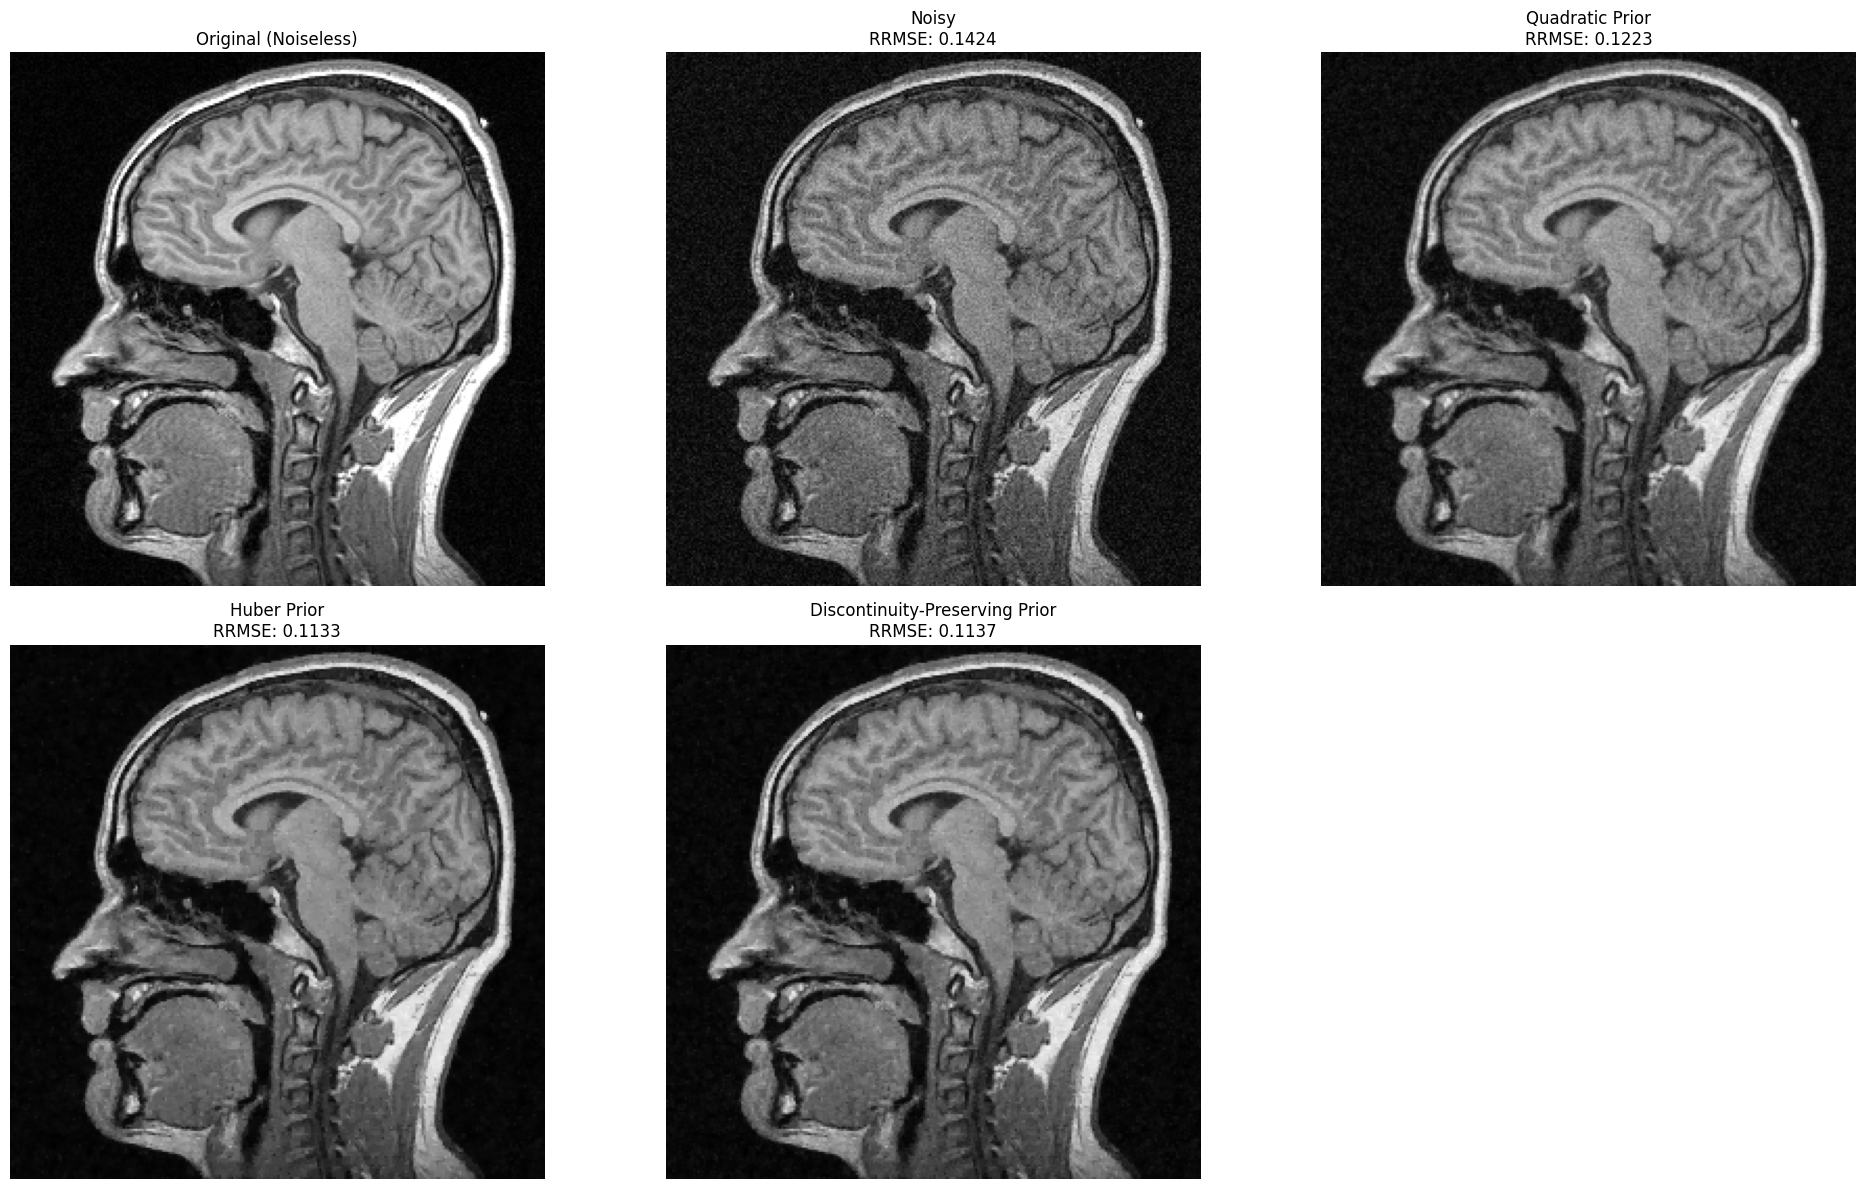

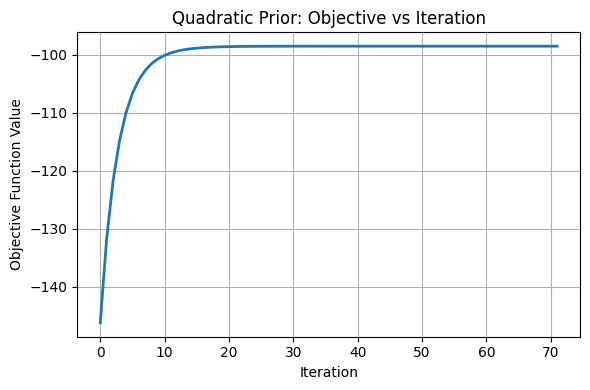

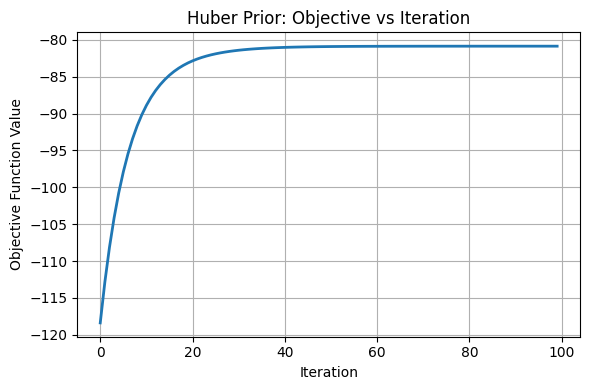

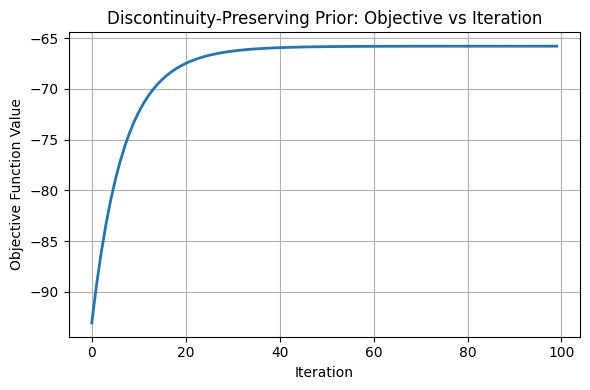


Detailed Parameter Summary:

QUADRATIC:
  α (alpha): 0.0387743942548
  RRMSE: 0.122346
  MSE: 0.002779
  PSNR: 25.56 dB

HUBER:
  α (alpha): 0.4651008360953125
  γ (gamma): 0.012349068310463942
  RRMSE: 0.113304
  MSE: 0.002384
  PSNR: 26.23 dB

DISCONTINUITY_PRESERVING:
  α (alpha): 0.5145886670309051
  γ (gamma): 0.010655383953377671
  RRMSE: 0.113690
  MSE: 0.002400
  PSNR: 26.20 dB


In [12]:
final_results = {}

den_quad, obj_quad = bayesian_denoising(
    image_noisy,
    alpha=best_alpha_quad,
    prior_type='quadratic',
    max_iterations=100,
    tolerance=1e-7
)
final_results['quadratic'] = {
    'denoised': den_quad,
    'rrmse': compute_rrmse(image_noiseless, den_quad),
    'alpha': best_alpha_quad,
    'gamma': None,
    'objective': obj_quad
}

den_huber, obj_huber = bayesian_denoising(
    image_noisy,
    alpha=best_alpha_huber,
    prior_type='huber',
    gamma=best_gamma_huber,
    max_iterations=100,
    tolerance=1e-7
)
final_results['huber'] = {
    'denoised': den_huber,
    'rrmse': compute_rrmse(image_noiseless, den_huber),
    'alpha': best_alpha_huber,
    'gamma': best_gamma_huber,
    'objective': obj_huber
}

den_disc, obj_disc = bayesian_denoising(
    image_noisy,
    alpha=best_alpha_disc,
    prior_type='discontinuity_preserving',
    gamma=best_gamma_disc,
    max_iterations=100,
    tolerance=1e-7
)
final_results['discontinuity_preserving'] = {
    'denoised': den_disc,
    'rrmse': compute_rrmse(image_noiseless, den_disc),
    'alpha': best_alpha_disc,
    'gamma': best_gamma_disc,
    'objective': obj_disc
}

plt.figure(figsize=(20, 12))

plt.subplot(2, 3, 1)
plt.imshow(image_noiseless, cmap='gray')
plt.title('Original (Noiseless)')
plt.axis('off')

plt.subplot(2, 3, 2)
plt.imshow(image_noisy, cmap='gray')
plt.title(f'Noisy\nRRMSE: {compute_rrmse(image_noiseless, image_noisy):.4f}')
plt.axis('off')

methods = ['quadratic', 'huber', 'discontinuity_preserving']
titles = ['Quadratic Prior', 'Huber Prior', 'Discontinuity-Preserving Prior']

for i, (method, title) in enumerate(zip(methods, titles)):
    result = final_results[method]

    ax = plt.subplot(2, 3, 3 + i)
    ax.imshow(result['denoised'], cmap='gray')
    ax.set_title(f'{title}\nRRMSE: {result["rrmse"]:.4f}')
    ax.axis('off')

plt.tight_layout()
plt.show()

plt.figure(figsize=(6, 4))
plt.plot(final_results['quadratic']['objective'], linewidth=2)
plt.xlabel('Iteration')
plt.ylabel('Objective Function Value')
plt.title('Quadratic Prior: Objective vs Iteration')
plt.grid(True)
plt.tight_layout()
plt.show()

plt.figure(figsize=(6, 4))
plt.plot(final_results['huber']['objective'], linewidth=2)
plt.xlabel('Iteration')
plt.ylabel('Objective Function Value')
plt.title('Huber Prior: Objective vs Iteration')
plt.grid(True)
plt.tight_layout()
plt.show()

plt.figure(figsize=(6, 4))
plt.plot(final_results['discontinuity_preserving']['objective'], linewidth=2)
plt.xlabel('Iteration')
plt.ylabel('Objective Function Value')
plt.title('Discontinuity-Preserving Prior: Objective vs Iteration')
plt.grid(True)
plt.tight_layout()
plt.show()


print("\nDetailed Parameter Summary:")
print("=" * 60)

for method, result in final_results.items():
    print(f"\n{method.upper()}:")
    print(f"  α (alpha): {result['alpha']}")
    if result['gamma'] is not None:
        print(f"  γ (gamma): {result['gamma']}")
    print(f"  RRMSE: {result['rrmse']:.6f}")

    mse = np.mean((result['denoised'] - image_noiseless) ** 2)
    psnr = 20 * np.log10(1.0 / np.sqrt(mse))

    print(f"  MSE: {mse:.6f}")
    print(f"  PSNR: {psnr:.2f} dB")
